In [1]:
import torch 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.utils as vutils

import time

from tqdm import tqdm

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('running on the gpu')
else:
    device = torch.device('cpu')
    print('running on the cpu')



running on the gpu


In [2]:
IMG_PATH = 'training_images'
IMG_SIZE = 64
MODEL_PATH = 'models'
batch_size = 128

In [3]:
transformation = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.ImageFolder(IMG_PATH, transform = transformation)

dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

train_set

Dataset ImageFolder
    Number of datapoints: 16185
    Root location: training_images
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

<IPython.core.display.Javascript object>


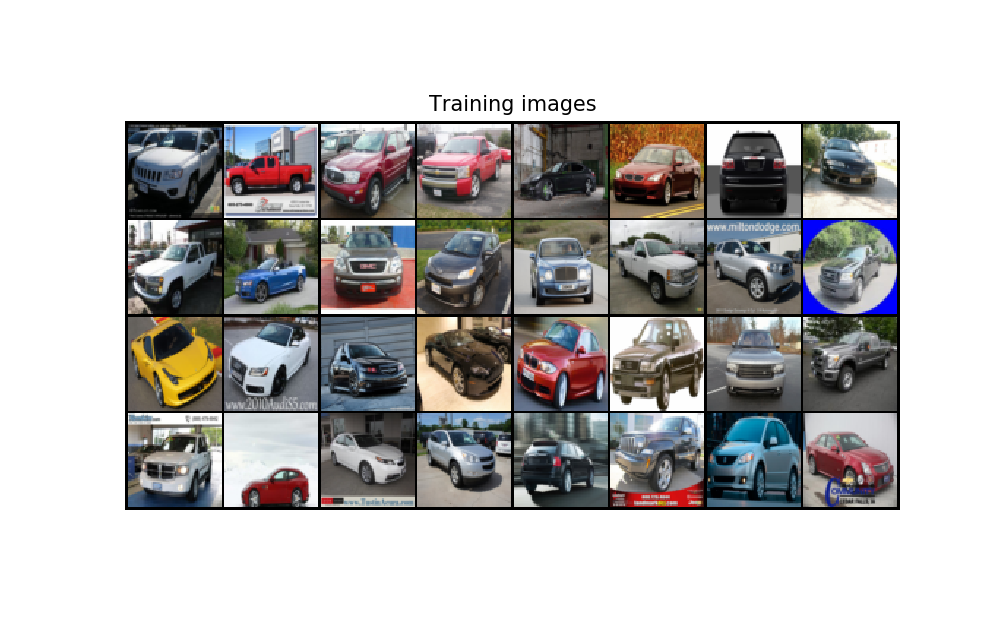

In [33]:
batch = next(iter(dataloader))
images = np.transpose(vutils.make_grid(batch[0][:32], normalize=True), (1,2,0))

fig, ax = plt.subplots(figsize = (8, 5))
plt.axis('off')
plt.title('Training images')
plt.imshow(images)
plt.savefig('training_images.png')
plt.show()

In [19]:
# Number of channels (3 for RGB images)
c = 3
# Size of latent vector used as input for the generator
z = 100
# Size of feature maps in generator
gf = 64
# Size of feature maps in discriminator
df = 64

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def g_block(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, final = False):
            
            if not final:
                block = nn.Sequential(
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                )
                
            else:
                block = nn.Sequential(
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                    nn.Tanh(),
                ) 
                
            return block
        
        self.main = nn.Sequential(*g_block(z, gf*8, stride = 1, padding = 0),
                                  *g_block(gf*8, gf*4),
                                  *g_block(gf*4, gf*2),
                                  *g_block(gf*2, gf),
                                  *g_block(gf, c, final = True),
                                  )

    
    def forward(self, X):
        return self.main(X)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def d_block(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, first = False):
            
            if first:
                block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False), 
                                  nn.LeakyReLU(0.2, inplace = True),
                                 )
                
            else:
                block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False), 
                                      nn.BatchNorm2d(out_channels),
                                      nn.LeakyReLU(0.2, inplace = True),
                                     )
    
            return block

    
        self.main = nn.Sequential(*d_block(c, df, first = True),
                                  *d_block(df, df*2),
                                  *d_block(df*2, df*4),
                                  *d_block(df*4, df*8),
                                  nn.Conv2d(df*8, 1, 4, 1, 0, bias = False),
                                  nn.Sigmoid(),
                                  )
        
        
    def forward(self, X):
        return self.main(X)
    

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

We implement the trainig algorithm from Goodfellow's original paper.

In [21]:
def train(epochs):
    MODEL_NAME = f'dcgan_{int(time.time())}'
    print(MODEL_NAME)
    with open(f'dcgan.log', 'a') as f:
        for epoch in range(epochs):
            for i, (batch, _) in (enumerate(tqdm(dataloader))):
                batch = batch.to(device)
                batch_size = batch.shape[0]
                # Use label = 1 for actual training images, label = 0 for generated images

                fake = torch.full((batch_size,), 0, device = device)
                real = torch.full((batch_size,), 1, device = device)

                #Training the discriminator
                discriminator.zero_grad()
                latent = torch.randn(batch_size, z, 1, 1, device = device)
                generated_images = generator(latent)
                real_loss = loss_function(discriminator(batch), real)
                fake_loss = loss_function(discriminator(generated_images.detach()).view(batch_size, 1, 1, -1), fake)
                d_loss = real_loss + fake_loss
                d_loss.backward()
                d_optimiser.step()

                #Training the generator
                generator.zero_grad()
                g_loss = loss_function(discriminator(generated_images), real)
                g_loss.backward()
                g_optimiser.step()

                if i % 10 == 0:
                    print('Epoch:', epoch, 'iteration:', i, 'Discriminator loss:', round(float(d_loss), 3), 'Generator loss:', round(float(g_loss),3))
                    
                f.write(f'{MODEL_NAME},{round(time.time(), 3)}, {epoch}, {i}, {round(float(d_loss), 3)}, {round(float(g_loss),3)}\n')
                
                if i == len(dataloader) - 1:
                    torch.save({
                                'epoch': epoch,
                                'model_state_dict': generator.state_dict(),
                                'optimiser_state_dict': g_optimiser.state_dict(),
                                'loss': g_loss,
                                
                                }, MODEL_PATH + f'\generator_{epoch}_epochs.tar')
                    
                    torch.save({
                                'epoch': epoch,
                                'model_state_dict': discriminator.state_dict(),
                                'optimiser_state_dict': d_optimiser.state_dict(),
                                'loss': d_loss,
                                
                                }, MODEL_PATH + f'\discriminator_{epoch}_epochs.tar')
                    
                    

In [11]:
generator = Generator()
discriminator = Discriminator()
generator, discriminator = generator.to(device), discriminator.to(device)
generator.apply(weights_init), discriminator.apply(weights_init)

g_optimiser = torch.optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
d_optimiser = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
loss_function = nn.BCELoss()

EPOCHS = 100

t0 = time.time()
train(EPOCHS)
t1 = time.time()
print('Total runtime:', round(t1 - t0, 3))

  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

dcgan_1582817146


C:\Users\brend\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
  1%|▋                                                                                 | 1/127 [00:02<04:53,  2.33s/it]

Epoch: 0 iteration: 0 Discriminator loss: 1.691 Generator loss: 6.396


  9%|███████                                                                          | 11/127 [00:14<02:20,  1.21s/it]

Epoch: 0 iteration: 10 Discriminator loss: 0.405 Generator loss: 8.647


 17%|█████████████▍                                                                   | 21/127 [00:26<02:07,  1.21s/it]

Epoch: 0 iteration: 20 Discriminator loss: 0.902 Generator loss: 18.06


 24%|███████████████████▊                                                             | 31/127 [00:38<01:59,  1.24s/it]

Epoch: 0 iteration: 30 Discriminator loss: 0.186 Generator loss: 7.324


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:45,  1.22s/it]

Epoch: 0 iteration: 40 Discriminator loss: 0.997 Generator loss: 23.61


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:27,  1.15s/it]

Epoch: 0 iteration: 50 Discriminator loss: 1.146 Generator loss: 22.173


 48%|██████████████████████████████████████▉                                          | 61/127 [01:15<01:16,  1.16s/it]

Epoch: 0 iteration: 60 Discriminator loss: 0.423 Generator loss: 8.141


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:28<01:06,  1.19s/it]

Epoch: 0 iteration: 70 Discriminator loss: 0.461 Generator loss: 7.823


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:41<00:55,  1.20s/it]

Epoch: 0 iteration: 80 Discriminator loss: 0.249 Generator loss: 9.998


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:53<00:43,  1.20s/it]

Epoch: 0 iteration: 90 Discriminator loss: 0.273 Generator loss: 5.106


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:39,  1.52s/it]

Epoch: 0 iteration: 100 Discriminator loss: 0.612 Generator loss: 5.632


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:19<00:18,  1.18s/it]

Epoch: 0 iteration: 110 Discriminator loss: 0.675 Generator loss: 3.459


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:32<00:07,  1.24s/it]

Epoch: 0 iteration: 120 Discriminator loss: 0.55 Generator loss: 3.361


 99%|███████████████████████████████████████████████████████████████████████████████▎| 126/127 [02:37<00:01,  1.21s/it]C:\Users\brend\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
  1%|▋                                                                                 | 1/127 [00:00<02:00,  1.05it/s]

Epoch: 1 iteration: 0 Discriminator loss: 0.511 Generator loss: 3.808


  9%|███████                                                                          | 11/127 [00:12<02:08,  1.11s/it]

Epoch: 1 iteration: 10 Discriminator loss: 0.556 Generator loss: 3.439


 17%|█████████████▍                                                                   | 21/127 [00:24<02:03,  1.16s/it]

Epoch: 1 iteration: 20 Discriminator loss: 0.624 Generator loss: 4.159


 24%|███████████████████▊                                                             | 31/127 [00:36<01:55,  1.20s/it]

Epoch: 1 iteration: 30 Discriminator loss: 0.553 Generator loss: 4.057


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:48,  1.27s/it]

Epoch: 1 iteration: 40 Discriminator loss: 0.593 Generator loss: 4.645


 40%|████████████████████████████████▌                                                | 51/127 [01:01<01:30,  1.19s/it]

Epoch: 1 iteration: 50 Discriminator loss: 0.935 Generator loss: 4.167


 48%|██████████████████████████████████████▉                                          | 61/127 [01:14<01:27,  1.32s/it]

Epoch: 1 iteration: 60 Discriminator loss: 1.686 Generator loss: 4.787


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:26<01:09,  1.23s/it]

Epoch: 1 iteration: 70 Discriminator loss: 0.653 Generator loss: 3.834


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:39<00:56,  1.24s/it]

Epoch: 1 iteration: 80 Discriminator loss: 0.404 Generator loss: 3.747


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:52<00:44,  1.23s/it]

Epoch: 1 iteration: 90 Discriminator loss: 0.513 Generator loss: 4.669


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:05<00:32,  1.24s/it]

Epoch: 1 iteration: 100 Discriminator loss: 0.791 Generator loss: 7.596


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:17<00:18,  1.18s/it]

Epoch: 1 iteration: 110 Discriminator loss: 0.599 Generator loss: 8.067


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:29<00:07,  1.27s/it]

Epoch: 1 iteration: 120 Discriminator loss: 0.296 Generator loss: 4.579


  1%|▋                                                                                 | 1/127 [00:01<03:00,  1.43s/it]

Epoch: 2 iteration: 0 Discriminator loss: 0.752 Generator loss: 3.948


  9%|███████                                                                          | 11/127 [00:13<02:16,  1.18s/it]

Epoch: 2 iteration: 10 Discriminator loss: 0.461 Generator loss: 3.965


 17%|█████████████▍                                                                   | 21/127 [00:25<02:02,  1.16s/it]

Epoch: 2 iteration: 20 Discriminator loss: 0.633 Generator loss: 3.02


 24%|███████████████████▊                                                             | 31/127 [00:38<02:07,  1.33s/it]

Epoch: 2 iteration: 30 Discriminator loss: 0.479 Generator loss: 2.193


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:48,  1.27s/it]

Epoch: 2 iteration: 40 Discriminator loss: 0.966 Generator loss: 4.614


 40%|████████████████████████████████▌                                                | 51/127 [01:03<01:43,  1.37s/it]

Epoch: 2 iteration: 50 Discriminator loss: 0.631 Generator loss: 3.554


 48%|██████████████████████████████████████▉                                          | 61/127 [01:15<01:20,  1.22s/it]

Epoch: 2 iteration: 60 Discriminator loss: 0.748 Generator loss: 3.502


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:27<01:05,  1.17s/it]

Epoch: 2 iteration: 70 Discriminator loss: 0.535 Generator loss: 3.423


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<01:17,  1.68s/it]

Epoch: 2 iteration: 80 Discriminator loss: 0.326 Generator loss: 3.54


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:57<00:58,  1.62s/it]

Epoch: 2 iteration: 90 Discriminator loss: 0.581 Generator loss: 4.959


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:12<00:38,  1.47s/it]

Epoch: 2 iteration: 100 Discriminator loss: 0.308 Generator loss: 4.411


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:25<00:22,  1.38s/it]

Epoch: 2 iteration: 110 Discriminator loss: 0.271 Generator loss: 4.237


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:37<00:06,  1.15s/it]

Epoch: 2 iteration: 120 Discriminator loss: 0.942 Generator loss: 3.812


  1%|▋                                                                                 | 1/127 [00:01<02:20,  1.11s/it]

Epoch: 3 iteration: 0 Discriminator loss: 0.549 Generator loss: 5.233


  9%|███████                                                                          | 11/127 [00:14<02:22,  1.22s/it]

Epoch: 3 iteration: 10 Discriminator loss: 0.808 Generator loss: 5.332


 17%|█████████████▍                                                                   | 21/127 [00:26<02:13,  1.26s/it]

Epoch: 3 iteration: 20 Discriminator loss: 0.438 Generator loss: 3.391


 24%|███████████████████▊                                                             | 31/127 [00:40<02:04,  1.30s/it]

Epoch: 3 iteration: 30 Discriminator loss: 0.349 Generator loss: 4.641


 32%|██████████████████████████▏                                                      | 41/127 [00:53<01:47,  1.25s/it]

Epoch: 3 iteration: 40 Discriminator loss: 0.199 Generator loss: 4.976


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:43,  1.37s/it]

Epoch: 3 iteration: 50 Discriminator loss: 0.312 Generator loss: 4.874


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:29,  1.35s/it]

Epoch: 3 iteration: 60 Discriminator loss: 0.306 Generator loss: 6.292


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:32<01:11,  1.27s/it]

Epoch: 3 iteration: 70 Discriminator loss: 0.837 Generator loss: 2.205


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:52,  1.13s/it]

Epoch: 3 iteration: 80 Discriminator loss: 0.659 Generator loss: 8.187


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:57<00:47,  1.32s/it]

Epoch: 3 iteration: 90 Discriminator loss: 0.525 Generator loss: 3.527


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:09<00:34,  1.33s/it]

Epoch: 3 iteration: 100 Discriminator loss: 0.292 Generator loss: 4.381


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:21<00:18,  1.13s/it]

Epoch: 3 iteration: 110 Discriminator loss: 0.557 Generator loss: 3.337


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:33<00:07,  1.17s/it]

Epoch: 3 iteration: 120 Discriminator loss: 0.501 Generator loss: 3.998


  1%|▋                                                                                 | 1/127 [00:01<02:24,  1.15s/it]

Epoch: 4 iteration: 0 Discriminator loss: 0.307 Generator loss: 4.442


  9%|███████                                                                          | 11/127 [00:13<02:24,  1.24s/it]

Epoch: 4 iteration: 10 Discriminator loss: 0.493 Generator loss: 7.74


 17%|█████████████▍                                                                   | 21/127 [00:25<02:12,  1.25s/it]

Epoch: 4 iteration: 20 Discriminator loss: 0.487 Generator loss: 3.163


 24%|███████████████████▊                                                             | 31/127 [00:37<01:51,  1.17s/it]

Epoch: 4 iteration: 30 Discriminator loss: 0.92 Generator loss: 5.102


 32%|██████████████████████████▏                                                      | 41/127 [00:50<01:38,  1.14s/it]

Epoch: 4 iteration: 40 Discriminator loss: 0.836 Generator loss: 2.114


 40%|████████████████████████████████▌                                                | 51/127 [01:02<01:28,  1.17s/it]

Epoch: 4 iteration: 50 Discriminator loss: 0.412 Generator loss: 3.683


 48%|██████████████████████████████████████▉                                          | 61/127 [01:15<01:22,  1.25s/it]

Epoch: 4 iteration: 60 Discriminator loss: 0.397 Generator loss: 3.329


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:26<01:05,  1.18s/it]

Epoch: 4 iteration: 70 Discriminator loss: 0.262 Generator loss: 4.559


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:38<00:55,  1.20s/it]

Epoch: 4 iteration: 80 Discriminator loss: 0.922 Generator loss: 5.305


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:51<00:45,  1.26s/it]

Epoch: 4 iteration: 90 Discriminator loss: 0.35 Generator loss: 5.008


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:03<00:32,  1.23s/it]

Epoch: 4 iteration: 100 Discriminator loss: 0.554 Generator loss: 6.909


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:17<00:21,  1.32s/it]

Epoch: 4 iteration: 110 Discriminator loss: 0.375 Generator loss: 4.816


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:29<00:07,  1.31s/it]

Epoch: 4 iteration: 120 Discriminator loss: 0.326 Generator loss: 4.965


  1%|▋                                                                                 | 1/127 [00:01<02:28,  1.18s/it]

Epoch: 5 iteration: 0 Discriminator loss: 0.518 Generator loss: 7.03


  9%|███████                                                                          | 11/127 [00:14<02:35,  1.34s/it]

Epoch: 5 iteration: 10 Discriminator loss: 0.417 Generator loss: 3.168


 17%|█████████████▍                                                                   | 21/127 [00:26<02:14,  1.27s/it]

Epoch: 5 iteration: 20 Discriminator loss: 0.382 Generator loss: 5.312


 24%|███████████████████▊                                                             | 31/127 [00:39<02:01,  1.27s/it]

Epoch: 5 iteration: 30 Discriminator loss: 0.347 Generator loss: 5.388


 32%|██████████████████████████▏                                                      | 41/127 [00:53<01:55,  1.34s/it]

Epoch: 5 iteration: 40 Discriminator loss: 0.688 Generator loss: 7.245


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:32,  1.21s/it]

Epoch: 5 iteration: 50 Discriminator loss: 0.795 Generator loss: 2.945


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:20,  1.22s/it]

Epoch: 5 iteration: 60 Discriminator loss: 0.417 Generator loss: 4.198


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:29<01:06,  1.18s/it]

Epoch: 5 iteration: 70 Discriminator loss: 0.49 Generator loss: 4.134


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<01:03,  1.37s/it]

Epoch: 5 iteration: 80 Discriminator loss: 0.412 Generator loss: 3.819


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:54<00:45,  1.26s/it]

Epoch: 5 iteration: 90 Discriminator loss: 0.217 Generator loss: 4.449


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:07<00:32,  1.27s/it]

Epoch: 5 iteration: 100 Discriminator loss: 0.374 Generator loss: 4.7


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:20<00:21,  1.36s/it]

Epoch: 5 iteration: 110 Discriminator loss: 0.636 Generator loss: 3.047


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:33<00:07,  1.30s/it]

Epoch: 5 iteration: 120 Discriminator loss: 0.613 Generator loss: 6.367


  1%|▋                                                                                 | 1/127 [00:01<02:55,  1.39s/it]

Epoch: 6 iteration: 0 Discriminator loss: 0.304 Generator loss: 4.418


  9%|███████                                                                          | 11/127 [00:13<02:29,  1.29s/it]

Epoch: 6 iteration: 10 Discriminator loss: 0.379 Generator loss: 4.15


 17%|█████████████▍                                                                   | 21/127 [00:26<02:34,  1.46s/it]

Epoch: 6 iteration: 20 Discriminator loss: 0.395 Generator loss: 4.765


 24%|███████████████████▊                                                             | 31/127 [00:39<02:03,  1.29s/it]

Epoch: 6 iteration: 30 Discriminator loss: 0.584 Generator loss: 4.396


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:53,  1.32s/it]

Epoch: 6 iteration: 40 Discriminator loss: 1.94 Generator loss: 8.529


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:30,  1.19s/it]

Epoch: 6 iteration: 50 Discriminator loss: 0.742 Generator loss: 2.889


 48%|██████████████████████████████████████▉                                          | 61/127 [01:16<01:17,  1.17s/it]

Epoch: 6 iteration: 60 Discriminator loss: 0.626 Generator loss: 3.263


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:29<01:13,  1.30s/it]

Epoch: 6 iteration: 70 Discriminator loss: 0.481 Generator loss: 3.226


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:40<00:51,  1.13s/it]

Epoch: 6 iteration: 80 Discriminator loss: 0.528 Generator loss: 4.266


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:51<00:41,  1.14s/it]

Epoch: 6 iteration: 90 Discriminator loss: 0.311 Generator loss: 4.557


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:04<00:31,  1.23s/it]

Epoch: 6 iteration: 100 Discriminator loss: 0.4 Generator loss: 4.235


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:16<00:20,  1.25s/it]

Epoch: 6 iteration: 110 Discriminator loss: 0.324 Generator loss: 4.145


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:29<00:08,  1.36s/it]

Epoch: 6 iteration: 120 Discriminator loss: 0.404 Generator loss: 4.118


  1%|▋                                                                                 | 1/127 [00:01<02:24,  1.15s/it]

Epoch: 7 iteration: 0 Discriminator loss: 0.419 Generator loss: 4.264


  9%|███████                                                                          | 11/127 [00:13<02:18,  1.19s/it]

Epoch: 7 iteration: 10 Discriminator loss: 0.358 Generator loss: 3.975


 17%|█████████████▍                                                                   | 21/127 [00:24<02:00,  1.13s/it]

Epoch: 7 iteration: 20 Discriminator loss: 0.23 Generator loss: 4.329


 24%|███████████████████▊                                                             | 31/127 [00:37<02:06,  1.32s/it]

Epoch: 7 iteration: 30 Discriminator loss: 0.323 Generator loss: 5.581


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:45,  1.23s/it]

Epoch: 7 iteration: 40 Discriminator loss: 0.762 Generator loss: 3.113


 40%|████████████████████████████████▌                                                | 51/127 [01:03<01:36,  1.27s/it]

Epoch: 7 iteration: 50 Discriminator loss: 0.431 Generator loss: 3.701


 48%|██████████████████████████████████████▉                                          | 61/127 [01:14<01:13,  1.11s/it]

Epoch: 7 iteration: 60 Discriminator loss: 0.342 Generator loss: 3.456


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:26<01:12,  1.30s/it]

Epoch: 7 iteration: 70 Discriminator loss: 0.381 Generator loss: 3.721


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:39<00:56,  1.23s/it]

Epoch: 7 iteration: 80 Discriminator loss: 0.268 Generator loss: 3.746


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:52<00:51,  1.43s/it]

Epoch: 7 iteration: 90 Discriminator loss: 0.386 Generator loss: 5.247


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:05<00:33,  1.30s/it]

Epoch: 7 iteration: 100 Discriminator loss: 1.323 Generator loss: 10.284


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:21<00:26,  1.66s/it]

Epoch: 7 iteration: 110 Discriminator loss: 0.707 Generator loss: 4.073


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:37<00:09,  1.59s/it]

Epoch: 7 iteration: 120 Discriminator loss: 0.244 Generator loss: 4.914


  1%|▋                                                                                 | 1/127 [00:01<03:55,  1.87s/it]

Epoch: 8 iteration: 0 Discriminator loss: 0.558 Generator loss: 3.416


  9%|███████                                                                          | 11/127 [00:16<02:52,  1.48s/it]

Epoch: 8 iteration: 10 Discriminator loss: 0.265 Generator loss: 4.513


 17%|█████████████▍                                                                   | 21/127 [00:29<02:19,  1.32s/it]

Epoch: 8 iteration: 20 Discriminator loss: 0.292 Generator loss: 3.092


 24%|███████████████████▊                                                             | 31/127 [00:42<02:06,  1.32s/it]

Epoch: 8 iteration: 30 Discriminator loss: 0.462 Generator loss: 4.411


 32%|██████████████████████████▏                                                      | 41/127 [00:56<01:56,  1.35s/it]

Epoch: 8 iteration: 40 Discriminator loss: 0.434 Generator loss: 4.025


 40%|████████████████████████████████▌                                                | 51/127 [01:10<01:46,  1.40s/it]

Epoch: 8 iteration: 50 Discriminator loss: 1.145 Generator loss: 9.49


 48%|██████████████████████████████████████▉                                          | 61/127 [01:23<01:23,  1.26s/it]

Epoch: 8 iteration: 60 Discriminator loss: 0.69 Generator loss: 6.657


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:36<01:19,  1.41s/it]

Epoch: 8 iteration: 70 Discriminator loss: 0.248 Generator loss: 4.23


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<01:03,  1.38s/it]

Epoch: 8 iteration: 80 Discriminator loss: 0.574 Generator loss: 4.854


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:03<00:47,  1.32s/it]

Epoch: 8 iteration: 90 Discriminator loss: 0.346 Generator loss: 3.944


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:16<00:37,  1.43s/it]

Epoch: 8 iteration: 100 Discriminator loss: 1.312 Generator loss: 1.452


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:29<00:20,  1.30s/it]

Epoch: 8 iteration: 110 Discriminator loss: 0.308 Generator loss: 4.555


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:42<00:07,  1.25s/it]

Epoch: 8 iteration: 120 Discriminator loss: 0.342 Generator loss: 4.769


  1%|▋                                                                                 | 1/127 [00:01<03:12,  1.52s/it]

Epoch: 9 iteration: 0 Discriminator loss: 0.349 Generator loss: 5.163


  9%|███████                                                                          | 11/127 [00:15<02:38,  1.36s/it]

Epoch: 9 iteration: 10 Discriminator loss: 0.346 Generator loss: 5.575


 17%|█████████████▍                                                                   | 21/127 [00:28<02:18,  1.31s/it]

Epoch: 9 iteration: 20 Discriminator loss: 0.236 Generator loss: 4.578


 24%|███████████████████▊                                                             | 31/127 [00:41<02:07,  1.32s/it]

Epoch: 9 iteration: 30 Discriminator loss: 0.331 Generator loss: 5.203


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:51,  1.30s/it]

Epoch: 9 iteration: 40 Discriminator loss: 0.349 Generator loss: 3.563


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:48,  1.43s/it]

Epoch: 9 iteration: 50 Discriminator loss: 0.44 Generator loss: 2.955


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:26,  1.32s/it]

Epoch: 9 iteration: 60 Discriminator loss: 0.178 Generator loss: 5.319


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:05,  1.17s/it]

Epoch: 9 iteration: 70 Discriminator loss: 0.29 Generator loss: 3.851


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:48<00:57,  1.24s/it]

Epoch: 9 iteration: 80 Discriminator loss: 0.329 Generator loss: 7.178


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:47,  1.31s/it]

Epoch: 9 iteration: 90 Discriminator loss: 0.75 Generator loss: 3.589


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:15<00:37,  1.43s/it]

Epoch: 9 iteration: 100 Discriminator loss: 0.423 Generator loss: 3.138


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:21,  1.31s/it]

Epoch: 9 iteration: 110 Discriminator loss: 0.369 Generator loss: 3.49


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:08,  1.34s/it]

Epoch: 9 iteration: 120 Discriminator loss: 0.437 Generator loss: 5.463


  1%|▋                                                                                 | 1/127 [00:01<03:16,  1.56s/it]

Epoch: 10 iteration: 0 Discriminator loss: 0.319 Generator loss: 5.363


  9%|███████                                                                          | 11/127 [00:14<02:37,  1.35s/it]

Epoch: 10 iteration: 10 Discriminator loss: 0.254 Generator loss: 4.323


 17%|█████████████▍                                                                   | 21/127 [00:27<02:17,  1.30s/it]

Epoch: 10 iteration: 20 Discriminator loss: 0.194 Generator loss: 5.89


 24%|███████████████████▊                                                             | 31/127 [00:40<01:59,  1.24s/it]

Epoch: 10 iteration: 30 Discriminator loss: 0.303 Generator loss: 4.471


 32%|██████████████████████████▏                                                      | 41/127 [00:53<01:49,  1.27s/it]

Epoch: 10 iteration: 40 Discriminator loss: 0.261 Generator loss: 4.356


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:41,  1.33s/it]

Epoch: 10 iteration: 50 Discriminator loss: 0.557 Generator loss: 7.495


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:29,  1.36s/it]

Epoch: 10 iteration: 60 Discriminator loss: 0.246 Generator loss: 4.227


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:33<01:10,  1.27s/it]

Epoch: 10 iteration: 70 Discriminator loss: 0.335 Generator loss: 5.175


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:47<01:02,  1.36s/it]

Epoch: 10 iteration: 80 Discriminator loss: 0.276 Generator loss: 4.083


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:00<00:44,  1.23s/it]

Epoch: 10 iteration: 90 Discriminator loss: 0.325 Generator loss: 6.026


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:35,  1.35s/it]

Epoch: 10 iteration: 100 Discriminator loss: 0.448 Generator loss: 2.099


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:28<00:23,  1.44s/it]

Epoch: 10 iteration: 110 Discriminator loss: 0.568 Generator loss: 6.609


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:42<00:08,  1.40s/it]

Epoch: 10 iteration: 120 Discriminator loss: 0.371 Generator loss: 4.061


  1%|▋                                                                                 | 1/127 [00:01<02:59,  1.43s/it]

Epoch: 11 iteration: 0 Discriminator loss: 0.41 Generator loss: 4.677


  9%|███████                                                                          | 11/127 [00:13<02:25,  1.25s/it]

Epoch: 11 iteration: 10 Discriminator loss: 0.224 Generator loss: 3.419


 17%|█████████████▍                                                                   | 21/127 [00:27<02:18,  1.30s/it]

Epoch: 11 iteration: 20 Discriminator loss: 0.347 Generator loss: 3.75


 24%|███████████████████▊                                                             | 31/127 [00:40<01:56,  1.22s/it]

Epoch: 11 iteration: 30 Discriminator loss: 0.285 Generator loss: 4.477


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:53,  1.32s/it]

Epoch: 11 iteration: 40 Discriminator loss: 0.346 Generator loss: 3.429


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:46,  1.40s/it]

Epoch: 11 iteration: 50 Discriminator loss: 0.906 Generator loss: 2.903


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:26,  1.31s/it]

Epoch: 11 iteration: 60 Discriminator loss: 0.4 Generator loss: 3.806


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:15,  1.36s/it]

Epoch: 11 iteration: 70 Discriminator loss: 0.288 Generator loss: 3.916


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:48<01:08,  1.48s/it]

Epoch: 11 iteration: 80 Discriminator loss: 0.921 Generator loss: 3.78


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:45,  1.28s/it]

Epoch: 11 iteration: 90 Discriminator loss: 0.473 Generator loss: 5.976


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:15<00:35,  1.37s/it]

Epoch: 11 iteration: 100 Discriminator loss: 0.401 Generator loss: 6.66


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:28<00:22,  1.38s/it]

Epoch: 11 iteration: 110 Discriminator loss: 1.232 Generator loss: 1.436


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:07,  1.28s/it]

Epoch: 11 iteration: 120 Discriminator loss: 0.367 Generator loss: 6.06


  1%|▋                                                                                 | 1/127 [00:01<02:34,  1.22s/it]

Epoch: 12 iteration: 0 Discriminator loss: 0.324 Generator loss: 4.657


  9%|███████                                                                          | 11/127 [00:14<02:34,  1.33s/it]

Epoch: 12 iteration: 10 Discriminator loss: 0.345 Generator loss: 4.614


 17%|█████████████▍                                                                   | 21/127 [00:28<02:17,  1.30s/it]

Epoch: 12 iteration: 20 Discriminator loss: 0.658 Generator loss: 2.949


 24%|███████████████████▊                                                             | 31/127 [00:41<02:11,  1.37s/it]

Epoch: 12 iteration: 30 Discriminator loss: 0.286 Generator loss: 4.429


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:52,  1.31s/it]

Epoch: 12 iteration: 40 Discriminator loss: 0.37 Generator loss: 5.206


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:45,  1.39s/it]

Epoch: 12 iteration: 50 Discriminator loss: 0.36 Generator loss: 5.473


 48%|██████████████████████████████████████▉                                          | 61/127 [01:22<01:31,  1.39s/it]

Epoch: 12 iteration: 60 Discriminator loss: 0.317 Generator loss: 3.993


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:36<01:16,  1.36s/it]

Epoch: 12 iteration: 70 Discriminator loss: 0.31 Generator loss: 3.981


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<01:00,  1.30s/it]

Epoch: 12 iteration: 80 Discriminator loss: 0.272 Generator loss: 3.722


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:44,  1.24s/it]

Epoch: 12 iteration: 90 Discriminator loss: 0.276 Generator loss: 3.815


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:15<00:33,  1.29s/it]

Epoch: 12 iteration: 100 Discriminator loss: 0.312 Generator loss: 3.698


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:28<00:19,  1.24s/it]

Epoch: 12 iteration: 110 Discriminator loss: 0.392 Generator loss: 4.889


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:42<00:08,  1.41s/it]

Epoch: 12 iteration: 120 Discriminator loss: 0.338 Generator loss: 4.752


  1%|▋                                                                                 | 1/127 [00:01<03:23,  1.61s/it]

Epoch: 13 iteration: 0 Discriminator loss: 0.262 Generator loss: 3.215


  9%|███████                                                                          | 11/127 [00:15<02:41,  1.39s/it]

Epoch: 13 iteration: 10 Discriminator loss: 0.36 Generator loss: 4.842


 17%|█████████████▍                                                                   | 21/127 [00:28<02:18,  1.30s/it]

Epoch: 13 iteration: 20 Discriminator loss: 3.399 Generator loss: 7.629


 24%|███████████████████▊                                                             | 31/127 [00:42<02:13,  1.39s/it]

Epoch: 13 iteration: 30 Discriminator loss: 0.677 Generator loss: 3.401


 32%|██████████████████████████▏                                                      | 41/127 [00:56<01:56,  1.36s/it]

Epoch: 13 iteration: 40 Discriminator loss: 0.599 Generator loss: 5.478


 40%|████████████████████████████████▌                                                | 51/127 [01:10<01:35,  1.26s/it]

Epoch: 13 iteration: 50 Discriminator loss: 0.21 Generator loss: 4.027


 48%|██████████████████████████████████████▉                                          | 61/127 [01:22<01:17,  1.17s/it]

Epoch: 13 iteration: 60 Discriminator loss: 0.365 Generator loss: 4.452


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:06,  1.18s/it]

Epoch: 13 iteration: 70 Discriminator loss: 0.316 Generator loss: 3.726


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:46<00:56,  1.24s/it]

Epoch: 13 iteration: 80 Discriminator loss: 0.371 Generator loss: 3.329


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:59<00:46,  1.29s/it]

Epoch: 13 iteration: 90 Discriminator loss: 0.38 Generator loss: 3.645


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:12<00:33,  1.29s/it]

Epoch: 13 iteration: 100 Discriminator loss: 0.5 Generator loss: 5.777


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:25<00:19,  1.23s/it]

Epoch: 13 iteration: 110 Discriminator loss: 0.268 Generator loss: 4.337


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:38<00:07,  1.28s/it]

Epoch: 13 iteration: 120 Discriminator loss: 0.405 Generator loss: 2.717


  1%|▋                                                                                 | 1/127 [00:01<02:21,  1.12s/it]

Epoch: 14 iteration: 0 Discriminator loss: 1.31 Generator loss: 6.125


  9%|███████                                                                          | 11/127 [00:15<02:52,  1.49s/it]

Epoch: 14 iteration: 10 Discriminator loss: 0.517 Generator loss: 3.782


 17%|█████████████▍                                                                   | 21/127 [00:29<02:49,  1.60s/it]

Epoch: 14 iteration: 20 Discriminator loss: 0.656 Generator loss: 7.168


 24%|███████████████████▊                                                             | 31/127 [00:44<02:29,  1.56s/it]

Epoch: 14 iteration: 30 Discriminator loss: 0.307 Generator loss: 3.631


 32%|██████████████████████████▏                                                      | 41/127 [00:58<02:00,  1.40s/it]

Epoch: 14 iteration: 40 Discriminator loss: 0.288 Generator loss: 4.697


 40%|████████████████████████████████▌                                                | 51/127 [01:11<01:30,  1.19s/it]

Epoch: 14 iteration: 50 Discriminator loss: 0.307 Generator loss: 3.742


 48%|██████████████████████████████████████▉                                          | 61/127 [01:24<01:26,  1.31s/it]

Epoch: 14 iteration: 60 Discriminator loss: 0.326 Generator loss: 4.042


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:37<01:17,  1.38s/it]

Epoch: 14 iteration: 70 Discriminator loss: 0.276 Generator loss: 3.547


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:50<00:57,  1.24s/it]

Epoch: 14 iteration: 80 Discriminator loss: 0.264 Generator loss: 3.446


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:45,  1.26s/it]

Epoch: 14 iteration: 90 Discriminator loss: 0.272 Generator loss: 5.03


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:16<00:32,  1.24s/it]

Epoch: 14 iteration: 100 Discriminator loss: 0.394 Generator loss: 4.067


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:29<00:21,  1.37s/it]

Epoch: 14 iteration: 110 Discriminator loss: 1.434 Generator loss: 7.947


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:43<00:08,  1.39s/it]

Epoch: 14 iteration: 120 Discriminator loss: 0.653 Generator loss: 2.606


  1%|▋                                                                                 | 1/127 [00:01<02:22,  1.13s/it]

Epoch: 15 iteration: 0 Discriminator loss: 0.321 Generator loss: 4.948


  9%|███████                                                                          | 11/127 [00:14<02:30,  1.29s/it]

Epoch: 15 iteration: 10 Discriminator loss: 0.292 Generator loss: 3.24


 17%|█████████████▍                                                                   | 21/127 [00:28<02:30,  1.42s/it]

Epoch: 15 iteration: 20 Discriminator loss: 0.383 Generator loss: 4.163


 24%|███████████████████▊                                                             | 31/127 [00:41<02:01,  1.27s/it]

Epoch: 15 iteration: 30 Discriminator loss: 0.267 Generator loss: 3.739


 32%|██████████████████████████▏                                                      | 41/127 [00:55<01:59,  1.39s/it]

Epoch: 15 iteration: 40 Discriminator loss: 0.288 Generator loss: 3.17


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:48,  1.42s/it]

Epoch: 15 iteration: 50 Discriminator loss: 0.308 Generator loss: 3.544


 48%|██████████████████████████████████████▉                                          | 61/127 [01:22<01:27,  1.33s/it]

Epoch: 15 iteration: 60 Discriminator loss: 0.22 Generator loss: 3.911


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:36<01:22,  1.47s/it]

Epoch: 15 iteration: 70 Discriminator loss: 0.318 Generator loss: 3.058


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<01:01,  1.34s/it]

Epoch: 15 iteration: 80 Discriminator loss: 0.254 Generator loss: 4.304


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:03<00:53,  1.48s/it]

Epoch: 15 iteration: 90 Discriminator loss: 0.898 Generator loss: 2.983


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:17<00:35,  1.35s/it]

Epoch: 15 iteration: 100 Discriminator loss: 0.381 Generator loss: 3.585


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:32<00:25,  1.57s/it]

Epoch: 15 iteration: 110 Discriminator loss: 0.297 Generator loss: 4.033


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:44<00:07,  1.27s/it]

Epoch: 15 iteration: 120 Discriminator loss: 0.324 Generator loss: 4.652


  1%|▋                                                                                 | 1/127 [00:01<02:45,  1.31s/it]

Epoch: 16 iteration: 0 Discriminator loss: 0.539 Generator loss: 6.262


  9%|███████                                                                          | 11/127 [00:13<02:25,  1.25s/it]

Epoch: 16 iteration: 10 Discriminator loss: 0.529 Generator loss: 5.137


 17%|█████████████▍                                                                   | 21/127 [00:26<02:27,  1.39s/it]

Epoch: 16 iteration: 20 Discriminator loss: 0.356 Generator loss: 3.657


 24%|███████████████████▊                                                             | 31/127 [00:38<01:56,  1.22s/it]

Epoch: 16 iteration: 30 Discriminator loss: 0.471 Generator loss: 4.646


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:53,  1.32s/it]

Epoch: 16 iteration: 40 Discriminator loss: 0.618 Generator loss: 2.026


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:34,  1.25s/it]

Epoch: 16 iteration: 50 Discriminator loss: 0.228 Generator loss: 4.209


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:20,  1.22s/it]

Epoch: 16 iteration: 60 Discriminator loss: 0.35 Generator loss: 4.625


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:28<01:01,  1.10s/it]

Epoch: 16 iteration: 70 Discriminator loss: 0.325 Generator loss: 3.345


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:41<00:59,  1.30s/it]

Epoch: 16 iteration: 80 Discriminator loss: 0.466 Generator loss: 5.553


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:54<00:49,  1.38s/it]

Epoch: 16 iteration: 90 Discriminator loss: 0.435 Generator loss: 5.458


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:06<00:34,  1.34s/it]

Epoch: 16 iteration: 100 Discriminator loss: 0.743 Generator loss: 5.692


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:20<00:19,  1.25s/it]

Epoch: 16 iteration: 110 Discriminator loss: 0.533 Generator loss: 5.436


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:34<00:09,  1.53s/it]

Epoch: 16 iteration: 120 Discriminator loss: 0.522 Generator loss: 2.852


  1%|▋                                                                                 | 1/127 [00:01<02:25,  1.16s/it]

Epoch: 17 iteration: 0 Discriminator loss: 0.907 Generator loss: 1.664


  9%|███████                                                                          | 11/127 [00:14<02:25,  1.26s/it]

Epoch: 17 iteration: 10 Discriminator loss: 0.302 Generator loss: 3.394


 17%|█████████████▍                                                                   | 21/127 [00:26<02:13,  1.26s/it]

Epoch: 17 iteration: 20 Discriminator loss: 0.511 Generator loss: 5.828


 24%|███████████████████▊                                                             | 31/127 [00:40<02:13,  1.39s/it]

Epoch: 17 iteration: 30 Discriminator loss: 0.268 Generator loss: 3.127


 32%|██████████████████████████▏                                                      | 41/127 [00:53<01:55,  1.34s/it]

Epoch: 17 iteration: 40 Discriminator loss: 0.366 Generator loss: 3.232


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:40,  1.32s/it]

Epoch: 17 iteration: 50 Discriminator loss: 0.381 Generator loss: 5.508


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:25,  1.29s/it]

Epoch: 17 iteration: 60 Discriminator loss: 0.34 Generator loss: 4.347


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:32<01:20,  1.44s/it]

Epoch: 17 iteration: 70 Discriminator loss: 0.367 Generator loss: 4.847


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:45<01:01,  1.35s/it]

Epoch: 17 iteration: 80 Discriminator loss: 0.319 Generator loss: 3.749


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:57<00:42,  1.19s/it]

Epoch: 17 iteration: 90 Discriminator loss: 0.546 Generator loss: 6.377


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:09<00:31,  1.21s/it]

Epoch: 17 iteration: 100 Discriminator loss: 0.527 Generator loss: 5.493


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:22<00:19,  1.24s/it]

Epoch: 17 iteration: 110 Discriminator loss: 0.366 Generator loss: 5.461


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:34<00:07,  1.19s/it]

Epoch: 17 iteration: 120 Discriminator loss: 0.307 Generator loss: 3.563


  1%|▋                                                                                 | 1/127 [00:01<03:15,  1.55s/it]

Epoch: 18 iteration: 0 Discriminator loss: 0.444 Generator loss: 2.764


  9%|███████                                                                          | 11/127 [00:14<02:27,  1.27s/it]

Epoch: 18 iteration: 10 Discriminator loss: 0.406 Generator loss: 3.396


 17%|█████████████▍                                                                   | 21/127 [00:27<02:09,  1.22s/it]

Epoch: 18 iteration: 20 Discriminator loss: 0.652 Generator loss: 5.371


 24%|███████████████████▊                                                             | 31/127 [00:39<02:05,  1.30s/it]

Epoch: 18 iteration: 30 Discriminator loss: 0.324 Generator loss: 3.29


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:47,  1.25s/it]

Epoch: 18 iteration: 40 Discriminator loss: 0.276 Generator loss: 4.09


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:29,  1.18s/it]

Epoch: 18 iteration: 50 Discriminator loss: 0.472 Generator loss: 2.166


 48%|██████████████████████████████████████▉                                          | 61/127 [01:16<01:19,  1.20s/it]

Epoch: 18 iteration: 60 Discriminator loss: 0.484 Generator loss: 2.439


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:29<01:24,  1.51s/it]

Epoch: 18 iteration: 70 Discriminator loss: 0.358 Generator loss: 4.084


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<00:58,  1.28s/it]

Epoch: 18 iteration: 80 Discriminator loss: 0.332 Generator loss: 2.807


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:45,  1.26s/it]

Epoch: 18 iteration: 90 Discriminator loss: 0.602 Generator loss: 6.5


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:36,  1.39s/it]

Epoch: 18 iteration: 100 Discriminator loss: 1.375 Generator loss: 6.812


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:20<00:21,  1.32s/it]

Epoch: 18 iteration: 110 Discriminator loss: 0.959 Generator loss: 3.723


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:33<00:07,  1.24s/it]

Epoch: 18 iteration: 120 Discriminator loss: 0.635 Generator loss: 4.21


  1%|▋                                                                                 | 1/127 [00:01<02:44,  1.30s/it]

Epoch: 19 iteration: 0 Discriminator loss: 0.537 Generator loss: 4.809


  9%|███████                                                                          | 11/127 [00:14<02:20,  1.21s/it]

Epoch: 19 iteration: 10 Discriminator loss: 0.491 Generator loss: 4.154


 17%|█████████████▍                                                                   | 21/127 [00:27<02:08,  1.21s/it]

Epoch: 19 iteration: 20 Discriminator loss: 0.32 Generator loss: 3.566


 24%|███████████████████▊                                                             | 31/127 [00:40<02:16,  1.42s/it]

Epoch: 19 iteration: 30 Discriminator loss: 0.436 Generator loss: 3.19


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:46,  1.23s/it]

Epoch: 19 iteration: 40 Discriminator loss: 0.482 Generator loss: 2.805


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:39,  1.31s/it]

Epoch: 19 iteration: 50 Discriminator loss: 0.449 Generator loss: 3.395


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:24,  1.28s/it]

Epoch: 19 iteration: 60 Discriminator loss: 0.357 Generator loss: 3.741


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:32<01:11,  1.28s/it]

Epoch: 19 iteration: 70 Discriminator loss: 0.387 Generator loss: 3.128


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:46<01:05,  1.42s/it]

Epoch: 19 iteration: 80 Discriminator loss: 0.677 Generator loss: 6.738


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:59<00:47,  1.32s/it]

Epoch: 19 iteration: 90 Discriminator loss: 0.433 Generator loss: 3.037


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:11<00:29,  1.13s/it]

Epoch: 19 iteration: 100 Discriminator loss: 0.47 Generator loss: 4.822


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:25<00:21,  1.34s/it]

Epoch: 19 iteration: 110 Discriminator loss: 0.239 Generator loss: 4.462


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:38<00:07,  1.21s/it]

Epoch: 19 iteration: 120 Discriminator loss: 0.466 Generator loss: 6.087


  1%|▋                                                                                 | 1/127 [00:01<03:37,  1.73s/it]

Epoch: 20 iteration: 0 Discriminator loss: 0.581 Generator loss: 2.693


  9%|███████                                                                          | 11/127 [00:15<02:36,  1.35s/it]

Epoch: 20 iteration: 10 Discriminator loss: 0.323 Generator loss: 3.425


 17%|█████████████▍                                                                   | 21/127 [00:28<02:20,  1.33s/it]

Epoch: 20 iteration: 20 Discriminator loss: 0.353 Generator loss: 3.741


 24%|███████████████████▊                                                             | 31/127 [00:42<01:58,  1.23s/it]

Epoch: 20 iteration: 30 Discriminator loss: 0.216 Generator loss: 4.453


 32%|██████████████████████████▏                                                      | 41/127 [00:56<01:57,  1.37s/it]

Epoch: 20 iteration: 40 Discriminator loss: 0.295 Generator loss: 4.445


 40%|████████████████████████████████▌                                                | 51/127 [01:09<01:33,  1.23s/it]

Epoch: 20 iteration: 50 Discriminator loss: 0.233 Generator loss: 2.928


 48%|██████████████████████████████████████▉                                          | 61/127 [01:23<01:37,  1.48s/it]

Epoch: 20 iteration: 60 Discriminator loss: 0.205 Generator loss: 4.163


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:37<01:15,  1.35s/it]

Epoch: 20 iteration: 70 Discriminator loss: 0.407 Generator loss: 2.72


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:50<00:59,  1.29s/it]

Epoch: 20 iteration: 80 Discriminator loss: 0.384 Generator loss: 3.578


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:48,  1.35s/it]

Epoch: 20 iteration: 90 Discriminator loss: 0.376 Generator loss: 4.916


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:16<00:34,  1.33s/it]

Epoch: 20 iteration: 100 Discriminator loss: 0.263 Generator loss: 3.679


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:28<00:18,  1.17s/it]

Epoch: 20 iteration: 110 Discriminator loss: 1.701 Generator loss: 9.065


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:40<00:07,  1.23s/it]

Epoch: 20 iteration: 120 Discriminator loss: 0.638 Generator loss: 3.792


  1%|▋                                                                                 | 1/127 [00:01<03:13,  1.54s/it]

Epoch: 21 iteration: 0 Discriminator loss: 0.462 Generator loss: 3.483


  9%|███████                                                                          | 11/127 [00:14<02:17,  1.18s/it]

Epoch: 21 iteration: 10 Discriminator loss: 0.391 Generator loss: 3.205


 17%|█████████████▍                                                                   | 21/127 [00:27<02:28,  1.40s/it]

Epoch: 21 iteration: 20 Discriminator loss: 0.416 Generator loss: 4.257


 24%|███████████████████▊                                                             | 31/127 [00:42<02:07,  1.33s/it]

Epoch: 21 iteration: 30 Discriminator loss: 0.373 Generator loss: 3.51


 32%|██████████████████████████▏                                                      | 41/127 [00:56<02:00,  1.40s/it]

Epoch: 21 iteration: 40 Discriminator loss: 0.43 Generator loss: 3.508


 40%|████████████████████████████████▌                                                | 51/127 [01:11<01:52,  1.48s/it]

Epoch: 21 iteration: 50 Discriminator loss: 0.428 Generator loss: 3.445


 48%|██████████████████████████████████████▉                                          | 61/127 [01:24<01:26,  1.30s/it]

Epoch: 21 iteration: 60 Discriminator loss: 0.338 Generator loss: 2.653


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:38<01:17,  1.38s/it]

Epoch: 21 iteration: 70 Discriminator loss: 0.28 Generator loss: 3.132


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:51<00:58,  1.27s/it]

Epoch: 21 iteration: 80 Discriminator loss: 0.336 Generator loss: 3.608


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:04<00:49,  1.37s/it]

Epoch: 21 iteration: 90 Discriminator loss: 0.515 Generator loss: 4.436


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:18<00:38,  1.47s/it]

Epoch: 21 iteration: 100 Discriminator loss: 0.468 Generator loss: 4.593


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:32<00:21,  1.36s/it]

Epoch: 21 iteration: 110 Discriminator loss: 0.575 Generator loss: 4.68


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:46<00:08,  1.36s/it]

Epoch: 21 iteration: 120 Discriminator loss: 1.352 Generator loss: 0.58


  1%|▋                                                                                 | 1/127 [00:02<04:21,  2.07s/it]

Epoch: 22 iteration: 0 Discriminator loss: 1.85 Generator loss: 1.405


  9%|███████                                                                          | 11/127 [00:15<02:41,  1.39s/it]

Epoch: 22 iteration: 10 Discriminator loss: 0.399 Generator loss: 3.747


 17%|█████████████▍                                                                   | 21/127 [00:28<02:26,  1.38s/it]

Epoch: 22 iteration: 20 Discriminator loss: 0.539 Generator loss: 2.656


 24%|███████████████████▊                                                             | 31/127 [00:42<02:09,  1.35s/it]

Epoch: 22 iteration: 30 Discriminator loss: 0.451 Generator loss: 3.777


 32%|██████████████████████████▏                                                      | 41/127 [00:55<01:47,  1.25s/it]

Epoch: 22 iteration: 40 Discriminator loss: 0.344 Generator loss: 3.341


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:30,  1.19s/it]

Epoch: 22 iteration: 50 Discriminator loss: 0.423 Generator loss: 2.132


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:20,  1.22s/it]

Epoch: 22 iteration: 60 Discriminator loss: 0.322 Generator loss: 2.588


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:33<01:15,  1.35s/it]

Epoch: 22 iteration: 70 Discriminator loss: 0.344 Generator loss: 3.053


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:44<00:52,  1.14s/it]

Epoch: 22 iteration: 80 Discriminator loss: 0.352 Generator loss: 3.435


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:42,  1.19s/it]

Epoch: 22 iteration: 90 Discriminator loss: 0.385 Generator loss: 4.176


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:36,  1.41s/it]

Epoch: 22 iteration: 100 Discriminator loss: 0.59 Generator loss: 2.682


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:21<00:19,  1.22s/it]

Epoch: 22 iteration: 110 Discriminator loss: 0.342 Generator loss: 3.724


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:33<00:08,  1.37s/it]

Epoch: 22 iteration: 120 Discriminator loss: 0.341 Generator loss: 4.349


  1%|▋                                                                                 | 1/127 [00:01<03:29,  1.66s/it]

Epoch: 23 iteration: 0 Discriminator loss: 0.606 Generator loss: 5.02


  9%|███████                                                                          | 11/127 [00:13<02:22,  1.23s/it]

Epoch: 23 iteration: 10 Discriminator loss: 0.291 Generator loss: 3.363


 17%|█████████████▍                                                                   | 21/127 [00:26<02:29,  1.41s/it]

Epoch: 23 iteration: 20 Discriminator loss: 0.327 Generator loss: 3.716


 24%|███████████████████▊                                                             | 31/127 [00:40<02:13,  1.39s/it]

Epoch: 23 iteration: 30 Discriminator loss: 0.559 Generator loss: 1.224


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:46,  1.24s/it]

Epoch: 23 iteration: 40 Discriminator loss: 0.95 Generator loss: 1.891


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:29,  1.17s/it]

Epoch: 23 iteration: 50 Discriminator loss: 0.407 Generator loss: 3.548


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:23,  1.27s/it]

Epoch: 23 iteration: 60 Discriminator loss: 0.882 Generator loss: 4.727


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:29<01:09,  1.23s/it]

Epoch: 23 iteration: 70 Discriminator loss: 0.393 Generator loss: 3.489


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:41<00:56,  1.22s/it]

Epoch: 23 iteration: 80 Discriminator loss: 0.505 Generator loss: 4.417


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:54<00:48,  1.34s/it]

Epoch: 23 iteration: 90 Discriminator loss: 0.368 Generator loss: 2.628


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:06<00:33,  1.29s/it]

Epoch: 23 iteration: 100 Discriminator loss: 0.338 Generator loss: 2.997


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:18<00:19,  1.22s/it]

Epoch: 23 iteration: 110 Discriminator loss: 0.324 Generator loss: 2.621


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:30<00:07,  1.18s/it]

Epoch: 23 iteration: 120 Discriminator loss: 0.348 Generator loss: 3.72


  1%|▋                                                                                 | 1/127 [00:01<02:39,  1.27s/it]

Epoch: 24 iteration: 0 Discriminator loss: 0.373 Generator loss: 3.062


  9%|███████                                                                          | 11/127 [00:13<02:19,  1.20s/it]

Epoch: 24 iteration: 10 Discriminator loss: 0.228 Generator loss: 3.572


 17%|█████████████▍                                                                   | 21/127 [00:25<02:10,  1.23s/it]

Epoch: 24 iteration: 20 Discriminator loss: 0.259 Generator loss: 3.535


 24%|███████████████████▊                                                             | 31/127 [00:37<02:15,  1.41s/it]

Epoch: 24 iteration: 30 Discriminator loss: 0.33 Generator loss: 4.131


 32%|██████████████████████████▏                                                      | 41/127 [00:52<02:02,  1.42s/it]

Epoch: 24 iteration: 40 Discriminator loss: 0.278 Generator loss: 3.238


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:59,  1.57s/it]

Epoch: 24 iteration: 50 Discriminator loss: 1.129 Generator loss: 0.066


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:23,  1.26s/it]

Epoch: 24 iteration: 60 Discriminator loss: 0.937 Generator loss: 2.64


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:12,  1.29s/it]

Epoch: 24 iteration: 70 Discriminator loss: 0.738 Generator loss: 4.43


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:47<00:56,  1.24s/it]

Epoch: 24 iteration: 80 Discriminator loss: 0.43 Generator loss: 2.967


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:59<00:47,  1.31s/it]

Epoch: 24 iteration: 90 Discriminator loss: 0.433 Generator loss: 3.859


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:12<00:33,  1.28s/it]

Epoch: 24 iteration: 100 Discriminator loss: 0.467 Generator loss: 3.031


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:25<00:20,  1.29s/it]

Epoch: 24 iteration: 110 Discriminator loss: 0.354 Generator loss: 2.886


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:36<00:06,  1.16s/it]

Epoch: 24 iteration: 120 Discriminator loss: 0.395 Generator loss: 3.595


  1%|▋                                                                                 | 1/127 [00:01<03:48,  1.81s/it]

Epoch: 25 iteration: 0 Discriminator loss: 0.332 Generator loss: 3.088


  9%|███████                                                                          | 11/127 [00:14<02:19,  1.20s/it]

Epoch: 25 iteration: 10 Discriminator loss: 0.296 Generator loss: 3.296


 17%|█████████████▍                                                                   | 21/127 [00:25<01:59,  1.13s/it]

Epoch: 25 iteration: 20 Discriminator loss: 0.522 Generator loss: 4.606


 24%|███████████████████▊                                                             | 31/127 [00:36<01:47,  1.12s/it]

Epoch: 25 iteration: 30 Discriminator loss: 0.316 Generator loss: 3.278


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:33,  1.09s/it]

Epoch: 25 iteration: 40 Discriminator loss: 0.404 Generator loss: 2.467


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:28,  1.17s/it]

Epoch: 25 iteration: 50 Discriminator loss: 0.276 Generator loss: 3.069


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:25,  1.29s/it]

Epoch: 25 iteration: 60 Discriminator loss: 0.27 Generator loss: 2.891


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:05,  1.17s/it]

Epoch: 25 iteration: 70 Discriminator loss: 0.278 Generator loss: 3.298


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:51,  1.12s/it]

Epoch: 25 iteration: 80 Discriminator loss: 4.951 Generator loss: 11.015


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:48<00:43,  1.20s/it]

Epoch: 25 iteration: 90 Discriminator loss: 1.478 Generator loss: 0.982


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:00<00:29,  1.13s/it]

Epoch: 25 iteration: 100 Discriminator loss: 0.489 Generator loss: 2.745


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:19,  1.23s/it]

Epoch: 25 iteration: 110 Discriminator loss: 0.668 Generator loss: 4.498


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:07,  1.25s/it]

Epoch: 25 iteration: 120 Discriminator loss: 0.546 Generator loss: 4.944


  1%|▋                                                                                 | 1/127 [00:01<02:20,  1.12s/it]

Epoch: 26 iteration: 0 Discriminator loss: 0.365 Generator loss: 2.919


  9%|███████                                                                          | 11/127 [00:13<02:16,  1.17s/it]

Epoch: 26 iteration: 10 Discriminator loss: 0.298 Generator loss: 3.433


 17%|█████████████▍                                                                   | 21/127 [00:25<02:09,  1.22s/it]

Epoch: 26 iteration: 20 Discriminator loss: 0.397 Generator loss: 2.492


 24%|███████████████████▊                                                             | 31/127 [00:37<02:02,  1.27s/it]

Epoch: 26 iteration: 30 Discriminator loss: 0.409 Generator loss: 2.663


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:43,  1.20s/it]

Epoch: 26 iteration: 40 Discriminator loss: 0.366 Generator loss: 2.607


 40%|████████████████████████████████▌                                                | 51/127 [01:01<01:33,  1.23s/it]

Epoch: 26 iteration: 50 Discriminator loss: 0.257 Generator loss: 3.708


 48%|██████████████████████████████████████▉                                          | 61/127 [01:14<01:17,  1.18s/it]

Epoch: 26 iteration: 60 Discriminator loss: 0.448 Generator loss: 2.293


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:02,  1.12s/it]

Epoch: 26 iteration: 70 Discriminator loss: 0.29 Generator loss: 2.704


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:53,  1.17s/it]

Epoch: 26 iteration: 80 Discriminator loss: 2.873 Generator loss: 0.451


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:49<00:44,  1.24s/it]

Epoch: 26 iteration: 90 Discriminator loss: 0.958 Generator loss: 4.236


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:01<00:31,  1.21s/it]

Epoch: 26 iteration: 100 Discriminator loss: 0.551 Generator loss: 2.89


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:13<00:17,  1.09s/it]

Epoch: 26 iteration: 110 Discriminator loss: 0.406 Generator loss: 2.748


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:07,  1.19s/it]

Epoch: 26 iteration: 120 Discriminator loss: 0.496 Generator loss: 3.559


  1%|▋                                                                                 | 1/127 [00:01<03:34,  1.70s/it]

Epoch: 27 iteration: 0 Discriminator loss: 0.478 Generator loss: 3.01


  9%|███████                                                                          | 11/127 [00:13<02:26,  1.27s/it]

Epoch: 27 iteration: 10 Discriminator loss: 0.323 Generator loss: 3.276


 17%|█████████████▍                                                                   | 21/127 [00:25<02:04,  1.18s/it]

Epoch: 27 iteration: 20 Discriminator loss: 0.282 Generator loss: 3.619


 24%|███████████████████▊                                                             | 31/127 [00:36<01:52,  1.17s/it]

Epoch: 27 iteration: 30 Discriminator loss: 0.34 Generator loss: 2.374


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:40,  1.17s/it]

Epoch: 27 iteration: 40 Discriminator loss: 0.367 Generator loss: 2.863


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:40,  1.32s/it]

Epoch: 27 iteration: 50 Discriminator loss: 0.29 Generator loss: 3.229


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:17,  1.17s/it]

Epoch: 27 iteration: 60 Discriminator loss: 0.297 Generator loss: 3.486


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:12,  1.30s/it]

Epoch: 27 iteration: 70 Discriminator loss: 0.359 Generator loss: 3.549


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:37<00:52,  1.15s/it]

Epoch: 27 iteration: 80 Discriminator loss: 0.345 Generator loss: 3.931


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:49<00:46,  1.29s/it]

Epoch: 27 iteration: 90 Discriminator loss: 0.337 Generator loss: 4.118


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:00<00:30,  1.19s/it]

Epoch: 27 iteration: 100 Discriminator loss: 1.03 Generator loss: 6.804


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:17,  1.07s/it]

Epoch: 27 iteration: 110 Discriminator loss: 2.101 Generator loss: 7.585


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:06,  1.14s/it]

Epoch: 27 iteration: 120 Discriminator loss: 0.59 Generator loss: 2.567


  1%|▋                                                                                 | 1/127 [00:01<02:41,  1.28s/it]

Epoch: 28 iteration: 0 Discriminator loss: 0.402 Generator loss: 3.764


  9%|███████                                                                          | 11/127 [00:13<02:23,  1.23s/it]

Epoch: 28 iteration: 10 Discriminator loss: 0.294 Generator loss: 3.458


 17%|█████████████▍                                                                   | 21/127 [00:25<02:03,  1.17s/it]

Epoch: 28 iteration: 20 Discriminator loss: 0.449 Generator loss: 4.178


 24%|███████████████████▊                                                             | 31/127 [00:37<01:54,  1.20s/it]

Epoch: 28 iteration: 30 Discriminator loss: 0.386 Generator loss: 2.385


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:35,  1.11s/it]

Epoch: 28 iteration: 40 Discriminator loss: 0.353 Generator loss: 3.81


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:30,  1.20s/it]

Epoch: 28 iteration: 50 Discriminator loss: 0.277 Generator loss: 2.901


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:19,  1.21s/it]

Epoch: 28 iteration: 60 Discriminator loss: 0.233 Generator loss: 3.262


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:23<01:05,  1.17s/it]

Epoch: 28 iteration: 70 Discriminator loss: 0.405 Generator loss: 4.328


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:35<00:54,  1.18s/it]

Epoch: 28 iteration: 80 Discriminator loss: 0.321 Generator loss: 4.207


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:48<00:43,  1.20s/it]

Epoch: 28 iteration: 90 Discriminator loss: 0.602 Generator loss: 1.508


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:00<00:30,  1.17s/it]

Epoch: 28 iteration: 100 Discriminator loss: 0.957 Generator loss: 1.433


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:19,  1.22s/it]

Epoch: 28 iteration: 110 Discriminator loss: 0.413 Generator loss: 2.895


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:07,  1.18s/it]

Epoch: 28 iteration: 120 Discriminator loss: 0.447 Generator loss: 3.603


  1%|▋                                                                                 | 1/127 [00:01<02:22,  1.13s/it]

Epoch: 29 iteration: 0 Discriminator loss: 0.285 Generator loss: 3.163


  9%|███████                                                                          | 11/127 [00:13<02:17,  1.19s/it]

Epoch: 29 iteration: 10 Discriminator loss: 0.214 Generator loss: 3.896


 17%|█████████████▍                                                                   | 21/127 [00:24<01:59,  1.12s/it]

Epoch: 29 iteration: 20 Discriminator loss: 0.43 Generator loss: 2.019


 24%|███████████████████▊                                                             | 31/127 [00:35<01:42,  1.06s/it]

Epoch: 29 iteration: 30 Discriminator loss: 0.31 Generator loss: 4.17


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:42,  1.19s/it]

Epoch: 29 iteration: 40 Discriminator loss: 0.283 Generator loss: 3.76


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:29,  1.18s/it]

Epoch: 29 iteration: 50 Discriminator loss: 0.33 Generator loss: 3.894


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:16,  1.16s/it]

Epoch: 29 iteration: 60 Discriminator loss: 0.73 Generator loss: 1.158


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:12,  1.29s/it]

Epoch: 29 iteration: 70 Discriminator loss: 1.801 Generator loss: 0.526


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:37<00:54,  1.18s/it]

Epoch: 29 iteration: 80 Discriminator loss: 0.865 Generator loss: 5.385


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:50<00:44,  1.23s/it]

Epoch: 29 iteration: 90 Discriminator loss: 0.756 Generator loss: 2.698


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:01<00:28,  1.09s/it]

Epoch: 29 iteration: 100 Discriminator loss: 0.395 Generator loss: 3.367


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:17,  1.11s/it]

Epoch: 29 iteration: 110 Discriminator loss: 0.307 Generator loss: 2.94


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:07,  1.24s/it]

Epoch: 29 iteration: 120 Discriminator loss: 0.31 Generator loss: 3.462


  1%|▋                                                                                 | 1/127 [00:01<02:10,  1.03s/it]

Epoch: 30 iteration: 0 Discriminator loss: 0.368 Generator loss: 2.729


  9%|███████                                                                          | 11/127 [00:12<02:08,  1.11s/it]

Epoch: 30 iteration: 10 Discriminator loss: 0.611 Generator loss: 2.084


 17%|█████████████▍                                                                   | 21/127 [00:25<02:11,  1.24s/it]

Epoch: 30 iteration: 20 Discriminator loss: 0.394 Generator loss: 2.226


 24%|███████████████████▊                                                             | 31/127 [00:37<01:49,  1.14s/it]

Epoch: 30 iteration: 30 Discriminator loss: 0.344 Generator loss: 2.399


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:42,  1.19s/it]

Epoch: 30 iteration: 40 Discriminator loss: 0.377 Generator loss: 4.079


 40%|████████████████████████████████▌                                                | 51/127 [01:02<01:39,  1.31s/it]

Epoch: 30 iteration: 50 Discriminator loss: 0.334 Generator loss: 2.975


 48%|██████████████████████████████████████▉                                          | 61/127 [01:15<01:24,  1.29s/it]

Epoch: 30 iteration: 60 Discriminator loss: 0.346 Generator loss: 2.511


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:28<01:20,  1.43s/it]

Epoch: 30 iteration: 70 Discriminator loss: 0.241 Generator loss: 2.969


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:41<00:57,  1.24s/it]

Epoch: 30 iteration: 80 Discriminator loss: 0.341 Generator loss: 2.357


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:54<00:43,  1.22s/it]

Epoch: 30 iteration: 90 Discriminator loss: 0.211 Generator loss: 3.523


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:07<00:33,  1.29s/it]

Epoch: 30 iteration: 100 Discriminator loss: 0.962 Generator loss: 7.967


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:22<00:22,  1.42s/it]

Epoch: 30 iteration: 110 Discriminator loss: 1.678 Generator loss: 5.008


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:07,  1.30s/it]

Epoch: 30 iteration: 120 Discriminator loss: 1.105 Generator loss: 5.839


  1%|▋                                                                                 | 1/127 [00:01<02:24,  1.15s/it]

Epoch: 31 iteration: 0 Discriminator loss: 0.726 Generator loss: 1.88


  9%|███████                                                                          | 11/127 [00:15<02:44,  1.41s/it]

Epoch: 31 iteration: 10 Discriminator loss: 0.622 Generator loss: 1.815


 17%|█████████████▍                                                                   | 21/127 [00:29<02:26,  1.39s/it]

Epoch: 31 iteration: 20 Discriminator loss: 0.325 Generator loss: 3.313


 24%|███████████████████▊                                                             | 31/127 [00:41<01:57,  1.22s/it]

Epoch: 31 iteration: 30 Discriminator loss: 0.389 Generator loss: 3.127


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:54,  1.33s/it]

Epoch: 31 iteration: 40 Discriminator loss: 0.46 Generator loss: 2.432


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:56,  1.53s/it]

Epoch: 31 iteration: 50 Discriminator loss: 0.276 Generator loss: 3.421


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:19,  1.21s/it]

Epoch: 31 iteration: 60 Discriminator loss: 0.339 Generator loss: 3.347


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:20,  1.44s/it]

Epoch: 31 iteration: 70 Discriminator loss: 0.271 Generator loss: 2.737


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:48<00:58,  1.28s/it]

Epoch: 31 iteration: 80 Discriminator loss: 1.058 Generator loss: 1.716


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:46,  1.29s/it]

Epoch: 31 iteration: 90 Discriminator loss: 0.646 Generator loss: 2.188


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:37,  1.45s/it]

Epoch: 31 iteration: 100 Discriminator loss: 0.335 Generator loss: 3.192


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:21,  1.35s/it]

Epoch: 31 iteration: 110 Discriminator loss: 0.434 Generator loss: 2.296


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:07,  1.31s/it]

Epoch: 31 iteration: 120 Discriminator loss: 0.366 Generator loss: 3.324


  1%|▋                                                                                 | 1/127 [00:01<02:24,  1.14s/it]

Epoch: 32 iteration: 0 Discriminator loss: 0.285 Generator loss: 3.071


  9%|███████                                                                          | 11/127 [00:15<02:50,  1.47s/it]

Epoch: 32 iteration: 10 Discriminator loss: 0.297 Generator loss: 3.256


 17%|█████████████▍                                                                   | 21/127 [00:28<02:23,  1.36s/it]

Epoch: 32 iteration: 20 Discriminator loss: 0.341 Generator loss: 4.059


 24%|███████████████████▊                                                             | 31/127 [00:42<02:11,  1.37s/it]

Epoch: 32 iteration: 30 Discriminator loss: 0.294 Generator loss: 3.734


 32%|██████████████████████████▏                                                      | 41/127 [00:55<01:50,  1.28s/it]

Epoch: 32 iteration: 40 Discriminator loss: 0.275 Generator loss: 3.36


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:42,  1.35s/it]

Epoch: 32 iteration: 50 Discriminator loss: 0.277 Generator loss: 3.456


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:28,  1.34s/it]

Epoch: 32 iteration: 60 Discriminator loss: 0.68 Generator loss: 1.126


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:17,  1.39s/it]

Epoch: 32 iteration: 70 Discriminator loss: 0.683 Generator loss: 2.561


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<01:05,  1.43s/it]

Epoch: 32 iteration: 80 Discriminator loss: 0.388 Generator loss: 3.336


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:45,  1.26s/it]

Epoch: 32 iteration: 90 Discriminator loss: 0.404 Generator loss: 4.915


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:31,  1.21s/it]

Epoch: 32 iteration: 100 Discriminator loss: 0.421 Generator loss: 2.415


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:20,  1.26s/it]

Epoch: 32 iteration: 110 Discriminator loss: 0.335 Generator loss: 3.438


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:40<00:08,  1.37s/it]

Epoch: 32 iteration: 120 Discriminator loss: 0.308 Generator loss: 2.967


  1%|▋                                                                                 | 1/127 [00:01<02:15,  1.08s/it]

Epoch: 33 iteration: 0 Discriminator loss: 0.601 Generator loss: 2.064


  9%|███████                                                                          | 11/127 [00:15<02:50,  1.47s/it]

Epoch: 33 iteration: 10 Discriminator loss: 0.328 Generator loss: 3.021


 17%|█████████████▍                                                                   | 21/127 [00:27<02:09,  1.22s/it]

Epoch: 33 iteration: 20 Discriminator loss: 0.32 Generator loss: 2.968


 24%|███████████████████▊                                                             | 31/127 [00:41<02:16,  1.43s/it]

Epoch: 33 iteration: 30 Discriminator loss: 0.54 Generator loss: 1.198


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:49,  1.27s/it]

Epoch: 33 iteration: 40 Discriminator loss: 0.555 Generator loss: 2.34


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:38,  1.30s/it]

Epoch: 33 iteration: 50 Discriminator loss: 0.362 Generator loss: 2.566


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:25,  1.30s/it]

Epoch: 33 iteration: 60 Discriminator loss: 0.319 Generator loss: 2.556


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:19,  1.42s/it]

Epoch: 33 iteration: 70 Discriminator loss: 0.305 Generator loss: 2.871


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:47<01:00,  1.32s/it]

Epoch: 33 iteration: 80 Discriminator loss: 0.458 Generator loss: 5.692


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:49,  1.37s/it]

Epoch: 33 iteration: 90 Discriminator loss: 0.778 Generator loss: 6.299


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:36,  1.40s/it]

Epoch: 33 iteration: 100 Discriminator loss: 1.584 Generator loss: 5.959


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:28<00:21,  1.37s/it]

Epoch: 33 iteration: 110 Discriminator loss: 0.537 Generator loss: 2.44


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:07,  1.27s/it]

Epoch: 33 iteration: 120 Discriminator loss: 0.428 Generator loss: 2.74


  1%|▋                                                                                 | 1/127 [00:01<02:53,  1.38s/it]

Epoch: 34 iteration: 0 Discriminator loss: 0.302 Generator loss: 3.539


  9%|███████                                                                          | 11/127 [00:15<02:25,  1.26s/it]

Epoch: 34 iteration: 10 Discriminator loss: 0.368 Generator loss: 3.303


 17%|█████████████▍                                                                   | 21/127 [00:28<02:08,  1.21s/it]

Epoch: 34 iteration: 20 Discriminator loss: 0.225 Generator loss: 3.291


 24%|███████████████████▊                                                             | 31/127 [00:41<02:18,  1.44s/it]

Epoch: 34 iteration: 30 Discriminator loss: 0.337 Generator loss: 3.446


 32%|██████████████████████████▏                                                      | 41/127 [00:55<02:04,  1.45s/it]

Epoch: 34 iteration: 40 Discriminator loss: 0.308 Generator loss: 2.927


 40%|████████████████████████████████▌                                                | 51/127 [01:09<01:49,  1.44s/it]

Epoch: 34 iteration: 50 Discriminator loss: 0.288 Generator loss: 3.527


 48%|██████████████████████████████████████▉                                          | 61/127 [01:22<01:32,  1.41s/it]

Epoch: 34 iteration: 60 Discriminator loss: 0.323 Generator loss: 2.478


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:35<01:17,  1.38s/it]

Epoch: 34 iteration: 70 Discriminator loss: 0.293 Generator loss: 3.767


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<00:59,  1.28s/it]

Epoch: 34 iteration: 80 Discriminator loss: 0.235 Generator loss: 4.168


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:43,  1.20s/it]

Epoch: 34 iteration: 90 Discriminator loss: 0.513 Generator loss: 5.629


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:35,  1.38s/it]

Epoch: 34 iteration: 100 Discriminator loss: 4.745 Generator loss: 6.484


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:28<00:21,  1.37s/it]

Epoch: 34 iteration: 110 Discriminator loss: 0.849 Generator loss: 2.857


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:07,  1.26s/it]

Epoch: 34 iteration: 120 Discriminator loss: 0.559 Generator loss: 3.535


  1%|▋                                                                                 | 1/127 [00:01<02:52,  1.37s/it]

Epoch: 35 iteration: 0 Discriminator loss: 0.886 Generator loss: 4.971


  9%|███████                                                                          | 11/127 [00:13<02:18,  1.19s/it]

Epoch: 35 iteration: 10 Discriminator loss: 0.542 Generator loss: 4.755


 17%|█████████████▍                                                                   | 21/127 [00:27<02:17,  1.29s/it]

Epoch: 35 iteration: 20 Discriminator loss: 0.327 Generator loss: 2.718


 24%|███████████████████▊                                                             | 31/127 [00:40<02:11,  1.37s/it]

Epoch: 35 iteration: 30 Discriminator loss: 0.464 Generator loss: 2.457


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:41,  1.18s/it]

Epoch: 35 iteration: 40 Discriminator loss: 0.347 Generator loss: 3.158


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:41,  1.33s/it]

Epoch: 35 iteration: 50 Discriminator loss: 0.327 Generator loss: 3.323


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:43,  1.58s/it]

Epoch: 35 iteration: 60 Discriminator loss: 0.322 Generator loss: 3.685


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:17,  1.39s/it]

Epoch: 35 iteration: 70 Discriminator loss: 0.255 Generator loss: 3.143


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:47<01:02,  1.35s/it]

Epoch: 35 iteration: 80 Discriminator loss: 0.335 Generator loss: 3.889


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:49,  1.37s/it]

Epoch: 35 iteration: 90 Discriminator loss: 0.286 Generator loss: 3.59


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:15<00:35,  1.36s/it]

Epoch: 35 iteration: 100 Discriminator loss: 0.194 Generator loss: 3.371


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:20,  1.30s/it]

Epoch: 35 iteration: 110 Discriminator loss: 0.254 Generator loss: 2.857


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:40<00:07,  1.28s/it]

Epoch: 35 iteration: 120 Discriminator loss: 1.794 Generator loss: 1.41


  1%|▋                                                                                 | 1/127 [00:01<03:28,  1.66s/it]

Epoch: 36 iteration: 0 Discriminator loss: 1.402 Generator loss: 6.39


  9%|███████                                                                          | 11/127 [00:15<02:38,  1.36s/it]

Epoch: 36 iteration: 10 Discriminator loss: 0.521 Generator loss: 3.802


 17%|█████████████▍                                                                   | 21/127 [00:28<02:26,  1.39s/it]

Epoch: 36 iteration: 20 Discriminator loss: 0.376 Generator loss: 3.142


 24%|███████████████████▊                                                             | 31/127 [00:42<02:22,  1.49s/it]

Epoch: 36 iteration: 30 Discriminator loss: 0.338 Generator loss: 2.497


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:43,  1.20s/it]

Epoch: 36 iteration: 40 Discriminator loss: 0.452 Generator loss: 1.888


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:33,  1.23s/it]

Epoch: 36 iteration: 50 Discriminator loss: 0.315 Generator loss: 2.847


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:32,  1.40s/it]

Epoch: 36 iteration: 60 Discriminator loss: 0.283 Generator loss: 3.255


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:13,  1.31s/it]

Epoch: 36 iteration: 70 Discriminator loss: 0.236 Generator loss: 3.331


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:47<01:03,  1.38s/it]

Epoch: 36 iteration: 80 Discriminator loss: 0.387 Generator loss: 3.174


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:49,  1.38s/it]

Epoch: 36 iteration: 90 Discriminator loss: 0.284 Generator loss: 3.106


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:15<00:38,  1.50s/it]

Epoch: 36 iteration: 100 Discriminator loss: 0.457 Generator loss: 5.609


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:18,  1.16s/it]

Epoch: 36 iteration: 110 Discriminator loss: 3.651 Generator loss: 6.2


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:07,  1.32s/it]

Epoch: 36 iteration: 120 Discriminator loss: 0.9 Generator loss: 5.427


  1%|▋                                                                                 | 1/127 [00:01<02:35,  1.24s/it]

Epoch: 37 iteration: 0 Discriminator loss: 0.648 Generator loss: 3.134


  9%|███████                                                                          | 11/127 [00:13<02:29,  1.29s/it]

Epoch: 37 iteration: 10 Discriminator loss: 0.331 Generator loss: 3.901


 17%|█████████████▍                                                                   | 21/127 [00:27<02:34,  1.46s/it]

Epoch: 37 iteration: 20 Discriminator loss: 0.483 Generator loss: 2.773


 24%|███████████████████▊                                                             | 31/127 [00:40<02:06,  1.31s/it]

Epoch: 37 iteration: 30 Discriminator loss: 0.259 Generator loss: 3.108


 32%|██████████████████████████▏                                                      | 41/127 [00:53<01:53,  1.32s/it]

Epoch: 37 iteration: 40 Discriminator loss: 0.4 Generator loss: 2.004


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:36,  1.27s/it]

Epoch: 37 iteration: 50 Discriminator loss: 0.31 Generator loss: 3.451


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:32,  1.40s/it]

Epoch: 37 iteration: 60 Discriminator loss: 0.317 Generator loss: 3.842


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:32<01:10,  1.25s/it]

Epoch: 37 iteration: 70 Discriminator loss: 0.362 Generator loss: 3.702


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:45<00:57,  1.25s/it]

Epoch: 37 iteration: 80 Discriminator loss: 0.319 Generator loss: 2.851


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:59<00:50,  1.39s/it]

Epoch: 37 iteration: 90 Discriminator loss: 0.303 Generator loss: 2.628


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:13<00:41,  1.59s/it]

Epoch: 37 iteration: 100 Discriminator loss: 0.265 Generator loss: 3.62


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:21,  1.34s/it]

Epoch: 37 iteration: 110 Discriminator loss: 0.355 Generator loss: 1.744


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:40<00:09,  1.53s/it]

Epoch: 37 iteration: 120 Discriminator loss: 0.929 Generator loss: 4.918


  1%|▋                                                                                 | 1/127 [00:01<02:56,  1.40s/it]

Epoch: 38 iteration: 0 Discriminator loss: 0.462 Generator loss: 4.455


  9%|███████                                                                          | 11/127 [00:15<02:33,  1.32s/it]

Epoch: 38 iteration: 10 Discriminator loss: 0.408 Generator loss: 4.092


 17%|█████████████▍                                                                   | 21/127 [00:28<02:23,  1.35s/it]

Epoch: 38 iteration: 20 Discriminator loss: 0.553 Generator loss: 4.678


 24%|███████████████████▊                                                             | 31/127 [00:41<02:13,  1.39s/it]

Epoch: 38 iteration: 30 Discriminator loss: 0.341 Generator loss: 3.329


 32%|██████████████████████████▏                                                      | 41/127 [00:55<01:57,  1.37s/it]

Epoch: 38 iteration: 40 Discriminator loss: 0.288 Generator loss: 3.198


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:45,  1.39s/it]

Epoch: 38 iteration: 50 Discriminator loss: 0.406 Generator loss: 3.714


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:22,  1.25s/it]

Epoch: 38 iteration: 60 Discriminator loss: 0.474 Generator loss: 1.584


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:33<01:07,  1.20s/it]

Epoch: 38 iteration: 70 Discriminator loss: 0.248 Generator loss: 3.039


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:48<01:04,  1.41s/it]

Epoch: 38 iteration: 80 Discriminator loss: 0.236 Generator loss: 2.961


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:50,  1.40s/it]

Epoch: 38 iteration: 90 Discriminator loss: 0.358 Generator loss: 2.464


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:15<00:33,  1.27s/it]

Epoch: 38 iteration: 100 Discriminator loss: 0.323 Generator loss: 2.624


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:28<00:19,  1.21s/it]

Epoch: 38 iteration: 110 Discriminator loss: 0.198 Generator loss: 2.96


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:43<00:08,  1.39s/it]

Epoch: 38 iteration: 120 Discriminator loss: 0.268 Generator loss: 2.802


  1%|▋                                                                                 | 1/127 [00:01<02:09,  1.03s/it]

Epoch: 39 iteration: 0 Discriminator loss: 0.189 Generator loss: 3.56


  9%|███████                                                                          | 11/127 [00:13<02:19,  1.20s/it]

Epoch: 39 iteration: 10 Discriminator loss: 2.495 Generator loss: 3.922


 17%|█████████████▍                                                                   | 21/127 [00:25<02:16,  1.29s/it]

Epoch: 39 iteration: 20 Discriminator loss: 1.041 Generator loss: 6.252


 24%|███████████████████▊                                                             | 31/127 [00:38<01:59,  1.25s/it]

Epoch: 39 iteration: 30 Discriminator loss: 0.459 Generator loss: 3.026


 32%|██████████████████████████▏                                                      | 41/127 [00:53<02:29,  1.74s/it]

Epoch: 39 iteration: 40 Discriminator loss: 0.356 Generator loss: 2.735


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:55,  1.52s/it]

Epoch: 39 iteration: 50 Discriminator loss: 0.371 Generator loss: 3.624


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:30,  1.37s/it]

Epoch: 39 iteration: 60 Discriminator loss: 0.332 Generator loss: 2.783


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:35<01:19,  1.42s/it]

Epoch: 39 iteration: 70 Discriminator loss: 0.258 Generator loss: 3.47


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:48<01:00,  1.32s/it]

Epoch: 39 iteration: 80 Discriminator loss: 0.372 Generator loss: 3.842


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:44,  1.23s/it]

Epoch: 39 iteration: 90 Discriminator loss: 0.483 Generator loss: 4.768


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:16<00:34,  1.34s/it]

Epoch: 39 iteration: 100 Discriminator loss: 0.395 Generator loss: 2.012


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:29<00:20,  1.31s/it]

Epoch: 39 iteration: 110 Discriminator loss: 0.391 Generator loss: 3.718


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:43<00:08,  1.41s/it]

Epoch: 39 iteration: 120 Discriminator loss: 0.286 Generator loss: 3.83


  1%|▋                                                                                 | 1/127 [00:01<02:35,  1.23s/it]

Epoch: 40 iteration: 0 Discriminator loss: 0.263 Generator loss: 4.244


  9%|███████                                                                          | 11/127 [00:15<02:31,  1.30s/it]

Epoch: 40 iteration: 10 Discriminator loss: 0.328 Generator loss: 2.432


 17%|█████████████▍                                                                   | 21/127 [00:28<02:14,  1.27s/it]

Epoch: 40 iteration: 20 Discriminator loss: 0.365 Generator loss: 1.988


 24%|███████████████████▊                                                             | 31/127 [00:41<02:04,  1.29s/it]

Epoch: 40 iteration: 30 Discriminator loss: 0.523 Generator loss: 1.413


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:44,  1.22s/it]

Epoch: 40 iteration: 40 Discriminator loss: 1.122 Generator loss: 1.711


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:46,  1.40s/it]

Epoch: 40 iteration: 50 Discriminator loss: 0.781 Generator loss: 2.383


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:28,  1.34s/it]

Epoch: 40 iteration: 60 Discriminator loss: 0.341 Generator loss: 3.832


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:35<01:18,  1.40s/it]

Epoch: 40 iteration: 70 Discriminator loss: 0.395 Generator loss: 4.476


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:48<01:00,  1.31s/it]

Epoch: 40 iteration: 80 Discriminator loss: 0.387 Generator loss: 2.094


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:00<00:43,  1.22s/it]

Epoch: 40 iteration: 90 Discriminator loss: 0.926 Generator loss: 5.134


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:33,  1.27s/it]

Epoch: 40 iteration: 100 Discriminator loss: 0.39 Generator loss: 3.252


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:21,  1.35s/it]

Epoch: 40 iteration: 110 Discriminator loss: 0.293 Generator loss: 3.144


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:08,  1.39s/it]

Epoch: 40 iteration: 120 Discriminator loss: 0.285 Generator loss: 3.189


  1%|▋                                                                                 | 1/127 [00:01<03:00,  1.43s/it]

Epoch: 41 iteration: 0 Discriminator loss: 0.524 Generator loss: 4.612


  9%|███████                                                                          | 11/127 [00:14<02:34,  1.33s/it]

Epoch: 41 iteration: 10 Discriminator loss: 0.251 Generator loss: 3.471


 17%|█████████████▍                                                                   | 21/127 [00:28<02:47,  1.58s/it]

Epoch: 41 iteration: 20 Discriminator loss: 0.381 Generator loss: 2.245


 24%|███████████████████▊                                                             | 31/127 [00:42<02:17,  1.43s/it]

Epoch: 41 iteration: 30 Discriminator loss: 0.335 Generator loss: 2.011


 32%|██████████████████████████▏                                                      | 41/127 [00:55<01:58,  1.38s/it]

Epoch: 41 iteration: 40 Discriminator loss: 0.31 Generator loss: 3.043


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:33,  1.23s/it]

Epoch: 41 iteration: 50 Discriminator loss: 0.19 Generator loss: 4.004


 48%|██████████████████████████████████████▉                                          | 61/127 [01:22<01:28,  1.34s/it]

Epoch: 41 iteration: 60 Discriminator loss: 1.016 Generator loss: 3.812


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:11,  1.28s/it]

Epoch: 41 iteration: 70 Discriminator loss: 0.958 Generator loss: 1.546


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:48<01:02,  1.36s/it]

Epoch: 41 iteration: 80 Discriminator loss: 0.594 Generator loss: 5.786


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:46,  1.30s/it]

Epoch: 41 iteration: 90 Discriminator loss: 0.349 Generator loss: 2.961


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:13<00:33,  1.28s/it]

Epoch: 41 iteration: 100 Discriminator loss: 0.351 Generator loss: 2.958


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:22,  1.41s/it]

Epoch: 41 iteration: 110 Discriminator loss: 0.63 Generator loss: 5.387


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:08,  1.37s/it]

Epoch: 41 iteration: 120 Discriminator loss: 0.257 Generator loss: 3.813


  1%|▋                                                                                 | 1/127 [00:01<02:31,  1.20s/it]

Epoch: 42 iteration: 0 Discriminator loss: 0.284 Generator loss: 3.869


  9%|███████                                                                          | 11/127 [00:13<02:17,  1.18s/it]

Epoch: 42 iteration: 10 Discriminator loss: 0.359 Generator loss: 2.524


 17%|█████████████▍                                                                   | 21/127 [00:26<02:16,  1.29s/it]

Epoch: 42 iteration: 20 Discriminator loss: 0.196 Generator loss: 3.089


 24%|███████████████████▊                                                             | 31/127 [00:38<01:59,  1.24s/it]

Epoch: 42 iteration: 30 Discriminator loss: 0.33 Generator loss: 4.186


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:54,  1.33s/it]

Epoch: 42 iteration: 40 Discriminator loss: 0.332 Generator loss: 2.561


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:43,  1.36s/it]

Epoch: 42 iteration: 50 Discriminator loss: 0.261 Generator loss: 3.755


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:25,  1.29s/it]

Epoch: 42 iteration: 60 Discriminator loss: 0.276 Generator loss: 3.763


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:32<01:13,  1.32s/it]

Epoch: 42 iteration: 70 Discriminator loss: 0.266 Generator loss: 3.054


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:45<00:55,  1.20s/it]

Epoch: 42 iteration: 80 Discriminator loss: 0.181 Generator loss: 3.638


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:59<00:52,  1.47s/it]

Epoch: 42 iteration: 90 Discriminator loss: 0.349 Generator loss: 2.441


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:13<00:34,  1.31s/it]

Epoch: 42 iteration: 100 Discriminator loss: 0.223 Generator loss: 3.455


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:22,  1.43s/it]

Epoch: 42 iteration: 110 Discriminator loss: 0.291 Generator loss: 4.435


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:40<00:07,  1.26s/it]

Epoch: 42 iteration: 120 Discriminator loss: 0.321 Generator loss: 2.973


  1%|▋                                                                                 | 1/127 [00:01<02:45,  1.31s/it]

Epoch: 43 iteration: 0 Discriminator loss: 3.061 Generator loss: 0.183


  9%|███████                                                                          | 11/127 [00:13<02:29,  1.29s/it]

Epoch: 43 iteration: 10 Discriminator loss: 1.257 Generator loss: 2.354


 17%|█████████████▍                                                                   | 21/127 [00:28<02:31,  1.42s/it]

Epoch: 43 iteration: 20 Discriminator loss: 0.471 Generator loss: 3.725


 24%|███████████████████▊                                                             | 31/127 [00:40<02:01,  1.27s/it]

Epoch: 43 iteration: 30 Discriminator loss: 0.552 Generator loss: 1.79


 32%|██████████████████████████▏                                                      | 41/127 [00:56<02:17,  1.60s/it]

Epoch: 43 iteration: 40 Discriminator loss: 0.347 Generator loss: 2.966


 40%|████████████████████████████████▌                                                | 51/127 [01:09<01:36,  1.27s/it]

Epoch: 43 iteration: 50 Discriminator loss: 0.705 Generator loss: 5.813


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:18,  1.19s/it]

Epoch: 43 iteration: 60 Discriminator loss: 0.321 Generator loss: 4.173


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:36<01:21,  1.45s/it]

Epoch: 43 iteration: 70 Discriminator loss: 0.647 Generator loss: 1.945


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:48<00:58,  1.27s/it]

Epoch: 43 iteration: 80 Discriminator loss: 0.382 Generator loss: 3.811


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:48,  1.36s/it]

Epoch: 43 iteration: 90 Discriminator loss: 0.616 Generator loss: 3.335


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:33,  1.30s/it]

Epoch: 43 iteration: 100 Discriminator loss: 0.314 Generator loss: 3.38


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:22,  1.43s/it]

Epoch: 43 iteration: 110 Discriminator loss: 0.33 Generator loss: 3.395


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:40<00:07,  1.30s/it]

Epoch: 43 iteration: 120 Discriminator loss: 0.707 Generator loss: 4.629


  1%|▋                                                                                 | 1/127 [00:01<02:54,  1.38s/it]

Epoch: 44 iteration: 0 Discriminator loss: 0.375 Generator loss: 3.844


  9%|███████                                                                          | 11/127 [00:15<02:45,  1.43s/it]

Epoch: 44 iteration: 10 Discriminator loss: 0.347 Generator loss: 3.505


 17%|█████████████▍                                                                   | 21/127 [00:28<02:14,  1.27s/it]

Epoch: 44 iteration: 20 Discriminator loss: 0.368 Generator loss: 2.702


 24%|███████████████████▊                                                             | 31/127 [00:42<02:09,  1.35s/it]

Epoch: 44 iteration: 30 Discriminator loss: 0.319 Generator loss: 3.967


 32%|██████████████████████████▏                                                      | 41/127 [00:55<02:07,  1.48s/it]

Epoch: 44 iteration: 40 Discriminator loss: 0.308 Generator loss: 3.249


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:38,  1.29s/it]

Epoch: 44 iteration: 50 Discriminator loss: 0.256 Generator loss: 3.71


 48%|██████████████████████████████████████▉                                          | 61/127 [01:22<01:27,  1.33s/it]

Epoch: 44 iteration: 60 Discriminator loss: 0.243 Generator loss: 3.177


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:35<01:13,  1.32s/it]

Epoch: 44 iteration: 70 Discriminator loss: 0.203 Generator loss: 3.228


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<01:02,  1.36s/it]

Epoch: 44 iteration: 80 Discriminator loss: 0.225 Generator loss: 3.22


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:47,  1.33s/it]

Epoch: 44 iteration: 90 Discriminator loss: 0.201 Generator loss: 3.289


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:16<00:34,  1.33s/it]

Epoch: 44 iteration: 100 Discriminator loss: 0.557 Generator loss: 5.17


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:28<00:20,  1.30s/it]

Epoch: 44 iteration: 110 Discriminator loss: 0.555 Generator loss: 3.948


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:42<00:07,  1.31s/it]

Epoch: 44 iteration: 120 Discriminator loss: 0.35 Generator loss: 4.806


  1%|▋                                                                                 | 1/127 [00:01<03:36,  1.72s/it]

Epoch: 45 iteration: 0 Discriminator loss: 0.788 Generator loss: 6.754


  9%|███████                                                                          | 11/127 [00:16<02:54,  1.50s/it]

Epoch: 45 iteration: 10 Discriminator loss: 0.929 Generator loss: 7.334


 17%|█████████████▍                                                                   | 21/127 [00:29<02:13,  1.26s/it]

Epoch: 45 iteration: 20 Discriminator loss: 0.279 Generator loss: 4.203


 24%|███████████████████▊                                                             | 31/127 [00:43<02:19,  1.46s/it]

Epoch: 45 iteration: 30 Discriminator loss: 0.388 Generator loss: 3.02


 32%|██████████████████████████▏                                                      | 41/127 [00:58<02:12,  1.54s/it]

Epoch: 45 iteration: 40 Discriminator loss: 0.241 Generator loss: 3.391


 40%|████████████████████████████████▌                                                | 51/127 [01:10<01:44,  1.38s/it]

Epoch: 45 iteration: 50 Discriminator loss: 0.247 Generator loss: 3.831


 48%|██████████████████████████████████████▉                                          | 61/127 [01:23<01:29,  1.35s/it]

Epoch: 45 iteration: 60 Discriminator loss: 0.238 Generator loss: 3.245


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:36<01:13,  1.32s/it]

Epoch: 45 iteration: 70 Discriminator loss: 0.243 Generator loss: 2.564


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<01:01,  1.33s/it]

Epoch: 45 iteration: 80 Discriminator loss: 0.317 Generator loss: 4.3


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:46,  1.29s/it]

Epoch: 45 iteration: 90 Discriminator loss: 0.455 Generator loss: 2.136


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:15<00:32,  1.25s/it]

Epoch: 45 iteration: 100 Discriminator loss: 0.332 Generator loss: 2.15


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:20,  1.28s/it]

Epoch: 45 iteration: 110 Discriminator loss: 0.264 Generator loss: 3.561


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:40<00:07,  1.30s/it]

Epoch: 45 iteration: 120 Discriminator loss: 5.049 Generator loss: 0.471


  1%|▋                                                                                 | 1/127 [00:01<02:50,  1.35s/it]

Epoch: 46 iteration: 0 Discriminator loss: 1.165 Generator loss: 1.214


  9%|███████                                                                          | 11/127 [00:14<02:37,  1.36s/it]

Epoch: 46 iteration: 10 Discriminator loss: 0.831 Generator loss: 4.437


 17%|█████████████▍                                                                   | 21/127 [00:27<02:07,  1.20s/it]

Epoch: 46 iteration: 20 Discriminator loss: 0.614 Generator loss: 3.124


 24%|███████████████████▊                                                             | 31/127 [00:39<01:59,  1.25s/it]

Epoch: 46 iteration: 30 Discriminator loss: 0.488 Generator loss: 2.423


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:50,  1.29s/it]

Epoch: 46 iteration: 40 Discriminator loss: 0.385 Generator loss: 3.812


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:34,  1.24s/it]

Epoch: 46 iteration: 50 Discriminator loss: 0.538 Generator loss: 1.927


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:31,  1.38s/it]

Epoch: 46 iteration: 60 Discriminator loss: 0.332 Generator loss: 2.861


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:30,  1.62s/it]

Epoch: 46 iteration: 70 Discriminator loss: 0.361 Generator loss: 2.447


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:46<00:56,  1.23s/it]

Epoch: 46 iteration: 80 Discriminator loss: 0.251 Generator loss: 3.472


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:50,  1.40s/it]

Epoch: 46 iteration: 90 Discriminator loss: 0.264 Generator loss: 3.404


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:36,  1.39s/it]

Epoch: 46 iteration: 100 Discriminator loss: 0.313 Generator loss: 4.247


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:27<00:21,  1.33s/it]

Epoch: 46 iteration: 110 Discriminator loss: 0.212 Generator loss: 3.242


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:41<00:08,  1.38s/it]

Epoch: 46 iteration: 120 Discriminator loss: 0.216 Generator loss: 3.271


  1%|▋                                                                                 | 1/127 [00:01<02:17,  1.09s/it]

Epoch: 47 iteration: 0 Discriminator loss: 0.443 Generator loss: 5.629


  9%|███████                                                                          | 11/127 [00:13<02:35,  1.34s/it]

Epoch: 47 iteration: 10 Discriminator loss: 0.37 Generator loss: 4.4


 17%|█████████████▍                                                                   | 21/127 [00:27<02:33,  1.45s/it]

Epoch: 47 iteration: 20 Discriminator loss: 0.279 Generator loss: 2.864


 24%|███████████████████▊                                                             | 31/127 [00:40<02:01,  1.27s/it]

Epoch: 47 iteration: 30 Discriminator loss: 0.274 Generator loss: 2.456


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:50,  1.29s/it]

Epoch: 47 iteration: 40 Discriminator loss: 0.2 Generator loss: 3.292


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:36,  1.26s/it]

Epoch: 47 iteration: 50 Discriminator loss: 0.342 Generator loss: 5.221


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:26,  1.31s/it]

Epoch: 47 iteration: 60 Discriminator loss: 3.393 Generator loss: 6.032


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:35<01:19,  1.43s/it]

Epoch: 47 iteration: 70 Discriminator loss: 0.604 Generator loss: 4.14


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:47<00:53,  1.17s/it]

Epoch: 47 iteration: 80 Discriminator loss: 0.368 Generator loss: 3.27


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:00<00:42,  1.17s/it]

Epoch: 47 iteration: 90 Discriminator loss: 0.325 Generator loss: 3.167


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:11<00:29,  1.14s/it]

Epoch: 47 iteration: 100 Discriminator loss: 0.29 Generator loss: 3.567


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:23<00:18,  1.17s/it]

Epoch: 47 iteration: 110 Discriminator loss: 0.399 Generator loss: 2.348


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:06,  1.11s/it]

Epoch: 47 iteration: 120 Discriminator loss: 0.273 Generator loss: 4.062


  1%|▋                                                                                 | 1/127 [00:01<02:16,  1.09s/it]

Epoch: 48 iteration: 0 Discriminator loss: 0.386 Generator loss: 4.824


  9%|███████                                                                          | 11/127 [00:12<02:01,  1.05s/it]

Epoch: 48 iteration: 10 Discriminator loss: 0.236 Generator loss: 3.646


 17%|█████████████▍                                                                   | 21/127 [00:24<02:09,  1.22s/it]

Epoch: 48 iteration: 20 Discriminator loss: 0.284 Generator loss: 4.037


 24%|███████████████████▊                                                             | 31/127 [00:36<01:49,  1.14s/it]

Epoch: 48 iteration: 30 Discriminator loss: 0.201 Generator loss: 3.756


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:41,  1.18s/it]

Epoch: 48 iteration: 40 Discriminator loss: 0.276 Generator loss: 2.895


 40%|████████████████████████████████▌                                                | 51/127 [00:59<01:24,  1.11s/it]

Epoch: 48 iteration: 50 Discriminator loss: 0.336 Generator loss: 2.213


 48%|██████████████████████████████████████▉                                          | 61/127 [01:11<01:18,  1.18s/it]

Epoch: 48 iteration: 60 Discriminator loss: 0.231 Generator loss: 3.759


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:23<01:11,  1.28s/it]

Epoch: 48 iteration: 70 Discriminator loss: 0.23 Generator loss: 3.879


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:35<00:52,  1.13s/it]

Epoch: 48 iteration: 80 Discriminator loss: 0.253 Generator loss: 4.393


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:47<00:39,  1.09s/it]

Epoch: 48 iteration: 90 Discriminator loss: 0.19 Generator loss: 4.053


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [01:58<00:29,  1.12s/it]

Epoch: 48 iteration: 100 Discriminator loss: 0.252 Generator loss: 2.85


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:20,  1.28s/it]

Epoch: 48 iteration: 110 Discriminator loss: 1.809 Generator loss: 0.118


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:25<00:07,  1.21s/it]

Epoch: 48 iteration: 120 Discriminator loss: 0.788 Generator loss: 1.904


  1%|▋                                                                                 | 1/127 [00:01<03:04,  1.46s/it]

Epoch: 49 iteration: 0 Discriminator loss: 0.488 Generator loss: 2.277


  9%|███████                                                                          | 11/127 [00:14<02:20,  1.21s/it]

Epoch: 49 iteration: 10 Discriminator loss: 0.35 Generator loss: 4.108


 17%|█████████████▍                                                                   | 21/127 [00:25<01:57,  1.10s/it]

Epoch: 49 iteration: 20 Discriminator loss: 0.385 Generator loss: 3.102


 24%|███████████████████▊                                                             | 31/127 [00:37<02:04,  1.30s/it]

Epoch: 49 iteration: 30 Discriminator loss: 0.468 Generator loss: 4.328


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:40,  1.17s/it]

Epoch: 49 iteration: 40 Discriminator loss: 0.252 Generator loss: 3.223


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:24,  1.11s/it]

Epoch: 49 iteration: 50 Discriminator loss: 0.246 Generator loss: 3.98


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:15,  1.15s/it]

Epoch: 49 iteration: 60 Discriminator loss: 0.265 Generator loss: 3.692


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:24<01:04,  1.16s/it]

Epoch: 49 iteration: 70 Discriminator loss: 0.311 Generator loss: 3.039


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:59,  1.30s/it]

Epoch: 49 iteration: 80 Discriminator loss: 0.243 Generator loss: 3.915


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:48<00:43,  1.21s/it]

Epoch: 49 iteration: 90 Discriminator loss: 0.259 Generator loss: 3.65


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:00<00:28,  1.09s/it]

Epoch: 49 iteration: 100 Discriminator loss: 0.292 Generator loss: 2.702


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:19,  1.21s/it]

Epoch: 49 iteration: 110 Discriminator loss: 0.208 Generator loss: 3.691


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:06,  1.10s/it]

Epoch: 49 iteration: 120 Discriminator loss: 0.191 Generator loss: 3.616


  1%|▋                                                                                 | 1/127 [00:01<02:27,  1.17s/it]

Epoch: 50 iteration: 0 Discriminator loss: 0.172 Generator loss: 4.057


  9%|███████                                                                          | 11/127 [00:13<02:23,  1.23s/it]

Epoch: 50 iteration: 10 Discriminator loss: 0.148 Generator loss: 3.794


 17%|█████████████▍                                                                   | 21/127 [00:25<02:06,  1.19s/it]

Epoch: 50 iteration: 20 Discriminator loss: 0.299 Generator loss: 5.438


 24%|███████████████████▊                                                             | 31/127 [00:36<01:50,  1.15s/it]

Epoch: 50 iteration: 30 Discriminator loss: 0.327 Generator loss: 6.052


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:42,  1.19s/it]

Epoch: 50 iteration: 40 Discriminator loss: 3.58 Generator loss: 6.075


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:28,  1.17s/it]

Epoch: 50 iteration: 50 Discriminator loss: 1.19 Generator loss: 1.288


 48%|██████████████████████████████████████▉                                          | 61/127 [01:11<01:24,  1.29s/it]

Epoch: 50 iteration: 60 Discriminator loss: 0.612 Generator loss: 2.57


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:23<01:03,  1.14s/it]

Epoch: 50 iteration: 70 Discriminator loss: 0.385 Generator loss: 2.625


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:35<00:57,  1.24s/it]

Epoch: 50 iteration: 80 Discriminator loss: 0.844 Generator loss: 2.003


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:47<00:41,  1.15s/it]

Epoch: 50 iteration: 90 Discriminator loss: 0.401 Generator loss: 2.655


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [01:59<00:31,  1.22s/it]

Epoch: 50 iteration: 100 Discriminator loss: 0.522 Generator loss: 4.603


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:10<00:18,  1.14s/it]

Epoch: 50 iteration: 110 Discriminator loss: 0.389 Generator loss: 3.983


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:08,  1.43s/it]

Epoch: 50 iteration: 120 Discriminator loss: 0.231 Generator loss: 3.53


  1%|▋                                                                                 | 1/127 [00:01<03:07,  1.49s/it]

Epoch: 51 iteration: 0 Discriminator loss: 0.23 Generator loss: 3.131


  9%|███████                                                                          | 11/127 [00:12<02:16,  1.18s/it]

Epoch: 51 iteration: 10 Discriminator loss: 0.254 Generator loss: 3.401


 17%|█████████████▍                                                                   | 21/127 [00:25<02:08,  1.21s/it]

Epoch: 51 iteration: 20 Discriminator loss: 0.211 Generator loss: 3.338


 24%|███████████████████▊                                                             | 31/127 [01:45<25:01, 15.64s/it]

Epoch: 51 iteration: 30 Discriminator loss: 0.216 Generator loss: 2.867


 32%|██████████████████████████▏                                                      | 41/127 [02:00<02:44,  1.92s/it]

Epoch: 51 iteration: 40 Discriminator loss: 0.209 Generator loss: 3.587


 40%|████████████████████████████████▌                                                | 51/127 [02:14<02:01,  1.60s/it]

Epoch: 51 iteration: 50 Discriminator loss: 0.206 Generator loss: 3.29


 48%|██████████████████████████████████████▉                                          | 61/127 [02:27<01:30,  1.37s/it]

Epoch: 51 iteration: 60 Discriminator loss: 0.234 Generator loss: 3.527


 56%|█████████████████████████████████████████████▎                                   | 71/127 [02:40<01:07,  1.21s/it]

Epoch: 51 iteration: 70 Discriminator loss: 0.216 Generator loss: 3.692


 64%|███████████████████████████████████████████████████▋                             | 81/127 [02:52<00:58,  1.27s/it]

Epoch: 51 iteration: 80 Discriminator loss: 0.254 Generator loss: 3.77


 72%|██████████████████████████████████████████████████████████                       | 91/127 [03:05<00:48,  1.35s/it]

Epoch: 51 iteration: 90 Discriminator loss: 0.233 Generator loss: 3.291


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [03:18<00:34,  1.32s/it]

Epoch: 51 iteration: 100 Discriminator loss: 0.166 Generator loss: 3.51


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [03:30<00:18,  1.13s/it]

Epoch: 51 iteration: 110 Discriminator loss: 0.524 Generator loss: 5.637


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [03:42<00:07,  1.21s/it]

Epoch: 51 iteration: 120 Discriminator loss: 0.712 Generator loss: 0.553


  1%|▋                                                                                 | 1/127 [00:01<03:46,  1.80s/it]

Epoch: 52 iteration: 0 Discriminator loss: 1.606 Generator loss: 6.387


  9%|███████                                                                          | 11/127 [00:13<02:21,  1.22s/it]

Epoch: 52 iteration: 10 Discriminator loss: 0.637 Generator loss: 2.434


 17%|█████████████▍                                                                   | 21/127 [00:26<02:09,  1.22s/it]

Epoch: 52 iteration: 20 Discriminator loss: 0.436 Generator loss: 4.484


 24%|███████████████████▊                                                             | 31/127 [00:38<01:55,  1.20s/it]

Epoch: 52 iteration: 30 Discriminator loss: 0.182 Generator loss: 3.907


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:54,  1.33s/it]

Epoch: 52 iteration: 40 Discriminator loss: 0.353 Generator loss: 4.955


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:41,  1.33s/it]

Epoch: 52 iteration: 50 Discriminator loss: 0.31 Generator loss: 4.199


 48%|██████████████████████████████████████▉                                          | 61/127 [01:16<01:20,  1.22s/it]

Epoch: 52 iteration: 60 Discriminator loss: 0.25 Generator loss: 3.559


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:30<01:13,  1.31s/it]

Epoch: 52 iteration: 70 Discriminator loss: 0.246 Generator loss: 3.099


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<00:56,  1.22s/it]

Epoch: 52 iteration: 80 Discriminator loss: 0.234 Generator loss: 3.168


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:48,  1.34s/it]

Epoch: 52 iteration: 90 Discriminator loss: 0.244 Generator loss: 2.859


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:34,  1.34s/it]

Epoch: 52 iteration: 100 Discriminator loss: 0.182 Generator loss: 3.831


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:20<00:20,  1.29s/it]

Epoch: 52 iteration: 110 Discriminator loss: 0.191 Generator loss: 3.5


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:32<00:07,  1.17s/it]

Epoch: 52 iteration: 120 Discriminator loss: 0.208 Generator loss: 3.18


  1%|▋                                                                                 | 1/127 [00:01<03:13,  1.54s/it]

Epoch: 53 iteration: 0 Discriminator loss: 0.19 Generator loss: 4.397


  9%|███████                                                                          | 11/127 [00:14<02:48,  1.45s/it]

Epoch: 53 iteration: 10 Discriminator loss: 0.171 Generator loss: 4.073


 17%|█████████████▍                                                                   | 21/127 [00:27<02:07,  1.21s/it]

Epoch: 53 iteration: 20 Discriminator loss: 0.163 Generator loss: 3.73


 24%|███████████████████▊                                                             | 31/127 [00:40<01:59,  1.25s/it]

Epoch: 53 iteration: 30 Discriminator loss: 0.238 Generator loss: 2.522


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:52,  1.31s/it]

Epoch: 53 iteration: 40 Discriminator loss: 0.183 Generator loss: 3.512


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:32,  1.21s/it]

Epoch: 53 iteration: 50 Discriminator loss: 0.251 Generator loss: 1.798


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:16,  1.17s/it]

Epoch: 53 iteration: 60 Discriminator loss: 1.148 Generator loss: 5.312


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:29<01:10,  1.26s/it]

Epoch: 53 iteration: 70 Discriminator loss: 0.547 Generator loss: 4.055


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<00:59,  1.30s/it]

Epoch: 53 iteration: 80 Discriminator loss: 0.514 Generator loss: 2.387


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:56<00:54,  1.50s/it]

Epoch: 53 iteration: 90 Discriminator loss: 0.497 Generator loss: 4.679


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:07<00:31,  1.21s/it]

Epoch: 53 iteration: 100 Discriminator loss: 0.307 Generator loss: 3.045


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:20<00:19,  1.19s/it]

Epoch: 53 iteration: 110 Discriminator loss: 0.253 Generator loss: 3.4


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:32<00:08,  1.38s/it]

Epoch: 53 iteration: 120 Discriminator loss: 0.266 Generator loss: 3.134


  1%|▋                                                                                 | 1/127 [00:00<01:56,  1.08it/s]

Epoch: 54 iteration: 0 Discriminator loss: 0.167 Generator loss: 4.059


  9%|███████                                                                          | 11/127 [00:13<02:33,  1.33s/it]

Epoch: 54 iteration: 10 Discriminator loss: 0.26 Generator loss: 2.754


 17%|█████████████▍                                                                   | 21/127 [00:26<02:23,  1.35s/it]

Epoch: 54 iteration: 20 Discriminator loss: 0.243 Generator loss: 2.771


 24%|███████████████████▊                                                             | 31/127 [00:40<02:09,  1.35s/it]

Epoch: 54 iteration: 30 Discriminator loss: 0.458 Generator loss: 1.665


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:43,  1.20s/it]

Epoch: 54 iteration: 40 Discriminator loss: 0.276 Generator loss: 3.247


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:32,  1.21s/it]

Epoch: 54 iteration: 50 Discriminator loss: 0.157 Generator loss: 3.508


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:19,  1.21s/it]

Epoch: 54 iteration: 60 Discriminator loss: 0.298 Generator loss: 2.85


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:31<01:24,  1.50s/it]

Epoch: 54 iteration: 70 Discriminator loss: 0.18 Generator loss: 4.151


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:59,  1.29s/it]

Epoch: 54 iteration: 80 Discriminator loss: 0.153 Generator loss: 3.521


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:56<00:48,  1.35s/it]

Epoch: 54 iteration: 90 Discriminator loss: 0.364 Generator loss: 5.765


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:29,  1.13s/it]

Epoch: 54 iteration: 100 Discriminator loss: 0.27 Generator loss: 3.268


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:21<00:20,  1.28s/it]

Epoch: 54 iteration: 110 Discriminator loss: 0.316 Generator loss: 4.635


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:33<00:07,  1.21s/it]

Epoch: 54 iteration: 120 Discriminator loss: 1.272 Generator loss: 0.993


  1%|▋                                                                                 | 1/127 [00:01<03:37,  1.73s/it]

Epoch: 55 iteration: 0 Discriminator loss: 0.535 Generator loss: 3.625


  9%|███████                                                                          | 11/127 [00:15<02:42,  1.40s/it]

Epoch: 55 iteration: 10 Discriminator loss: 1.513 Generator loss: 9.058


 17%|█████████████▍                                                                   | 21/127 [00:28<02:14,  1.27s/it]

Epoch: 55 iteration: 20 Discriminator loss: 0.384 Generator loss: 2.654


 24%|███████████████████▊                                                             | 31/127 [00:41<01:56,  1.21s/it]

Epoch: 55 iteration: 30 Discriminator loss: 0.33 Generator loss: 3.082


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:50,  1.29s/it]

Epoch: 55 iteration: 40 Discriminator loss: 0.264 Generator loss: 3.253


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:40,  1.32s/it]

Epoch: 55 iteration: 50 Discriminator loss: 0.226 Generator loss: 3.388


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:22,  1.24s/it]

Epoch: 55 iteration: 60 Discriminator loss: 0.195 Generator loss: 3.149


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:31<01:13,  1.32s/it]

Epoch: 55 iteration: 70 Discriminator loss: 0.218 Generator loss: 4.229


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:55,  1.21s/it]

Epoch: 55 iteration: 80 Discriminator loss: 0.293 Generator loss: 4.449


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:43<02:49,  4.72s/it]

Epoch: 55 iteration: 90 Discriminator loss: 0.214 Generator loss: 2.891


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:55<00:37,  1.46s/it]

Epoch: 55 iteration: 100 Discriminator loss: 0.195 Generator loss: 3.625


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [03:09<00:21,  1.33s/it]

Epoch: 55 iteration: 110 Discriminator loss: 0.245 Generator loss: 3.149


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [03:23<00:08,  1.42s/it]

Epoch: 55 iteration: 120 Discriminator loss: 0.191 Generator loss: 4.465


  1%|▋                                                                                 | 1/127 [00:01<04:00,  1.91s/it]

Epoch: 56 iteration: 0 Discriminator loss: 2.33 Generator loss: 0.576


  9%|███████                                                                          | 11/127 [00:15<02:24,  1.25s/it]

Epoch: 56 iteration: 10 Discriminator loss: 0.55 Generator loss: 4.347


 17%|█████████████▍                                                                   | 21/127 [00:28<02:21,  1.34s/it]

Epoch: 56 iteration: 20 Discriminator loss: 0.351 Generator loss: 4.411


 24%|███████████████████▊                                                             | 31/127 [00:41<02:10,  1.36s/it]

Epoch: 56 iteration: 30 Discriminator loss: 0.201 Generator loss: 3.787


 32%|██████████████████████████▏                                                      | 41/127 [00:54<02:01,  1.41s/it]

Epoch: 56 iteration: 40 Discriminator loss: 0.31 Generator loss: 4.788


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:36,  1.27s/it]

Epoch: 56 iteration: 50 Discriminator loss: 0.197 Generator loss: 3.472


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:34,  1.44s/it]

Epoch: 56 iteration: 60 Discriminator loss: 0.285 Generator loss: 4.652


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:36<01:26,  1.55s/it]

Epoch: 56 iteration: 70 Discriminator loss: 0.161 Generator loss: 3.352


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<00:59,  1.30s/it]

Epoch: 56 iteration: 80 Discriminator loss: 0.302 Generator loss: 5.212


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:44,  1.22s/it]

Epoch: 56 iteration: 90 Discriminator loss: 0.212 Generator loss: 3.064


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:16<00:34,  1.32s/it]

Epoch: 56 iteration: 100 Discriminator loss: 0.228 Generator loss: 3.435


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:30<00:23,  1.47s/it]

Epoch: 56 iteration: 110 Discriminator loss: 0.194 Generator loss: 3.589


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:44<00:08,  1.36s/it]

Epoch: 56 iteration: 120 Discriminator loss: 0.274 Generator loss: 4.294


  1%|▋                                                                                 | 1/127 [00:01<03:29,  1.66s/it]

Epoch: 57 iteration: 0 Discriminator loss: 0.135 Generator loss: 4.035


  9%|███████                                                                          | 11/127 [00:15<02:44,  1.42s/it]

Epoch: 57 iteration: 10 Discriminator loss: 0.209 Generator loss: 3.636


 17%|█████████████▍                                                                   | 21/127 [00:28<02:13,  1.26s/it]

Epoch: 57 iteration: 20 Discriminator loss: 0.232 Generator loss: 5.01


 24%|███████████████████▊                                                             | 31/127 [00:40<02:04,  1.30s/it]

Epoch: 57 iteration: 30 Discriminator loss: 0.152 Generator loss: 3.526


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:56,  1.36s/it]

Epoch: 57 iteration: 40 Discriminator loss: 0.141 Generator loss: 3.732


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:41,  1.33s/it]

Epoch: 57 iteration: 50 Discriminator loss: 6.163 Generator loss: 8.193


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:30,  1.37s/it]

Epoch: 57 iteration: 60 Discriminator loss: 1.153 Generator loss: 2.043


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:35<01:22,  1.47s/it]

Epoch: 57 iteration: 70 Discriminator loss: 1.942 Generator loss: 4.891


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<01:06,  1.44s/it]

Epoch: 57 iteration: 80 Discriminator loss: 0.466 Generator loss: 3.842


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:03<00:51,  1.43s/it]

Epoch: 57 iteration: 90 Discriminator loss: 0.503 Generator loss: 4.556


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:18<00:38,  1.48s/it]

Epoch: 57 iteration: 100 Discriminator loss: 0.278 Generator loss: 3.472


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:31<00:20,  1.27s/it]

Epoch: 57 iteration: 110 Discriminator loss: 0.3 Generator loss: 3.284


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:44<00:07,  1.32s/it]

Epoch: 57 iteration: 120 Discriminator loss: 0.279 Generator loss: 3.811


  1%|▋                                                                                 | 1/127 [00:01<03:03,  1.46s/it]

Epoch: 58 iteration: 0 Discriminator loss: 0.32 Generator loss: 4.558


  9%|███████                                                                          | 11/127 [00:14<02:24,  1.24s/it]

Epoch: 58 iteration: 10 Discriminator loss: 0.265 Generator loss: 3.271


 17%|█████████████▍                                                                   | 21/127 [00:26<02:12,  1.25s/it]

Epoch: 58 iteration: 20 Discriminator loss: 0.186 Generator loss: 3.546


 24%|███████████████████▊                                                             | 31/127 [00:39<02:03,  1.29s/it]

Epoch: 58 iteration: 30 Discriminator loss: 0.145 Generator loss: 3.816


 32%|██████████████████████████▏                                                      | 41/127 [00:54<02:10,  1.52s/it]

Epoch: 58 iteration: 40 Discriminator loss: 0.217 Generator loss: 3.443


 40%|████████████████████████████████▌                                                | 51/127 [01:08<01:37,  1.28s/it]

Epoch: 58 iteration: 50 Discriminator loss: 0.227 Generator loss: 2.75


 48%|██████████████████████████████████████▉                                          | 61/127 [01:23<01:33,  1.42s/it]

Epoch: 58 iteration: 60 Discriminator loss: 0.262 Generator loss: 3.988


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:36<01:14,  1.33s/it]

Epoch: 58 iteration: 70 Discriminator loss: 0.359 Generator loss: 1.605


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:49<00:59,  1.29s/it]

Epoch: 58 iteration: 80 Discriminator loss: 0.508 Generator loss: 1.158


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:02<00:48,  1.35s/it]

Epoch: 58 iteration: 90 Discriminator loss: 0.262 Generator loss: 3.355


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:15<00:35,  1.36s/it]

Epoch: 58 iteration: 100 Discriminator loss: 0.207 Generator loss: 3.615


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:29<00:21,  1.35s/it]

Epoch: 58 iteration: 110 Discriminator loss: 0.195 Generator loss: 3.796


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:42<00:07,  1.24s/it]

Epoch: 58 iteration: 120 Discriminator loss: 0.204 Generator loss: 3.633


  1%|▋                                                                                 | 1/127 [00:01<02:56,  1.40s/it]

Epoch: 59 iteration: 0 Discriminator loss: 0.24 Generator loss: 4.963


  9%|███████                                                                          | 11/127 [00:14<02:32,  1.32s/it]

Epoch: 59 iteration: 10 Discriminator loss: 0.215 Generator loss: 4.289


 17%|█████████████▍                                                                   | 21/127 [00:28<02:35,  1.47s/it]

Epoch: 59 iteration: 20 Discriminator loss: 0.213 Generator loss: 4.372


 24%|███████████████████▊                                                             | 31/127 [00:42<02:26,  1.53s/it]

Epoch: 59 iteration: 30 Discriminator loss: 0.16 Generator loss: 4.241


 32%|██████████████████████████▏                                                      | 41/127 [00:55<01:54,  1.33s/it]

Epoch: 59 iteration: 40 Discriminator loss: 0.136 Generator loss: 3.482


 40%|████████████████████████████████▌                                                | 51/127 [01:09<01:49,  1.44s/it]

Epoch: 59 iteration: 50 Discriminator loss: 0.255 Generator loss: 2.572


 48%|██████████████████████████████████████▉                                          | 61/127 [01:23<01:27,  1.33s/it]

Epoch: 59 iteration: 60 Discriminator loss: 0.124 Generator loss: 4.29


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:37<01:16,  1.36s/it]

Epoch: 59 iteration: 70 Discriminator loss: 1.572 Generator loss: 6.441


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:51<01:00,  1.32s/it]

Epoch: 59 iteration: 80 Discriminator loss: 0.764 Generator loss: 5.422


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:03<00:42,  1.18s/it]

Epoch: 59 iteration: 90 Discriminator loss: 0.612 Generator loss: 3.46


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:16<00:33,  1.30s/it]

Epoch: 59 iteration: 100 Discriminator loss: 0.815 Generator loss: 2.146


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:29<00:20,  1.29s/it]

Epoch: 59 iteration: 110 Discriminator loss: 0.319 Generator loss: 2.93


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:43<00:07,  1.33s/it]

Epoch: 59 iteration: 120 Discriminator loss: 0.255 Generator loss: 3.895


  1%|▋                                                                                 | 1/127 [00:01<03:05,  1.48s/it]

Epoch: 60 iteration: 0 Discriminator loss: 0.336 Generator loss: 4.126


  9%|███████                                                                          | 11/127 [00:14<02:32,  1.31s/it]

Epoch: 60 iteration: 10 Discriminator loss: 0.22 Generator loss: 3.712


 17%|█████████████▍                                                                   | 21/127 [00:28<02:21,  1.34s/it]

Epoch: 60 iteration: 20 Discriminator loss: 0.225 Generator loss: 4.138


 24%|███████████████████▊                                                             | 31/127 [00:41<02:02,  1.28s/it]

Epoch: 60 iteration: 30 Discriminator loss: 0.275 Generator loss: 2.54


 32%|██████████████████████████▏                                                      | 41/127 [00:53<01:44,  1.21s/it]

Epoch: 60 iteration: 40 Discriminator loss: 0.228 Generator loss: 4.019


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:40,  1.32s/it]

Epoch: 60 iteration: 50 Discriminator loss: 0.216 Generator loss: 3.1


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:31,  1.39s/it]

Epoch: 60 iteration: 60 Discriminator loss: 0.259 Generator loss: 3.837


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:34<01:12,  1.29s/it]

Epoch: 60 iteration: 70 Discriminator loss: 0.158 Generator loss: 3.811


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:47<01:03,  1.39s/it]

Epoch: 60 iteration: 80 Discriminator loss: 0.18 Generator loss: 3.493


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:01<00:49,  1.39s/it]

Epoch: 60 iteration: 90 Discriminator loss: 0.19 Generator loss: 3.101


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:14<00:35,  1.36s/it]

Epoch: 60 iteration: 100 Discriminator loss: 0.214 Generator loss: 3.508


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:29<00:24,  1.54s/it]

Epoch: 60 iteration: 110 Discriminator loss: 0.194 Generator loss: 3.283


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:42<00:07,  1.33s/it]

Epoch: 60 iteration: 120 Discriminator loss: 0.146 Generator loss: 4.095


  1%|▋                                                                                 | 1/127 [00:01<03:13,  1.54s/it]

Epoch: 61 iteration: 0 Discriminator loss: 0.135 Generator loss: 4.037


  9%|███████                                                                          | 11/127 [00:14<02:34,  1.33s/it]

Epoch: 61 iteration: 10 Discriminator loss: 0.161 Generator loss: 3.488


 17%|█████████████▍                                                                   | 21/127 [00:27<02:27,  1.39s/it]

Epoch: 61 iteration: 20 Discriminator loss: 0.092 Generator loss: 4.045


 24%|███████████████████▊                                                             | 31/127 [00:42<02:14,  1.40s/it]

Epoch: 61 iteration: 30 Discriminator loss: 0.257 Generator loss: 5.319


 32%|██████████████████████████▏                                                      | 41/127 [00:55<01:55,  1.34s/it]

Epoch: 61 iteration: 40 Discriminator loss: 0.186 Generator loss: 3.885


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:30,  1.18s/it]

Epoch: 61 iteration: 50 Discriminator loss: 0.209 Generator loss: 2.454


 48%|██████████████████████████████████████▉                                          | 61/127 [01:21<01:35,  1.44s/it]

Epoch: 61 iteration: 60 Discriminator loss: 0.21 Generator loss: 4.186


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:36<01:27,  1.57s/it]

Epoch: 61 iteration: 70 Discriminator loss: 0.163 Generator loss: 3.755


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:50<01:04,  1.39s/it]

Epoch: 61 iteration: 80 Discriminator loss: 0.142 Generator loss: 3.852


 72%|██████████████████████████████████████████████████████████                       | 91/127 [02:04<00:49,  1.37s/it]

Epoch: 61 iteration: 90 Discriminator loss: 0.209 Generator loss: 3.554


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:16<00:31,  1.20s/it]

Epoch: 61 iteration: 100 Discriminator loss: 0.406 Generator loss: 5.957


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:30<00:21,  1.36s/it]

Epoch: 61 iteration: 110 Discriminator loss: 5.096 Generator loss: 6.931


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:44<00:08,  1.45s/it]

Epoch: 61 iteration: 120 Discriminator loss: 0.883 Generator loss: 3.635


  1%|▋                                                                                 | 1/127 [00:01<02:51,  1.36s/it]

Epoch: 62 iteration: 0 Discriminator loss: 0.962 Generator loss: 4.767


  9%|███████                                                                          | 11/127 [00:14<02:41,  1.39s/it]

Epoch: 62 iteration: 10 Discriminator loss: 0.357 Generator loss: 4.15


 17%|█████████████▍                                                                   | 21/127 [00:29<02:20,  1.33s/it]

Epoch: 62 iteration: 20 Discriminator loss: 0.756 Generator loss: 2.398


 24%|███████████████████▊                                                             | 31/127 [00:41<01:53,  1.18s/it]

Epoch: 62 iteration: 30 Discriminator loss: 0.252 Generator loss: 4.064


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:55,  1.35s/it]

Epoch: 62 iteration: 40 Discriminator loss: 0.239 Generator loss: 3.41


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:31,  1.20s/it]

Epoch: 62 iteration: 50 Discriminator loss: 0.357 Generator loss: 3.819


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:16,  1.16s/it]

Epoch: 62 iteration: 60 Discriminator loss: 0.156 Generator loss: 3.735


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:31<01:13,  1.31s/it]

Epoch: 62 iteration: 70 Discriminator loss: 0.273 Generator loss: 3.612


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:44<00:56,  1.22s/it]

Epoch: 62 iteration: 80 Discriminator loss: 0.245 Generator loss: 3.233


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:57<00:44,  1.25s/it]

Epoch: 62 iteration: 90 Discriminator loss: 0.216 Generator loss: 3.141


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:11<00:40,  1.55s/it]

Epoch: 62 iteration: 100 Discriminator loss: 0.198 Generator loss: 3.391


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:24<00:18,  1.18s/it]

Epoch: 62 iteration: 110 Discriminator loss: 0.288 Generator loss: 3.78


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:37<00:08,  1.36s/it]

Epoch: 62 iteration: 120 Discriminator loss: 0.22 Generator loss: 2.922


  1%|▋                                                                                 | 1/127 [00:01<02:34,  1.23s/it]

Epoch: 63 iteration: 0 Discriminator loss: 0.156 Generator loss: 3.663


  9%|███████                                                                          | 11/127 [00:13<02:17,  1.18s/it]

Epoch: 63 iteration: 10 Discriminator loss: 0.21 Generator loss: 2.887


 17%|█████████████▍                                                                   | 21/127 [00:25<02:18,  1.31s/it]

Epoch: 63 iteration: 20 Discriminator loss: 2.511 Generator loss: 7.865


 24%|███████████████████▊                                                             | 31/127 [00:39<02:11,  1.37s/it]

Epoch: 63 iteration: 30 Discriminator loss: 1.924 Generator loss: 0.337


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:45,  1.23s/it]

Epoch: 63 iteration: 40 Discriminator loss: 0.464 Generator loss: 4.062


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:38,  1.30s/it]

Epoch: 63 iteration: 50 Discriminator loss: 0.286 Generator loss: 3.44


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:22,  1.25s/it]

Epoch: 63 iteration: 60 Discriminator loss: 0.25 Generator loss: 3.371


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:31<01:12,  1.29s/it]

Epoch: 63 iteration: 70 Discriminator loss: 0.255 Generator loss: 2.829


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:53,  1.16s/it]

Epoch: 63 iteration: 80 Discriminator loss: 0.297 Generator loss: 4.396


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:45,  1.26s/it]

Epoch: 63 iteration: 90 Discriminator loss: 0.205 Generator loss: 2.895


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:32,  1.26s/it]

Epoch: 63 iteration: 100 Discriminator loss: 0.239 Generator loss: 3.07


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:21<00:20,  1.26s/it]

Epoch: 63 iteration: 110 Discriminator loss: 0.15 Generator loss: 3.411


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:34<00:08,  1.35s/it]

Epoch: 63 iteration: 120 Discriminator loss: 0.256 Generator loss: 3.507


  1%|▋                                                                                 | 1/127 [00:01<02:45,  1.32s/it]

Epoch: 64 iteration: 0 Discriminator loss: 0.143 Generator loss: 3.905


  9%|███████                                                                          | 11/127 [00:13<02:21,  1.22s/it]

Epoch: 64 iteration: 10 Discriminator loss: 0.174 Generator loss: 2.843


 17%|█████████████▍                                                                   | 21/127 [00:26<02:09,  1.22s/it]

Epoch: 64 iteration: 20 Discriminator loss: 0.123 Generator loss: 3.978


 24%|███████████████████▊                                                             | 31/127 [00:39<02:01,  1.27s/it]

Epoch: 64 iteration: 30 Discriminator loss: 0.134 Generator loss: 4.057


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:46,  1.24s/it]

Epoch: 64 iteration: 40 Discriminator loss: 0.211 Generator loss: 3.998


 40%|████████████████████████████████▌                                                | 51/127 [01:03<01:38,  1.30s/it]

Epoch: 64 iteration: 50 Discriminator loss: 0.171 Generator loss: 3.367


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:33,  1.42s/it]

Epoch: 64 iteration: 60 Discriminator loss: 0.192 Generator loss: 4.428


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:30<01:02,  1.12s/it]

Epoch: 64 iteration: 70 Discriminator loss: 0.131 Generator loss: 3.614


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<00:57,  1.24s/it]

Epoch: 64 iteration: 80 Discriminator loss: 0.181 Generator loss: 4.31


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:47,  1.31s/it]

Epoch: 64 iteration: 90 Discriminator loss: 0.102 Generator loss: 3.785


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:36,  1.41s/it]

Epoch: 64 iteration: 100 Discriminator loss: 0.137 Generator loss: 4.464


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:21<00:21,  1.33s/it]

Epoch: 64 iteration: 110 Discriminator loss: 0.132 Generator loss: 4.742


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:33<00:07,  1.21s/it]

Epoch: 64 iteration: 120 Discriminator loss: 0.14 Generator loss: 4.407


  1%|▋                                                                                 | 1/127 [00:01<03:17,  1.56s/it]

Epoch: 65 iteration: 0 Discriminator loss: 0.131 Generator loss: 4.343


  9%|███████                                                                          | 11/127 [00:14<02:41,  1.40s/it]

Epoch: 65 iteration: 10 Discriminator loss: 1.317 Generator loss: 0.625


 17%|█████████████▍                                                                   | 21/127 [00:28<02:23,  1.36s/it]

Epoch: 65 iteration: 20 Discriminator loss: 0.92 Generator loss: 2.403


 24%|███████████████████▊                                                             | 31/127 [00:41<02:02,  1.28s/it]

Epoch: 65 iteration: 30 Discriminator loss: 0.636 Generator loss: 4.037


 32%|██████████████████████████▏                                                      | 41/127 [00:53<01:47,  1.25s/it]

Epoch: 65 iteration: 40 Discriminator loss: 0.512 Generator loss: 4.951


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:28,  1.17s/it]

Epoch: 65 iteration: 50 Discriminator loss: 0.303 Generator loss: 3.419


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:33,  1.42s/it]

Epoch: 65 iteration: 60 Discriminator loss: 0.252 Generator loss: 3.939


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:32<01:18,  1.41s/it]

Epoch: 65 iteration: 70 Discriminator loss: 0.202 Generator loss: 3.756


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:44<00:56,  1.23s/it]

Epoch: 65 iteration: 80 Discriminator loss: 0.176 Generator loss: 3.713


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:56<00:41,  1.16s/it]

Epoch: 65 iteration: 90 Discriminator loss: 0.335 Generator loss: 5.294


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:09<00:32,  1.25s/it]

Epoch: 65 iteration: 100 Discriminator loss: 0.234 Generator loss: 4.926


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:21<00:20,  1.28s/it]

Epoch: 65 iteration: 110 Discriminator loss: 0.204 Generator loss: 4.147


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:34<00:07,  1.28s/it]

Epoch: 65 iteration: 120 Discriminator loss: 0.19 Generator loss: 3.289


  1%|▋                                                                                 | 1/127 [00:01<02:43,  1.30s/it]

Epoch: 66 iteration: 0 Discriminator loss: 0.242 Generator loss: 5.041


  9%|███████                                                                          | 11/127 [00:13<02:29,  1.29s/it]

Epoch: 66 iteration: 10 Discriminator loss: 0.155 Generator loss: 3.906


 17%|█████████████▍                                                                   | 21/127 [00:26<02:21,  1.34s/it]

Epoch: 66 iteration: 20 Discriminator loss: 0.152 Generator loss: 4.005


 24%|███████████████████▊                                                             | 31/127 [00:38<01:53,  1.18s/it]

Epoch: 66 iteration: 30 Discriminator loss: 0.084 Generator loss: 3.821


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:46,  1.24s/it]

Epoch: 66 iteration: 40 Discriminator loss: 0.169 Generator loss: 3.712


 40%|████████████████████████████████▌                                                | 51/127 [01:03<01:31,  1.20s/it]

Epoch: 66 iteration: 50 Discriminator loss: 0.17 Generator loss: 3.581


 48%|██████████████████████████████████████▉                                          | 61/127 [01:16<01:27,  1.33s/it]

Epoch: 66 iteration: 60 Discriminator loss: 0.142 Generator loss: 4.575


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:29<01:09,  1.24s/it]

Epoch: 66 iteration: 70 Discriminator loss: 0.15 Generator loss: 4.467


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<00:58,  1.27s/it]

Epoch: 66 iteration: 80 Discriminator loss: 0.172 Generator loss: 3.554


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:43,  1.20s/it]

Epoch: 66 iteration: 90 Discriminator loss: 0.183 Generator loss: 2.942


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:35,  1.36s/it]

Epoch: 66 iteration: 100 Discriminator loss: 0.141 Generator loss: 3.768


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:20<00:20,  1.30s/it]

Epoch: 66 iteration: 110 Discriminator loss: 0.142 Generator loss: 4.09


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:33<00:08,  1.35s/it]

Epoch: 66 iteration: 120 Discriminator loss: 1.683 Generator loss: 0.01


  1%|▋                                                                                 | 1/127 [00:01<02:26,  1.16s/it]

Epoch: 67 iteration: 0 Discriminator loss: 1.697 Generator loss: 2.732


  9%|███████                                                                          | 11/127 [00:14<02:36,  1.35s/it]

Epoch: 67 iteration: 10 Discriminator loss: 0.978 Generator loss: 2.145


 17%|█████████████▍                                                                   | 21/127 [00:27<02:12,  1.25s/it]

Epoch: 67 iteration: 20 Discriminator loss: 0.644 Generator loss: 4.402


 24%|███████████████████▊                                                             | 31/127 [00:40<02:11,  1.37s/it]

Epoch: 67 iteration: 30 Discriminator loss: 0.382 Generator loss: 3.766


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:51,  1.30s/it]

Epoch: 67 iteration: 40 Discriminator loss: 0.304 Generator loss: 2.648


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:37,  1.28s/it]

Epoch: 67 iteration: 50 Discriminator loss: 0.268 Generator loss: 4.397


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:23,  1.26s/it]

Epoch: 67 iteration: 60 Discriminator loss: 0.203 Generator loss: 3.321


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:33<01:14,  1.33s/it]

Epoch: 67 iteration: 70 Discriminator loss: 0.148 Generator loss: 4.171


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:45<01:01,  1.34s/it]

Epoch: 67 iteration: 80 Discriminator loss: 0.202 Generator loss: 4.389


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:58<00:47,  1.31s/it]

Epoch: 67 iteration: 90 Discriminator loss: 0.157 Generator loss: 3.637


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:11<00:35,  1.35s/it]

Epoch: 67 iteration: 100 Discriminator loss: 0.346 Generator loss: 4.845


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:23<00:19,  1.23s/it]

Epoch: 67 iteration: 110 Discriminator loss: 0.183 Generator loss: 3.552


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:36<00:07,  1.33s/it]

Epoch: 67 iteration: 120 Discriminator loss: 0.152 Generator loss: 4.107


  1%|▋                                                                                 | 1/127 [00:01<02:40,  1.27s/it]

Epoch: 68 iteration: 0 Discriminator loss: 0.219 Generator loss: 5.371


  9%|███████                                                                          | 11/127 [00:14<02:28,  1.28s/it]

Epoch: 68 iteration: 10 Discriminator loss: 0.203 Generator loss: 2.859


 17%|█████████████▍                                                                   | 21/127 [00:25<02:03,  1.16s/it]

Epoch: 68 iteration: 20 Discriminator loss: 0.14 Generator loss: 3.435


 24%|███████████████████▊                                                             | 31/127 [00:38<01:52,  1.17s/it]

Epoch: 68 iteration: 30 Discriminator loss: 0.114 Generator loss: 3.795


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:37,  1.14s/it]

Epoch: 68 iteration: 40 Discriminator loss: 0.127 Generator loss: 3.249


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:23,  1.09s/it]

Epoch: 68 iteration: 50 Discriminator loss: 0.408 Generator loss: 1.325


 48%|██████████████████████████████████████▉                                          | 61/127 [01:13<01:24,  1.28s/it]

Epoch: 68 iteration: 60 Discriminator loss: 1.132 Generator loss: 1.877


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:06,  1.19s/it]

Epoch: 68 iteration: 70 Discriminator loss: 0.873 Generator loss: 0.973


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:37<00:52,  1.15s/it]

Epoch: 68 iteration: 80 Discriminator loss: 0.317 Generator loss: 3.563


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:50<00:44,  1.24s/it]

Epoch: 68 iteration: 90 Discriminator loss: 0.219 Generator loss: 3.457


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:01<00:30,  1.17s/it]

Epoch: 68 iteration: 100 Discriminator loss: 0.282 Generator loss: 4.207


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:13<00:18,  1.13s/it]

Epoch: 68 iteration: 110 Discriminator loss: 0.225 Generator loss: 3.117


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:06,  1.12s/it]

Epoch: 68 iteration: 120 Discriminator loss: 0.186 Generator loss: 3.982


  1%|▋                                                                                 | 1/127 [00:01<02:23,  1.14s/it]

Epoch: 69 iteration: 0 Discriminator loss: 0.154 Generator loss: 4.956


  9%|███████                                                                          | 11/127 [00:12<02:19,  1.21s/it]

Epoch: 69 iteration: 10 Discriminator loss: 0.225 Generator loss: 3.231


 17%|█████████████▍                                                                   | 21/127 [00:24<01:58,  1.12s/it]

Epoch: 69 iteration: 20 Discriminator loss: 0.176 Generator loss: 4.685


 24%|███████████████████▊                                                             | 31/127 [00:36<02:00,  1.26s/it]

Epoch: 69 iteration: 30 Discriminator loss: 0.19 Generator loss: 3.983


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:48,  1.27s/it]

Epoch: 69 iteration: 40 Discriminator loss: 0.18 Generator loss: 4.22


 40%|████████████████████████████████▌                                                | 51/127 [01:01<01:40,  1.32s/it]

Epoch: 69 iteration: 50 Discriminator loss: 0.101 Generator loss: 4.27


 48%|██████████████████████████████████████▉                                          | 61/127 [01:13<01:13,  1.11s/it]

Epoch: 69 iteration: 60 Discriminator loss: 0.137 Generator loss: 4.28


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:24<01:01,  1.10s/it]

Epoch: 69 iteration: 70 Discriminator loss: 0.175 Generator loss: 3.91


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:50,  1.10s/it]

Epoch: 69 iteration: 80 Discriminator loss: 0.15 Generator loss: 3.319


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:48<00:43,  1.21s/it]

Epoch: 69 iteration: 90 Discriminator loss: 0.143 Generator loss: 3.112


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:01<00:33,  1.28s/it]

Epoch: 69 iteration: 100 Discriminator loss: 0.141 Generator loss: 4.364


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:18,  1.14s/it]

Epoch: 69 iteration: 110 Discriminator loss: 0.093 Generator loss: 3.739


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:25<00:07,  1.18s/it]

Epoch: 69 iteration: 120 Discriminator loss: 0.176 Generator loss: 2.657


  1%|▋                                                                                 | 1/127 [00:01<02:27,  1.17s/it]

Epoch: 70 iteration: 0 Discriminator loss: 0.11 Generator loss: 3.76


  9%|███████                                                                          | 11/127 [00:13<02:15,  1.17s/it]

Epoch: 70 iteration: 10 Discriminator loss: 0.112 Generator loss: 4.395


 17%|█████████████▍                                                                   | 21/127 [00:25<02:01,  1.15s/it]

Epoch: 70 iteration: 20 Discriminator loss: 0.107 Generator loss: 3.876


 24%|███████████████████▊                                                             | 31/127 [00:37<01:51,  1.16s/it]

Epoch: 70 iteration: 30 Discriminator loss: 0.098 Generator loss: 3.673


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:35,  1.11s/it]

Epoch: 70 iteration: 40 Discriminator loss: 0.143 Generator loss: 4.52


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:25,  1.13s/it]

Epoch: 70 iteration: 50 Discriminator loss: 0.106 Generator loss: 3.981


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:21,  1.23s/it]

Epoch: 70 iteration: 60 Discriminator loss: 1.434 Generator loss: 5.401


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:10,  1.26s/it]

Epoch: 70 iteration: 70 Discriminator loss: 0.378 Generator loss: 5.167


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:37<00:53,  1.16s/it]

Epoch: 70 iteration: 80 Discriminator loss: 0.743 Generator loss: 6.127


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:48<00:40,  1.12s/it]

Epoch: 70 iteration: 90 Discriminator loss: 0.553 Generator loss: 2.959


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:01<00:33,  1.29s/it]

Epoch: 70 iteration: 100 Discriminator loss: 0.395 Generator loss: 2.615


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:13<00:19,  1.22s/it]

Epoch: 70 iteration: 110 Discriminator loss: 0.221 Generator loss: 4.217


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:25<00:06,  1.12s/it]

Epoch: 70 iteration: 120 Discriminator loss: 0.23 Generator loss: 3.355


  1%|▋                                                                                 | 1/127 [00:01<02:22,  1.13s/it]

Epoch: 71 iteration: 0 Discriminator loss: 0.138 Generator loss: 4.417


  9%|███████                                                                          | 11/127 [00:14<02:43,  1.41s/it]

Epoch: 71 iteration: 10 Discriminator loss: 0.097 Generator loss: 5.074


 17%|█████████████▍                                                                   | 21/127 [00:25<01:58,  1.12s/it]

Epoch: 71 iteration: 20 Discriminator loss: 0.185 Generator loss: 3.11


 24%|███████████████████▊                                                             | 31/127 [00:38<01:55,  1.20s/it]

Epoch: 71 iteration: 30 Discriminator loss: 0.229 Generator loss: 4.887


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:37,  1.13s/it]

Epoch: 71 iteration: 40 Discriminator loss: 0.147 Generator loss: 3.794


 40%|████████████████████████████████▌                                                | 51/127 [01:01<01:40,  1.32s/it]

Epoch: 71 iteration: 50 Discriminator loss: 0.135 Generator loss: 4.385


 48%|██████████████████████████████████████▉                                          | 61/127 [01:13<01:17,  1.17s/it]

Epoch: 71 iteration: 60 Discriminator loss: 0.188 Generator loss: 3.023


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:03,  1.14s/it]

Epoch: 71 iteration: 70 Discriminator loss: 0.128 Generator loss: 4.456


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:50,  1.11s/it]

Epoch: 71 iteration: 80 Discriminator loss: 0.113 Generator loss: 4.346


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:48<00:43,  1.22s/it]

Epoch: 71 iteration: 90 Discriminator loss: 0.103 Generator loss: 4.044


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:00<00:30,  1.18s/it]

Epoch: 71 iteration: 100 Discriminator loss: 0.141 Generator loss: 3.993


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:11<00:17,  1.09s/it]

Epoch: 71 iteration: 110 Discriminator loss: 0.131 Generator loss: 4.028


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:07,  1.32s/it]

Epoch: 71 iteration: 120 Discriminator loss: 0.136 Generator loss: 4.48


  1%|▋                                                                                 | 1/127 [00:01<03:19,  1.58s/it]

Epoch: 72 iteration: 0 Discriminator loss: 0.124 Generator loss: 4.175


  9%|███████                                                                          | 11/127 [00:13<02:15,  1.17s/it]

Epoch: 72 iteration: 10 Discriminator loss: 0.125 Generator loss: 4.197


 17%|█████████████▍                                                                   | 21/127 [00:24<01:54,  1.08s/it]

Epoch: 72 iteration: 20 Discriminator loss: 0.091 Generator loss: 3.91


 24%|███████████████████▊                                                             | 31/127 [00:36<01:52,  1.17s/it]

Epoch: 72 iteration: 30 Discriminator loss: 0.11 Generator loss: 3.969


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:52,  1.31s/it]

Epoch: 72 iteration: 40 Discriminator loss: 0.118 Generator loss: 4.251


 40%|████████████████████████████████▌                                                | 51/127 [00:59<01:28,  1.17s/it]

Epoch: 72 iteration: 50 Discriminator loss: 0.176 Generator loss: 5.045


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:21,  1.24s/it]

Epoch: 72 iteration: 60 Discriminator loss: 0.099 Generator loss: 3.879


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:23<00:58,  1.05s/it]

Epoch: 72 iteration: 70 Discriminator loss: 0.168 Generator loss: 3.412


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:35<00:51,  1.12s/it]

Epoch: 72 iteration: 80 Discriminator loss: 0.095 Generator loss: 4.265


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:47<00:48,  1.36s/it]

Epoch: 72 iteration: 90 Discriminator loss: 0.125 Generator loss: 3.729


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [01:59<00:30,  1.17s/it]

Epoch: 72 iteration: 100 Discriminator loss: 0.125 Generator loss: 5.201


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:21,  1.33s/it]

Epoch: 72 iteration: 110 Discriminator loss: 0.146 Generator loss: 4.297


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:06,  1.11s/it]

Epoch: 72 iteration: 120 Discriminator loss: 0.107 Generator loss: 5.083


  1%|▋                                                                                 | 1/127 [00:01<02:44,  1.31s/it]

Epoch: 73 iteration: 0 Discriminator loss: 0.141 Generator loss: 4.975


  9%|███████                                                                          | 11/127 [00:12<02:06,  1.09s/it]

Epoch: 73 iteration: 10 Discriminator loss: 0.164 Generator loss: 3.558


 17%|█████████████▍                                                                   | 21/127 [00:24<02:06,  1.20s/it]

Epoch: 73 iteration: 20 Discriminator loss: 0.311 Generator loss: 2.267


 24%|███████████████████▊                                                             | 31/127 [00:36<02:01,  1.27s/it]

Epoch: 73 iteration: 30 Discriminator loss: 4.334 Generator loss: 10.565


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:40,  1.17s/it]

Epoch: 73 iteration: 40 Discriminator loss: 1.071 Generator loss: 4.15


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:39,  1.31s/it]

Epoch: 73 iteration: 50 Discriminator loss: 1.521 Generator loss: 6.51


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:18,  1.18s/it]

Epoch: 73 iteration: 60 Discriminator loss: 0.435 Generator loss: 5.688


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:24<01:07,  1.20s/it]

Epoch: 73 iteration: 70 Discriminator loss: 0.279 Generator loss: 4.334


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:53,  1.16s/it]

Epoch: 73 iteration: 80 Discriminator loss: 1.257 Generator loss: 0.64


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:48<00:42,  1.18s/it]

Epoch: 73 iteration: 90 Discriminator loss: 1.403 Generator loss: 1.177


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:00<00:28,  1.11s/it]

Epoch: 73 iteration: 100 Discriminator loss: 0.436 Generator loss: 3.817


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:12<00:20,  1.27s/it]

Epoch: 73 iteration: 110 Discriminator loss: 0.371 Generator loss: 4.824


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:24<00:06,  1.16s/it]

Epoch: 73 iteration: 120 Discriminator loss: 0.232 Generator loss: 3.496


  1%|▋                                                                                 | 1/127 [00:01<02:50,  1.35s/it]

Epoch: 74 iteration: 0 Discriminator loss: 0.195 Generator loss: 3.596


  9%|███████                                                                          | 11/127 [00:12<02:02,  1.06s/it]

Epoch: 74 iteration: 10 Discriminator loss: 0.224 Generator loss: 4.232


 17%|█████████████▍                                                                   | 21/127 [00:26<02:16,  1.29s/it]

Epoch: 74 iteration: 20 Discriminator loss: 0.222 Generator loss: 2.764


 24%|███████████████████▊                                                             | 31/127 [00:38<01:57,  1.22s/it]

Epoch: 74 iteration: 30 Discriminator loss: 0.189 Generator loss: 3.723


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:55,  1.34s/it]

Epoch: 74 iteration: 40 Discriminator loss: 0.163 Generator loss: 3.88


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:33,  1.24s/it]

Epoch: 74 iteration: 50 Discriminator loss: 0.177 Generator loss: 3.74


 48%|██████████████████████████████████████▉                                          | 61/127 [01:15<01:21,  1.24s/it]

Epoch: 74 iteration: 60 Discriminator loss: 0.266 Generator loss: 5.691


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:28<01:10,  1.25s/it]

Epoch: 74 iteration: 70 Discriminator loss: 0.142 Generator loss: 3.533


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:40<00:55,  1.21s/it]

Epoch: 74 iteration: 80 Discriminator loss: 0.206 Generator loss: 4.586


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:52<00:37,  1.06s/it]

Epoch: 74 iteration: 90 Discriminator loss: 0.122 Generator loss: 3.855


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:04<00:35,  1.38s/it]

Epoch: 74 iteration: 100 Discriminator loss: 0.147 Generator loss: 3.941


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:17<00:21,  1.32s/it]

Epoch: 74 iteration: 110 Discriminator loss: 0.128 Generator loss: 3.827


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:31<00:07,  1.32s/it]

Epoch: 74 iteration: 120 Discriminator loss: 0.178 Generator loss: 2.695


  1%|▋                                                                                 | 1/127 [00:01<02:32,  1.21s/it]

Epoch: 75 iteration: 0 Discriminator loss: 0.123 Generator loss: 3.633


  9%|███████                                                                          | 11/127 [00:13<02:35,  1.34s/it]

Epoch: 75 iteration: 10 Discriminator loss: 0.155 Generator loss: 5.197


 17%|█████████████▍                                                                   | 21/127 [00:24<01:58,  1.11s/it]

Epoch: 75 iteration: 20 Discriminator loss: 0.109 Generator loss: 3.875


 24%|███████████████████▊                                                             | 31/127 [00:37<02:01,  1.26s/it]

Epoch: 75 iteration: 30 Discriminator loss: 0.143 Generator loss: 3.493


 32%|██████████████████████████▏                                                      | 41/127 [00:50<01:58,  1.38s/it]

Epoch: 75 iteration: 40 Discriminator loss: 0.098 Generator loss: 4.036


 40%|████████████████████████████████▌                                                | 51/127 [01:02<01:33,  1.23s/it]

Epoch: 75 iteration: 50 Discriminator loss: 0.121 Generator loss: 3.622


 48%|██████████████████████████████████████▉                                          | 61/127 [01:14<01:26,  1.32s/it]

Epoch: 75 iteration: 60 Discriminator loss: 0.169 Generator loss: 5.356


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:27<01:07,  1.21s/it]

Epoch: 75 iteration: 70 Discriminator loss: 0.136 Generator loss: 3.315


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:38<00:56,  1.23s/it]

Epoch: 75 iteration: 80 Discriminator loss: 0.137 Generator loss: 3.952


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:50<00:40,  1.12s/it]

Epoch: 75 iteration: 90 Discriminator loss: 0.096 Generator loss: 4.01


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:02<00:32,  1.25s/it]

Epoch: 75 iteration: 100 Discriminator loss: 0.114 Generator loss: 4.109


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:14<00:18,  1.16s/it]

Epoch: 75 iteration: 110 Discriminator loss: 0.107 Generator loss: 3.863


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:27<00:08,  1.37s/it]

Epoch: 75 iteration: 120 Discriminator loss: 0.125 Generator loss: 4.052


  1%|▋                                                                                 | 1/127 [00:01<02:59,  1.43s/it]

Epoch: 76 iteration: 0 Discriminator loss: 0.136 Generator loss: 3.7


  9%|███████                                                                          | 11/127 [00:15<02:41,  1.39s/it]

Epoch: 76 iteration: 10 Discriminator loss: 0.138 Generator loss: 4.021


 17%|█████████████▍                                                                   | 21/127 [00:27<01:54,  1.08s/it]

Epoch: 76 iteration: 20 Discriminator loss: 0.108 Generator loss: 4.536


 24%|███████████████████▊                                                             | 31/127 [00:39<01:54,  1.20s/it]

Epoch: 76 iteration: 30 Discriminator loss: 0.101 Generator loss: 4.327


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:43,  1.20s/it]

Epoch: 76 iteration: 40 Discriminator loss: 0.095 Generator loss: 4.281


 40%|████████████████████████████████▌                                                | 51/127 [01:03<01:22,  1.08s/it]

Epoch: 76 iteration: 50 Discriminator loss: 0.162 Generator loss: 5.184


 48%|██████████████████████████████████████▉                                          | 61/127 [01:14<01:18,  1.18s/it]

Epoch: 76 iteration: 60 Discriminator loss: 0.137 Generator loss: 2.782


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:27<01:12,  1.30s/it]

Epoch: 76 iteration: 70 Discriminator loss: 0.147 Generator loss: 3.567


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:39<01:00,  1.32s/it]

Epoch: 76 iteration: 80 Discriminator loss: 0.126 Generator loss: 4.044


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:51<00:43,  1.20s/it]

Epoch: 76 iteration: 90 Discriminator loss: 0.088 Generator loss: 4.499


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:02<00:29,  1.14s/it]

Epoch: 76 iteration: 100 Discriminator loss: 0.248 Generator loss: 6.672


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:15<00:19,  1.22s/it]

Epoch: 76 iteration: 110 Discriminator loss: 1.514 Generator loss: 2.986


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:27<00:07,  1.22s/it]

Epoch: 76 iteration: 120 Discriminator loss: 1.363 Generator loss: 4.509


  1%|▋                                                                                 | 1/127 [00:01<02:52,  1.37s/it]

Epoch: 77 iteration: 0 Discriminator loss: 1.542 Generator loss: 7.788


  9%|███████                                                                          | 11/127 [00:13<02:16,  1.17s/it]

Epoch: 77 iteration: 10 Discriminator loss: 1.364 Generator loss: 1.284


 17%|█████████████▍                                                                   | 21/127 [00:25<02:07,  1.20s/it]

Epoch: 77 iteration: 20 Discriminator loss: 0.593 Generator loss: 3.964


 24%|███████████████████▊                                                             | 31/127 [00:37<01:49,  1.14s/it]

Epoch: 77 iteration: 30 Discriminator loss: 0.719 Generator loss: 5.339


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:42,  1.19s/it]

Epoch: 77 iteration: 40 Discriminator loss: 0.238 Generator loss: 3.864


 40%|████████████████████████████████▌                                                | 51/127 [01:01<01:32,  1.21s/it]

Epoch: 77 iteration: 50 Discriminator loss: 0.206 Generator loss: 3.505


 48%|██████████████████████████████████████▉                                          | 61/127 [01:13<01:18,  1.18s/it]

Epoch: 77 iteration: 60 Discriminator loss: 0.204 Generator loss: 3.575


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:26<01:14,  1.33s/it]

Epoch: 77 iteration: 70 Discriminator loss: 0.448 Generator loss: 1.485


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:38<00:51,  1.12s/it]

Epoch: 77 iteration: 80 Discriminator loss: 0.32 Generator loss: 2.563


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:50<00:43,  1.21s/it]

Epoch: 77 iteration: 90 Discriminator loss: 0.332 Generator loss: 2.627


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:04<00:33,  1.29s/it]

Epoch: 77 iteration: 100 Discriminator loss: 0.185 Generator loss: 4.103


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:16<00:19,  1.20s/it]

Epoch: 77 iteration: 110 Discriminator loss: 0.144 Generator loss: 4.025


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:28<00:07,  1.24s/it]

Epoch: 77 iteration: 120 Discriminator loss: 0.161 Generator loss: 3.256


  1%|▋                                                                                 | 1/127 [00:00<01:59,  1.05it/s]

Epoch: 78 iteration: 0 Discriminator loss: 0.13 Generator loss: 4.923


  9%|███████                                                                          | 11/127 [00:13<02:24,  1.24s/it]

Epoch: 78 iteration: 10 Discriminator loss: 0.124 Generator loss: 4.08


 17%|█████████████▍                                                                   | 21/127 [00:25<01:55,  1.09s/it]

Epoch: 78 iteration: 20 Discriminator loss: 0.13 Generator loss: 4.052


 24%|███████████████████▊                                                             | 31/127 [00:37<01:58,  1.23s/it]

Epoch: 78 iteration: 30 Discriminator loss: 0.114 Generator loss: 4.465


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:48,  1.26s/it]

Epoch: 78 iteration: 40 Discriminator loss: 0.148 Generator loss: 3.625


 40%|████████████████████████████████▌                                                | 51/127 [01:03<01:30,  1.19s/it]

Epoch: 78 iteration: 50 Discriminator loss: 0.145 Generator loss: 3.382


 48%|██████████████████████████████████████▉                                          | 61/127 [01:16<01:29,  1.36s/it]

Epoch: 78 iteration: 60 Discriminator loss: 0.142 Generator loss: 3.753


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:29<01:12,  1.29s/it]

Epoch: 78 iteration: 70 Discriminator loss: 2.922 Generator loss: 10.551


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:41<00:56,  1.23s/it]

Epoch: 78 iteration: 80 Discriminator loss: 0.92 Generator loss: 2.589


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:53<00:43,  1.21s/it]

Epoch: 78 iteration: 90 Discriminator loss: 0.299 Generator loss: 3.701


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:06<00:33,  1.30s/it]

Epoch: 78 iteration: 100 Discriminator loss: 0.223 Generator loss: 3.857


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:18<00:19,  1.20s/it]

Epoch: 78 iteration: 110 Discriminator loss: 0.195 Generator loss: 4.061


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:30<00:07,  1.21s/it]

Epoch: 78 iteration: 120 Discriminator loss: 0.214 Generator loss: 4.525


  1%|▋                                                                                 | 1/127 [00:01<02:24,  1.14s/it]

Epoch: 79 iteration: 0 Discriminator loss: 0.173 Generator loss: 3.112


  9%|███████                                                                          | 11/127 [00:12<02:17,  1.19s/it]

Epoch: 79 iteration: 10 Discriminator loss: 0.161 Generator loss: 3.786


 17%|█████████████▍                                                                   | 21/127 [00:24<02:02,  1.16s/it]

Epoch: 79 iteration: 20 Discriminator loss: 0.116 Generator loss: 4.211


 24%|███████████████████▊                                                             | 31/127 [00:37<01:55,  1.21s/it]

Epoch: 79 iteration: 30 Discriminator loss: 0.157 Generator loss: 4.205


 32%|██████████████████████████▏                                                      | 41/127 [00:50<01:50,  1.29s/it]

Epoch: 79 iteration: 40 Discriminator loss: 0.102 Generator loss: 4.257


 40%|████████████████████████████████▌                                                | 51/127 [01:02<01:33,  1.23s/it]

Epoch: 79 iteration: 50 Discriminator loss: 0.128 Generator loss: 4.038


 48%|██████████████████████████████████████▉                                          | 61/127 [01:15<01:24,  1.29s/it]

Epoch: 79 iteration: 60 Discriminator loss: 0.136 Generator loss: 3.936


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:28<01:14,  1.33s/it]

Epoch: 79 iteration: 70 Discriminator loss: 0.101 Generator loss: 4.58


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:41<00:56,  1.23s/it]

Epoch: 79 iteration: 80 Discriminator loss: 0.11 Generator loss: 4.384


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:52<00:41,  1.16s/it]

Epoch: 79 iteration: 90 Discriminator loss: 0.129 Generator loss: 3.745


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:04<00:30,  1.17s/it]

Epoch: 79 iteration: 100 Discriminator loss: 0.125 Generator loss: 3.862


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:16<00:18,  1.16s/it]

Epoch: 79 iteration: 110 Discriminator loss: 0.131 Generator loss: 4.72


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:29<00:08,  1.45s/it]

Epoch: 79 iteration: 120 Discriminator loss: 0.127 Generator loss: 3.997


  1%|▋                                                                                 | 1/127 [00:01<03:07,  1.49s/it]

Epoch: 80 iteration: 0 Discriminator loss: 0.122 Generator loss: 4.905


  9%|███████                                                                          | 11/127 [00:12<02:14,  1.16s/it]

Epoch: 80 iteration: 10 Discriminator loss: 0.179 Generator loss: 2.708


 17%|█████████████▍                                                                   | 21/127 [00:24<01:56,  1.10s/it]

Epoch: 80 iteration: 20 Discriminator loss: 0.122 Generator loss: 4.34


 24%|███████████████████▊                                                             | 31/127 [00:36<01:47,  1.12s/it]

Epoch: 80 iteration: 30 Discriminator loss: 0.107 Generator loss: 3.94


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:40,  1.17s/it]

Epoch: 80 iteration: 40 Discriminator loss: 0.115 Generator loss: 4.349


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:31,  1.21s/it]

Epoch: 80 iteration: 50 Discriminator loss: 0.13 Generator loss: 3.433


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:20,  1.22s/it]

Epoch: 80 iteration: 60 Discriminator loss: 0.139 Generator loss: 3.581


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:07,  1.20s/it]

Epoch: 80 iteration: 70 Discriminator loss: 0.076 Generator loss: 4.469


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:37<00:53,  1.17s/it]

Epoch: 80 iteration: 80 Discriminator loss: 0.081 Generator loss: 4.718


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:51<00:52,  1.46s/it]

Epoch: 80 iteration: 90 Discriminator loss: 0.265 Generator loss: 6.552


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:04<00:32,  1.24s/it]

Epoch: 80 iteration: 100 Discriminator loss: 0.092 Generator loss: 4.234


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:17<00:20,  1.29s/it]

Epoch: 80 iteration: 110 Discriminator loss: 0.081 Generator loss: 4.848


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:28<00:06,  1.15s/it]

Epoch: 80 iteration: 120 Discriminator loss: 0.079 Generator loss: 4.432


  1%|▋                                                                                 | 1/127 [00:01<02:49,  1.34s/it]

Epoch: 81 iteration: 0 Discriminator loss: 0.099 Generator loss: 4.006


  9%|███████                                                                          | 11/127 [00:13<02:11,  1.13s/it]

Epoch: 81 iteration: 10 Discriminator loss: 0.127 Generator loss: 3.817


 17%|█████████████▍                                                                   | 21/127 [00:26<02:10,  1.23s/it]

Epoch: 81 iteration: 20 Discriminator loss: 0.098 Generator loss: 4.385


 24%|███████████████████▊                                                             | 31/127 [00:38<01:59,  1.24s/it]

Epoch: 81 iteration: 30 Discriminator loss: 0.103 Generator loss: 4.576


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:52,  1.31s/it]

Epoch: 81 iteration: 40 Discriminator loss: 0.164 Generator loss: 3.413


 40%|████████████████████████████████▌                                                | 51/127 [01:03<01:30,  1.19s/it]

Epoch: 81 iteration: 50 Discriminator loss: 0.087 Generator loss: 4.623


 48%|██████████████████████████████████████▉                                          | 61/127 [01:16<01:19,  1.21s/it]

Epoch: 81 iteration: 60 Discriminator loss: 0.08 Generator loss: 4.587


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:27<01:03,  1.13s/it]

Epoch: 81 iteration: 70 Discriminator loss: 0.081 Generator loss: 4.681


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:39<00:56,  1.22s/it]

Epoch: 81 iteration: 80 Discriminator loss: 0.076 Generator loss: 4.251


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:53<00:51,  1.42s/it]

Epoch: 81 iteration: 90 Discriminator loss: 0.109 Generator loss: 3.58


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:06<00:35,  1.36s/it]

Epoch: 81 iteration: 100 Discriminator loss: 0.072 Generator loss: 4.197


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:19<00:20,  1.25s/it]

Epoch: 81 iteration: 110 Discriminator loss: 0.127 Generator loss: 5.65


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:33<00:08,  1.46s/it]

Epoch: 81 iteration: 120 Discriminator loss: 3.109 Generator loss: 7.848


  1%|▋                                                                                 | 1/127 [00:01<02:58,  1.42s/it]

Epoch: 82 iteration: 0 Discriminator loss: 1.247 Generator loss: 2.324


  9%|███████                                                                          | 11/127 [00:14<02:33,  1.32s/it]

Epoch: 82 iteration: 10 Discriminator loss: 0.584 Generator loss: 2.245


 17%|█████████████▍                                                                   | 21/127 [00:25<01:57,  1.11s/it]

Epoch: 82 iteration: 20 Discriminator loss: 0.748 Generator loss: 3.397


 24%|███████████████████▊                                                             | 31/127 [00:37<01:46,  1.11s/it]

Epoch: 82 iteration: 30 Discriminator loss: 0.639 Generator loss: 2.193


 32%|██████████████████████████▏                                                      | 41/127 [00:50<01:47,  1.25s/it]

Epoch: 82 iteration: 40 Discriminator loss: 0.555 Generator loss: 5.662


 40%|████████████████████████████████▌                                                | 51/127 [01:02<01:28,  1.16s/it]

Epoch: 82 iteration: 50 Discriminator loss: 0.322 Generator loss: 2.535


 48%|██████████████████████████████████████▉                                          | 61/127 [01:15<01:32,  1.40s/it]

Epoch: 82 iteration: 60 Discriminator loss: 0.255 Generator loss: 3.188


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:28<01:14,  1.33s/it]

Epoch: 82 iteration: 70 Discriminator loss: 0.137 Generator loss: 4.308


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:40<00:54,  1.19s/it]

Epoch: 82 iteration: 80 Discriminator loss: 0.152 Generator loss: 4.1


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:51<00:38,  1.07s/it]

Epoch: 82 iteration: 90 Discriminator loss: 0.279 Generator loss: 2.331


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:03<00:29,  1.15s/it]

Epoch: 82 iteration: 100 Discriminator loss: 0.345 Generator loss: 2.277


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:16<00:22,  1.41s/it]

Epoch: 82 iteration: 110 Discriminator loss: 0.162 Generator loss: 4.792


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:28<00:06,  1.14s/it]

Epoch: 82 iteration: 120 Discriminator loss: 0.123 Generator loss: 4.486


  1%|▋                                                                                 | 1/127 [00:00<02:03,  1.02it/s]

Epoch: 83 iteration: 0 Discriminator loss: 0.141 Generator loss: 4.516


  9%|███████                                                                          | 11/127 [00:12<02:15,  1.17s/it]

Epoch: 83 iteration: 10 Discriminator loss: 0.119 Generator loss: 4.184


 17%|█████████████▍                                                                   | 21/127 [00:24<02:16,  1.29s/it]

Epoch: 83 iteration: 20 Discriminator loss: 0.124 Generator loss: 3.541


 24%|███████████████████▊                                                             | 31/127 [00:37<02:00,  1.25s/it]

Epoch: 83 iteration: 30 Discriminator loss: 0.106 Generator loss: 3.756


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:34,  1.10s/it]

Epoch: 83 iteration: 40 Discriminator loss: 0.112 Generator loss: 4.737


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:31,  1.20s/it]

Epoch: 83 iteration: 50 Discriminator loss: 0.173 Generator loss: 5.131


 48%|██████████████████████████████████████▉                                          | 61/127 [01:11<01:17,  1.17s/it]

Epoch: 83 iteration: 60 Discriminator loss: 0.183 Generator loss: 5.554


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:23<01:01,  1.09s/it]

Epoch: 83 iteration: 70 Discriminator loss: 0.096 Generator loss: 4.152


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:59,  1.29s/it]

Epoch: 83 iteration: 80 Discriminator loss: 0.077 Generator loss: 5.242


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:49<00:45,  1.27s/it]

Epoch: 83 iteration: 90 Discriminator loss: 0.105 Generator loss: 4.441


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:02<00:34,  1.34s/it]

Epoch: 83 iteration: 100 Discriminator loss: 0.1 Generator loss: 4.433


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:14<00:19,  1.20s/it]

Epoch: 83 iteration: 110 Discriminator loss: 0.137 Generator loss: 3.377


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:27<00:08,  1.35s/it]

Epoch: 83 iteration: 120 Discriminator loss: 0.079 Generator loss: 4.658


  1%|▋                                                                                 | 1/127 [00:01<02:17,  1.09s/it]

Epoch: 84 iteration: 0 Discriminator loss: 0.127 Generator loss: 5.154


  9%|███████                                                                          | 11/127 [00:14<02:20,  1.21s/it]

Epoch: 84 iteration: 10 Discriminator loss: 0.076 Generator loss: 4.359


 17%|█████████████▍                                                                   | 21/127 [00:26<02:11,  1.24s/it]

Epoch: 84 iteration: 20 Discriminator loss: 0.095 Generator loss: 4.395


 24%|███████████████████▊                                                             | 31/127 [00:37<01:47,  1.12s/it]

Epoch: 84 iteration: 30 Discriminator loss: 0.065 Generator loss: 4.726


 32%|██████████████████████████▏                                                      | 41/127 [00:48<01:40,  1.17s/it]

Epoch: 84 iteration: 40 Discriminator loss: 0.109 Generator loss: 4.803


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:23,  1.10s/it]

Epoch: 84 iteration: 50 Discriminator loss: 0.102 Generator loss: 4.323


 48%|██████████████████████████████████████▉                                          | 61/127 [01:11<01:16,  1.16s/it]

Epoch: 84 iteration: 60 Discriminator loss: 0.093 Generator loss: 3.47


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:24<01:04,  1.15s/it]

Epoch: 84 iteration: 70 Discriminator loss: 0.089 Generator loss: 5.041


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:58,  1.27s/it]

Epoch: 84 iteration: 80 Discriminator loss: 0.112 Generator loss: 4.329


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:48<00:42,  1.18s/it]

Epoch: 84 iteration: 90 Discriminator loss: 0.108 Generator loss: 5.476


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:02<00:34,  1.35s/it]

Epoch: 84 iteration: 100 Discriminator loss: 0.106 Generator loss: 4.746


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:14<00:20,  1.28s/it]

Epoch: 84 iteration: 110 Discriminator loss: 0.105 Generator loss: 4.352


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:26<00:06,  1.14s/it]

Epoch: 84 iteration: 120 Discriminator loss: 0.17 Generator loss: 6.409


  1%|▋                                                                                 | 1/127 [00:01<02:53,  1.38s/it]

Epoch: 85 iteration: 0 Discriminator loss: 3.207 Generator loss: 1.669


  9%|███████                                                                          | 11/127 [00:13<02:22,  1.23s/it]

Epoch: 85 iteration: 10 Discriminator loss: 1.551 Generator loss: 2.314


 17%|█████████████▍                                                                   | 21/127 [00:25<02:11,  1.24s/it]

Epoch: 85 iteration: 20 Discriminator loss: 1.332 Generator loss: 2.218


 24%|███████████████████▊                                                             | 31/127 [00:37<01:52,  1.17s/it]

Epoch: 85 iteration: 30 Discriminator loss: 0.773 Generator loss: 1.829


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:34,  1.10s/it]

Epoch: 85 iteration: 40 Discriminator loss: 1.463 Generator loss: 5.718


 40%|████████████████████████████████▌                                                | 51/127 [01:00<01:26,  1.14s/it]

Epoch: 85 iteration: 50 Discriminator loss: 1.512 Generator loss: 5.464


 48%|██████████████████████████████████████▉                                          | 61/127 [01:12<01:17,  1.18s/it]

Epoch: 85 iteration: 60 Discriminator loss: 0.678 Generator loss: 2.809


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:24<01:07,  1.20s/it]

Epoch: 85 iteration: 70 Discriminator loss: 0.358 Generator loss: 2.984


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:36<00:54,  1.18s/it]

Epoch: 85 iteration: 80 Discriminator loss: 0.243 Generator loss: 4.296


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:49<00:49,  1.36s/it]

Epoch: 85 iteration: 90 Discriminator loss: 0.23 Generator loss: 3.509


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:00<00:31,  1.20s/it]

Epoch: 85 iteration: 100 Discriminator loss: 0.276 Generator loss: 2.759


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:13<00:19,  1.22s/it]

Epoch: 85 iteration: 110 Discriminator loss: 0.176 Generator loss: 3.713


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:25<00:07,  1.28s/it]

Epoch: 85 iteration: 120 Discriminator loss: 0.174 Generator loss: 4.593


  1%|▋                                                                                 | 1/127 [00:01<02:14,  1.07s/it]

Epoch: 86 iteration: 0 Discriminator loss: 0.329 Generator loss: 5.564


  9%|███████                                                                          | 11/127 [00:13<02:21,  1.22s/it]

Epoch: 86 iteration: 10 Discriminator loss: 0.135 Generator loss: 3.564


 17%|█████████████▍                                                                   | 21/127 [00:25<02:07,  1.20s/it]

Epoch: 86 iteration: 20 Discriminator loss: 0.13 Generator loss: 3.794


 24%|███████████████████▊                                                             | 31/127 [00:37<02:03,  1.28s/it]

Epoch: 86 iteration: 30 Discriminator loss: 0.127 Generator loss: 4.135


 32%|██████████████████████████▏                                                      | 41/127 [00:49<01:43,  1.20s/it]

Epoch: 86 iteration: 40 Discriminator loss: 0.125 Generator loss: 4.128


 40%|████████████████████████████████▌                                                | 51/127 [01:01<01:33,  1.23s/it]

Epoch: 86 iteration: 50 Discriminator loss: 0.096 Generator loss: 4.547


 48%|██████████████████████████████████████▉                                          | 61/127 [01:13<01:16,  1.16s/it]

Epoch: 86 iteration: 60 Discriminator loss: 0.097 Generator loss: 4.542


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:25<01:10,  1.26s/it]

Epoch: 86 iteration: 70 Discriminator loss: 0.12 Generator loss: 3.915


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:37<00:50,  1.10s/it]

Epoch: 86 iteration: 80 Discriminator loss: 0.103 Generator loss: 3.722


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:50<00:48,  1.35s/it]

Epoch: 86 iteration: 90 Discriminator loss: 0.149 Generator loss: 3.007


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:02<00:32,  1.24s/it]

Epoch: 86 iteration: 100 Discriminator loss: 0.1 Generator loss: 4.078


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:14<00:19,  1.23s/it]

Epoch: 86 iteration: 110 Discriminator loss: 0.148 Generator loss: 3.49


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:25<00:06,  1.11s/it]

Epoch: 86 iteration: 120 Discriminator loss: 0.09 Generator loss: 4.707


  1%|▋                                                                                 | 1/127 [00:01<03:02,  1.45s/it]

Epoch: 87 iteration: 0 Discriminator loss: 0.104 Generator loss: 3.999


  9%|███████                                                                          | 11/127 [00:14<02:41,  1.39s/it]

Epoch: 87 iteration: 10 Discriminator loss: 0.092 Generator loss: 4.571


 17%|█████████████▍                                                                   | 21/127 [00:27<02:16,  1.29s/it]

Epoch: 87 iteration: 20 Discriminator loss: 0.084 Generator loss: 4.842


 24%|███████████████████▊                                                             | 31/127 [00:39<01:56,  1.22s/it]

Epoch: 87 iteration: 30 Discriminator loss: 0.345 Generator loss: 6.951


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:53,  1.32s/it]

Epoch: 87 iteration: 40 Discriminator loss: 3.203 Generator loss: 5.915


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:38,  1.30s/it]

Epoch: 87 iteration: 50 Discriminator loss: 1.109 Generator loss: 1.705


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:23,  1.27s/it]

Epoch: 87 iteration: 60 Discriminator loss: 0.65 Generator loss: 2.517


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:30<01:03,  1.13s/it]

Epoch: 87 iteration: 70 Discriminator loss: 0.651 Generator loss: 2.968


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:59,  1.30s/it]

Epoch: 87 iteration: 80 Discriminator loss: 0.387 Generator loss: 4.217


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:42,  1.17s/it]

Epoch: 87 iteration: 90 Discriminator loss: 0.365 Generator loss: 2.333


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:33,  1.30s/it]

Epoch: 87 iteration: 100 Discriminator loss: 0.184 Generator loss: 3.721


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:20<00:18,  1.19s/it]

Epoch: 87 iteration: 110 Discriminator loss: 0.211 Generator loss: 3.591


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:32<00:07,  1.20s/it]

Epoch: 87 iteration: 120 Discriminator loss: 0.177 Generator loss: 4.13


  1%|▋                                                                                 | 1/127 [00:01<02:44,  1.31s/it]

Epoch: 88 iteration: 0 Discriminator loss: 0.143 Generator loss: 3.877


  9%|███████                                                                          | 11/127 [00:14<02:29,  1.29s/it]

Epoch: 88 iteration: 10 Discriminator loss: 0.193 Generator loss: 4.425


 17%|█████████████▍                                                                   | 21/127 [00:25<01:57,  1.11s/it]

Epoch: 88 iteration: 20 Discriminator loss: 0.484 Generator loss: 6.779


 24%|███████████████████▊                                                             | 31/127 [00:38<01:56,  1.22s/it]

Epoch: 88 iteration: 30 Discriminator loss: 0.13 Generator loss: 4.31


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:52,  1.31s/it]

Epoch: 88 iteration: 40 Discriminator loss: 0.16 Generator loss: 4.416


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:38,  1.29s/it]

Epoch: 88 iteration: 50 Discriminator loss: 0.158 Generator loss: 3.864


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:22,  1.26s/it]

Epoch: 88 iteration: 60 Discriminator loss: 0.149 Generator loss: 3.301


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:29<01:09,  1.24s/it]

Epoch: 88 iteration: 70 Discriminator loss: 0.123 Generator loss: 4.438


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<00:59,  1.29s/it]

Epoch: 88 iteration: 80 Discriminator loss: 0.103 Generator loss: 4.905


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:56<00:49,  1.38s/it]

Epoch: 88 iteration: 90 Discriminator loss: 0.107 Generator loss: 3.966


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:09<00:32,  1.23s/it]

Epoch: 88 iteration: 100 Discriminator loss: 0.138 Generator loss: 3.648


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:22<00:19,  1.20s/it]

Epoch: 88 iteration: 110 Discriminator loss: 0.126 Generator loss: 3.174


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:08,  1.41s/it]

Epoch: 88 iteration: 120 Discriminator loss: 0.081 Generator loss: 3.993


  1%|▋                                                                                 | 1/127 [00:01<02:40,  1.28s/it]

Epoch: 89 iteration: 0 Discriminator loss: 0.067 Generator loss: 4.499


  9%|███████                                                                          | 11/127 [00:14<02:27,  1.27s/it]

Epoch: 89 iteration: 10 Discriminator loss: 0.094 Generator loss: 4.076


 17%|█████████████▍                                                                   | 21/127 [00:26<02:20,  1.33s/it]

Epoch: 89 iteration: 20 Discriminator loss: 0.1 Generator loss: 3.982


 24%|███████████████████▊                                                             | 31/127 [00:39<02:02,  1.27s/it]

Epoch: 89 iteration: 30 Discriminator loss: 0.081 Generator loss: 4.292


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:45,  1.23s/it]

Epoch: 89 iteration: 40 Discriminator loss: 0.11 Generator loss: 4.058


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:42,  1.35s/it]

Epoch: 89 iteration: 50 Discriminator loss: 0.079 Generator loss: 4.272


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:23,  1.26s/it]

Epoch: 89 iteration: 60 Discriminator loss: 0.067 Generator loss: 4.33


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:31<01:20,  1.44s/it]

Epoch: 89 iteration: 70 Discriminator loss: 0.069 Generator loss: 4.737


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:57,  1.26s/it]

Epoch: 89 iteration: 80 Discriminator loss: 0.094 Generator loss: 4.038


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:57<00:49,  1.36s/it]

Epoch: 89 iteration: 90 Discriminator loss: 0.108 Generator loss: 3.818


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:10<00:38,  1.47s/it]

Epoch: 89 iteration: 100 Discriminator loss: 0.079 Generator loss: 4.028


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:23<00:20,  1.25s/it]

Epoch: 89 iteration: 110 Discriminator loss: 0.134 Generator loss: 5.437


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:07,  1.25s/it]

Epoch: 89 iteration: 120 Discriminator loss: 0.103 Generator loss: 4.191


  1%|▋                                                                                 | 1/127 [00:01<02:43,  1.30s/it]

Epoch: 90 iteration: 0 Discriminator loss: 0.101 Generator loss: 5.403


  9%|███████                                                                          | 11/127 [00:14<02:26,  1.27s/it]

Epoch: 90 iteration: 10 Discriminator loss: 0.071 Generator loss: 5.188


 17%|█████████████▍                                                                   | 21/127 [00:26<02:14,  1.27s/it]

Epoch: 90 iteration: 20 Discriminator loss: 0.099 Generator loss: 3.814


 24%|███████████████████▊                                                             | 31/127 [00:39<01:56,  1.22s/it]

Epoch: 90 iteration: 30 Discriminator loss: 0.165 Generator loss: 5.332


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:51,  1.29s/it]

Epoch: 90 iteration: 40 Discriminator loss: 0.083 Generator loss: 4.734


 40%|████████████████████████████████▌                                                | 51/127 [01:04<01:36,  1.27s/it]

Epoch: 90 iteration: 50 Discriminator loss: 0.076 Generator loss: 4.142


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:26,  1.30s/it]

Epoch: 90 iteration: 60 Discriminator loss: 0.118 Generator loss: 4.649


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:30<01:07,  1.21s/it]

Epoch: 90 iteration: 70 Discriminator loss: 5.68 Generator loss: 6.406


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:57,  1.25s/it]

Epoch: 90 iteration: 80 Discriminator loss: 1.453 Generator loss: 0.998


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:56<00:43,  1.20s/it]

Epoch: 90 iteration: 90 Discriminator loss: 0.973 Generator loss: 2.996


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:08<00:29,  1.13s/it]

Epoch: 90 iteration: 100 Discriminator loss: 0.37 Generator loss: 4.211


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:21<00:21,  1.34s/it]

Epoch: 90 iteration: 110 Discriminator loss: 0.368 Generator loss: 5.048


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:07,  1.31s/it]

Epoch: 90 iteration: 120 Discriminator loss: 0.299 Generator loss: 3.256


  1%|▋                                                                                 | 1/127 [00:01<02:07,  1.01s/it]

Epoch: 91 iteration: 0 Discriminator loss: 0.245 Generator loss: 3.938


  9%|███████                                                                          | 11/127 [00:14<02:31,  1.31s/it]

Epoch: 91 iteration: 10 Discriminator loss: 0.18 Generator loss: 5.713


 17%|█████████████▍                                                                   | 21/127 [00:26<02:07,  1.21s/it]

Epoch: 91 iteration: 20 Discriminator loss: 0.104 Generator loss: 3.929


 24%|███████████████████▊                                                             | 31/127 [00:38<01:58,  1.24s/it]

Epoch: 91 iteration: 30 Discriminator loss: 0.187 Generator loss: 5.136


 32%|██████████████████████████▏                                                      | 41/127 [00:52<02:02,  1.42s/it]

Epoch: 91 iteration: 40 Discriminator loss: 0.15 Generator loss: 3.426


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:45,  1.39s/it]

Epoch: 91 iteration: 50 Discriminator loss: 0.161 Generator loss: 3.937


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:28,  1.34s/it]

Epoch: 91 iteration: 60 Discriminator loss: 0.106 Generator loss: 4.56


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:31<01:14,  1.33s/it]

Epoch: 91 iteration: 70 Discriminator loss: 0.096 Generator loss: 4.461


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:54,  1.19s/it]

Epoch: 91 iteration: 80 Discriminator loss: 0.071 Generator loss: 4.697


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:56<00:44,  1.24s/it]

Epoch: 91 iteration: 90 Discriminator loss: 0.084 Generator loss: 4.81


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:09<00:33,  1.27s/it]

Epoch: 91 iteration: 100 Discriminator loss: 0.082 Generator loss: 4.168


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:23<00:22,  1.40s/it]

Epoch: 91 iteration: 110 Discriminator loss: 0.092 Generator loss: 4.129


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:36<00:07,  1.28s/it]

Epoch: 91 iteration: 120 Discriminator loss: 0.17 Generator loss: 5.901


  1%|▋                                                                                 | 1/127 [00:01<02:32,  1.21s/it]

Epoch: 92 iteration: 0 Discriminator loss: 0.083 Generator loss: 4.852


  9%|███████                                                                          | 11/127 [00:15<02:43,  1.41s/it]

Epoch: 92 iteration: 10 Discriminator loss: 0.09 Generator loss: 4.555


 17%|█████████████▍                                                                   | 21/127 [00:29<02:35,  1.46s/it]

Epoch: 92 iteration: 20 Discriminator loss: 0.109 Generator loss: 3.598


 24%|███████████████████▊                                                             | 31/127 [00:42<02:07,  1.33s/it]

Epoch: 92 iteration: 30 Discriminator loss: 0.089 Generator loss: 4.7


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:46,  1.24s/it]

Epoch: 92 iteration: 40 Discriminator loss: 0.072 Generator loss: 4.538


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:32,  1.21s/it]

Epoch: 92 iteration: 50 Discriminator loss: 0.093 Generator loss: 4.016


 48%|██████████████████████████████████████▉                                          | 61/127 [01:20<01:27,  1.33s/it]

Epoch: 92 iteration: 60 Discriminator loss: 0.169 Generator loss: 5.901


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:33<01:13,  1.32s/it]

Epoch: 92 iteration: 70 Discriminator loss: 0.064 Generator loss: 4.534


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:45<00:54,  1.19s/it]

Epoch: 92 iteration: 80 Discriminator loss: 0.066 Generator loss: 4.619


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:58<00:50,  1.40s/it]

Epoch: 92 iteration: 90 Discriminator loss: 0.079 Generator loss: 5.16


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:10<00:30,  1.17s/it]

Epoch: 92 iteration: 100 Discriminator loss: 0.089 Generator loss: 4.008


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:23<00:20,  1.27s/it]

Epoch: 92 iteration: 110 Discriminator loss: 0.126 Generator loss: 4.638


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:07,  1.32s/it]

Epoch: 92 iteration: 120 Discriminator loss: 0.122 Generator loss: 5.149


  1%|▋                                                                                 | 1/127 [00:01<02:31,  1.20s/it]

Epoch: 93 iteration: 0 Discriminator loss: 0.072 Generator loss: 4.57


  9%|███████                                                                          | 11/127 [00:13<02:23,  1.24s/it]

Epoch: 93 iteration: 10 Discriminator loss: 0.084 Generator loss: 4.958


 17%|█████████████▍                                                                   | 21/127 [00:26<02:22,  1.34s/it]

Epoch: 93 iteration: 20 Discriminator loss: 0.125 Generator loss: 5.343


 24%|███████████████████▊                                                             | 31/127 [00:39<02:09,  1.34s/it]

Epoch: 93 iteration: 30 Discriminator loss: 0.075 Generator loss: 5.012


 32%|██████████████████████████▏                                                      | 41/127 [00:51<01:40,  1.17s/it]

Epoch: 93 iteration: 40 Discriminator loss: 0.074 Generator loss: 4.978


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:55,  1.51s/it]

Epoch: 93 iteration: 50 Discriminator loss: 0.081 Generator loss: 3.995


 48%|██████████████████████████████████████▉                                          | 61/127 [01:17<01:25,  1.29s/it]

Epoch: 93 iteration: 60 Discriminator loss: 0.071 Generator loss: 5.212


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:30<01:09,  1.24s/it]

Epoch: 93 iteration: 70 Discriminator loss: 0.116 Generator loss: 3.887


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<00:55,  1.21s/it]

Epoch: 93 iteration: 80 Discriminator loss: 0.114 Generator loss: 3.728


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:43,  1.20s/it]

Epoch: 93 iteration: 90 Discriminator loss: 0.083 Generator loss: 4.521


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:09<00:35,  1.38s/it]

Epoch: 93 iteration: 100 Discriminator loss: 0.068 Generator loss: 4.423


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:22<00:19,  1.21s/it]

Epoch: 93 iteration: 110 Discriminator loss: 0.087 Generator loss: 4.331


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:08,  1.44s/it]

Epoch: 93 iteration: 120 Discriminator loss: 0.059 Generator loss: 5.115


  1%|▋                                                                                 | 1/127 [00:01<02:09,  1.03s/it]

Epoch: 94 iteration: 0 Discriminator loss: 0.051 Generator loss: 4.942


  9%|███████                                                                          | 11/127 [00:14<02:33,  1.33s/it]

Epoch: 94 iteration: 10 Discriminator loss: 0.062 Generator loss: 4.341


 17%|█████████████▍                                                                   | 21/127 [00:28<02:20,  1.33s/it]

Epoch: 94 iteration: 20 Discriminator loss: 0.048 Generator loss: 4.92


 24%|███████████████████▊                                                             | 31/127 [00:41<01:57,  1.22s/it]

Epoch: 94 iteration: 30 Discriminator loss: 0.089 Generator loss: 4.041


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:50,  1.28s/it]

Epoch: 94 iteration: 40 Discriminator loss: 0.091 Generator loss: 4.013


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:28,  1.16s/it]

Epoch: 94 iteration: 50 Discriminator loss: 0.195 Generator loss: 1.575


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:28,  1.34s/it]

Epoch: 94 iteration: 60 Discriminator loss: 1.622 Generator loss: 0.652


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:31<01:13,  1.31s/it]

Epoch: 94 iteration: 70 Discriminator loss: 1.099 Generator loss: 3.065


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:44<00:58,  1.27s/it]

Epoch: 94 iteration: 80 Discriminator loss: 0.837 Generator loss: 1.707


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:58<00:46,  1.30s/it]

Epoch: 94 iteration: 90 Discriminator loss: 0.46 Generator loss: 3.25


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:10<00:32,  1.24s/it]

Epoch: 94 iteration: 100 Discriminator loss: 1.811 Generator loss: 1.888


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:23<00:21,  1.36s/it]

Epoch: 94 iteration: 110 Discriminator loss: 1.618 Generator loss: 0.558


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:07,  1.20s/it]

Epoch: 94 iteration: 120 Discriminator loss: 0.451 Generator loss: 4.114


  1%|▋                                                                                 | 1/127 [00:01<02:30,  1.19s/it]

Epoch: 95 iteration: 0 Discriminator loss: 0.646 Generator loss: 3.202


  9%|███████                                                                          | 11/127 [00:15<02:37,  1.36s/it]

Epoch: 95 iteration: 10 Discriminator loss: 0.494 Generator loss: 1.83


 17%|█████████████▍                                                                   | 21/127 [00:28<02:15,  1.28s/it]

Epoch: 95 iteration: 20 Discriminator loss: 0.385 Generator loss: 5.25


 24%|███████████████████▊                                                             | 31/127 [00:39<01:50,  1.15s/it]

Epoch: 95 iteration: 30 Discriminator loss: 0.348 Generator loss: 4.822


 32%|██████████████████████████▏                                                      | 41/127 [00:52<01:48,  1.27s/it]

Epoch: 95 iteration: 40 Discriminator loss: 0.238 Generator loss: 5.26


 40%|████████████████████████████████▌                                                | 51/127 [01:06<01:31,  1.20s/it]

Epoch: 95 iteration: 50 Discriminator loss: 0.153 Generator loss: 4.076


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:29,  1.36s/it]

Epoch: 95 iteration: 60 Discriminator loss: 0.246 Generator loss: 2.532


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:32<01:07,  1.20s/it]

Epoch: 95 iteration: 70 Discriminator loss: 0.104 Generator loss: 4.192


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:45<01:05,  1.43s/it]

Epoch: 95 iteration: 80 Discriminator loss: 0.245 Generator loss: 5.69


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:58<00:48,  1.35s/it]

Epoch: 95 iteration: 90 Discriminator loss: 0.19 Generator loss: 4.796


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:11<00:33,  1.29s/it]

Epoch: 95 iteration: 100 Discriminator loss: 0.176 Generator loss: 4.679


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:24<00:21,  1.35s/it]

Epoch: 95 iteration: 110 Discriminator loss: 0.113 Generator loss: 3.676


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:36<00:07,  1.21s/it]

Epoch: 95 iteration: 120 Discriminator loss: 0.179 Generator loss: 3.242


  1%|▋                                                                                 | 1/127 [00:01<03:03,  1.46s/it]

Epoch: 96 iteration: 0 Discriminator loss: 0.123 Generator loss: 4.777


  9%|███████                                                                          | 11/127 [00:14<02:20,  1.21s/it]

Epoch: 96 iteration: 10 Discriminator loss: 0.216 Generator loss: 5.019


 17%|█████████████▍                                                                   | 21/127 [00:27<02:36,  1.47s/it]

Epoch: 96 iteration: 20 Discriminator loss: 0.103 Generator loss: 4.199


 24%|███████████████████▊                                                             | 31/127 [00:41<02:06,  1.32s/it]

Epoch: 96 iteration: 30 Discriminator loss: 0.132 Generator loss: 3.658


 32%|██████████████████████████▏                                                      | 41/127 [00:54<01:51,  1.30s/it]

Epoch: 96 iteration: 40 Discriminator loss: 0.092 Generator loss: 4.406


 40%|████████████████████████████████▌                                                | 51/127 [01:07<01:31,  1.20s/it]

Epoch: 96 iteration: 50 Discriminator loss: 0.096 Generator loss: 4.236


 48%|██████████████████████████████████████▉                                          | 61/127 [01:19<01:15,  1.14s/it]

Epoch: 96 iteration: 60 Discriminator loss: 0.104 Generator loss: 4.396


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:32<01:13,  1.32s/it]

Epoch: 96 iteration: 70 Discriminator loss: 0.145 Generator loss: 5.248


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:44<00:54,  1.18s/it]

Epoch: 96 iteration: 80 Discriminator loss: 0.108 Generator loss: 4.067


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:57<00:45,  1.27s/it]

Epoch: 96 iteration: 90 Discriminator loss: 0.074 Generator loss: 4.239


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:10<00:34,  1.34s/it]

Epoch: 96 iteration: 100 Discriminator loss: 0.086 Generator loss: 4.589


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:22<00:21,  1.32s/it]

Epoch: 96 iteration: 110 Discriminator loss: 0.089 Generator loss: 4.339


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:07,  1.29s/it]

Epoch: 96 iteration: 120 Discriminator loss: 0.076 Generator loss: 4.569


  1%|▋                                                                                 | 1/127 [00:01<02:38,  1.26s/it]

Epoch: 97 iteration: 0 Discriminator loss: 0.114 Generator loss: 5.467


  9%|███████                                                                          | 11/127 [00:13<02:18,  1.19s/it]

Epoch: 97 iteration: 10 Discriminator loss: 0.078 Generator loss: 4.805


 17%|█████████████▍                                                                   | 21/127 [00:26<02:16,  1.28s/it]

Epoch: 97 iteration: 20 Discriminator loss: 0.055 Generator loss: 4.454


 24%|███████████████████▊                                                             | 31/127 [00:39<02:02,  1.27s/it]

Epoch: 97 iteration: 30 Discriminator loss: 0.066 Generator loss: 4.784


 32%|██████████████████████████▏                                                      | 41/127 [00:53<02:01,  1.41s/it]

Epoch: 97 iteration: 40 Discriminator loss: 0.083 Generator loss: 5.211


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:29,  1.17s/it]

Epoch: 97 iteration: 50 Discriminator loss: 0.053 Generator loss: 4.794


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:20,  1.22s/it]

Epoch: 97 iteration: 60 Discriminator loss: 0.105 Generator loss: 3.893


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:30<01:13,  1.31s/it]

Epoch: 97 iteration: 70 Discriminator loss: 0.068 Generator loss: 4.096


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:43<00:53,  1.16s/it]

Epoch: 97 iteration: 80 Discriminator loss: 0.063 Generator loss: 4.447


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:56<00:44,  1.25s/it]

Epoch: 97 iteration: 90 Discriminator loss: 0.084 Generator loss: 4.198


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:09<00:36,  1.39s/it]

Epoch: 97 iteration: 100 Discriminator loss: 0.078 Generator loss: 4.072


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:22<00:19,  1.24s/it]

Epoch: 97 iteration: 110 Discriminator loss: 0.078 Generator loss: 4.714


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:07,  1.23s/it]

Epoch: 97 iteration: 120 Discriminator loss: 0.07 Generator loss: 4.477


  1%|▋                                                                                 | 1/127 [00:01<02:32,  1.21s/it]

Epoch: 98 iteration: 0 Discriminator loss: 0.064 Generator loss: 5.29


  9%|███████                                                                          | 11/127 [00:13<02:22,  1.23s/it]

Epoch: 98 iteration: 10 Discriminator loss: 0.08 Generator loss: 4.655


 17%|█████████████▍                                                                   | 21/127 [00:26<02:10,  1.23s/it]

Epoch: 98 iteration: 20 Discriminator loss: 0.055 Generator loss: 4.292


 24%|███████████████████▊                                                             | 31/127 [00:40<02:15,  1.41s/it]

Epoch: 98 iteration: 30 Discriminator loss: 0.06 Generator loss: 5.127


 32%|██████████████████████████▏                                                      | 41/127 [00:53<02:00,  1.40s/it]

Epoch: 98 iteration: 40 Discriminator loss: 0.068 Generator loss: 4.391


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:35,  1.25s/it]

Epoch: 98 iteration: 50 Discriminator loss: 0.044 Generator loss: 4.768


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:24,  1.27s/it]

Epoch: 98 iteration: 60 Discriminator loss: 0.055 Generator loss: 4.401


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:30<01:10,  1.26s/it]

Epoch: 98 iteration: 70 Discriminator loss: 0.062 Generator loss: 4.909


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:42<00:57,  1.24s/it]

Epoch: 98 iteration: 80 Discriminator loss: 0.061 Generator loss: 4.832


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:55<00:47,  1.32s/it]

Epoch: 98 iteration: 90 Discriminator loss: 0.051 Generator loss: 5.064


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:09<00:37,  1.43s/it]

Epoch: 98 iteration: 100 Discriminator loss: 0.051 Generator loss: 4.463


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:22<00:20,  1.30s/it]

Epoch: 98 iteration: 110 Discriminator loss: 0.07 Generator loss: 4.954


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:08,  1.34s/it]

Epoch: 98 iteration: 120 Discriminator loss: 0.071 Generator loss: 4.485


  1%|▋                                                                                 | 1/127 [00:01<02:17,  1.09s/it]

Epoch: 99 iteration: 0 Discriminator loss: 0.063 Generator loss: 5.14


  9%|███████                                                                          | 11/127 [00:13<02:23,  1.24s/it]

Epoch: 99 iteration: 10 Discriminator loss: 0.083 Generator loss: 4.509


 17%|█████████████▍                                                                   | 21/127 [00:26<02:23,  1.36s/it]

Epoch: 99 iteration: 20 Discriminator loss: 3.384 Generator loss: 4.294


 24%|███████████████████▊                                                             | 31/127 [00:40<02:10,  1.36s/it]

Epoch: 99 iteration: 30 Discriminator loss: 3.035 Generator loss: 5.293


 32%|██████████████████████████▏                                                      | 41/127 [00:53<01:48,  1.26s/it]

Epoch: 99 iteration: 40 Discriminator loss: 1.326 Generator loss: 1.218


 40%|████████████████████████████████▌                                                | 51/127 [01:05<01:31,  1.21s/it]

Epoch: 99 iteration: 50 Discriminator loss: 1.129 Generator loss: 1.332


 48%|██████████████████████████████████████▉                                          | 61/127 [01:18<01:22,  1.25s/it]

Epoch: 99 iteration: 60 Discriminator loss: 1.837 Generator loss: 4.798


 56%|█████████████████████████████████████████████▎                                   | 71/127 [01:31<01:19,  1.41s/it]

Epoch: 99 iteration: 70 Discriminator loss: 0.701 Generator loss: 2.628


 64%|███████████████████████████████████████████████████▋                             | 81/127 [01:44<00:59,  1.29s/it]

Epoch: 99 iteration: 80 Discriminator loss: 0.658 Generator loss: 3.131


 72%|██████████████████████████████████████████████████████████                       | 91/127 [01:57<00:46,  1.28s/it]

Epoch: 99 iteration: 90 Discriminator loss: 1.305 Generator loss: 6.157


 80%|███████████████████████████████████████████████████████████████▌                | 101/127 [02:10<00:34,  1.32s/it]

Epoch: 99 iteration: 100 Discriminator loss: 0.595 Generator loss: 5.343


 87%|█████████████████████████████████████████████████████████████████████▉          | 111/127 [02:23<00:22,  1.38s/it]

Epoch: 99 iteration: 110 Discriminator loss: 0.705 Generator loss: 7.317


 95%|████████████████████████████████████████████████████████████████████████████▏   | 121/127 [02:35<00:07,  1.24s/it]

Epoch: 99 iteration: 120 Discriminator loss: 0.387 Generator loss: 6.108


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:42<00:00,  1.28s/it]

Total runtime: 16295.391


In [7]:
log = pd.read_csv('dcgan.log', header = None)
log.columns = ['model_name','time', 'epoch', 'iteration', 'd_loss', 'g_loss']
log = log[ log['model_name'] == list(log['model_name'])[-1] ]
log.head(10)

,model_name,time,epoch,iteration,d_loss,g_loss
5203,dcgan_1582817146,1.582817e+09,0,0,1.691,6.396
5204,dcgan_1582817146,1.582817e+09,0,1,1.116,6.341
5205,dcgan_1582817146,1.582817e+09,0,2,0.750,6.807
5206,dcgan_1582817146,1.582817e+09,0,3,0.600,6.333
5207,dcgan_1582817146,1.582817e+09,0,4,0.898,7.988
5208,dcgan_1582817146,1.582817e+09,0,5,0.710,7.703
5209,dcgan_1582817146,1.582817e+09,0,6,0.589,8.181
5210,dcgan_1582817146,1.582817e+09,0,7,0.553,8.505
5211,dcgan_1582817146,1.582817e+09,0,8,0.433,8.398
5212,dcgan_1582817146,1.582817e+09,0,9,0.542,10.217


In [34]:
def plot_loss_curves():
    fig, ax = plt.subplots(figsize = (8,5))

    ax.plot(log['time'], log['d_loss'], label = 'Discriminator loss', color = 'red', alpha = 0.6)
    ax.plot(log['time'], log['g_loss'], label = 'Generator loss', color = 'blue', alpha = 0.6)
    
    plt.title('Loss curves')
    plt.legend()
    plt.show()
    

<IPython.core.display.Javascript object>


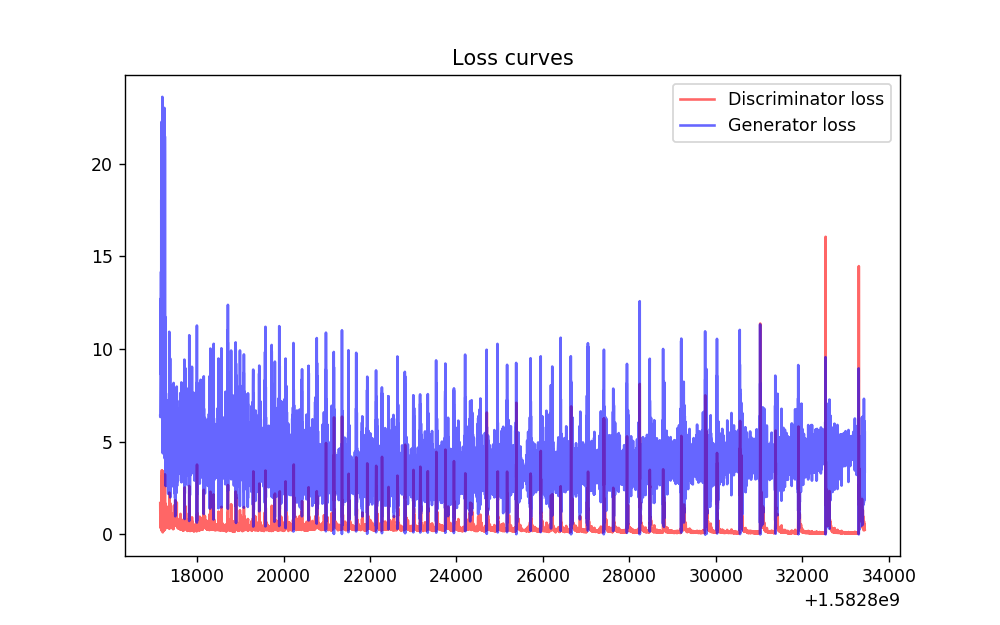

In [35]:
plot_loss_curves()

<IPython.core.display.Javascript object>


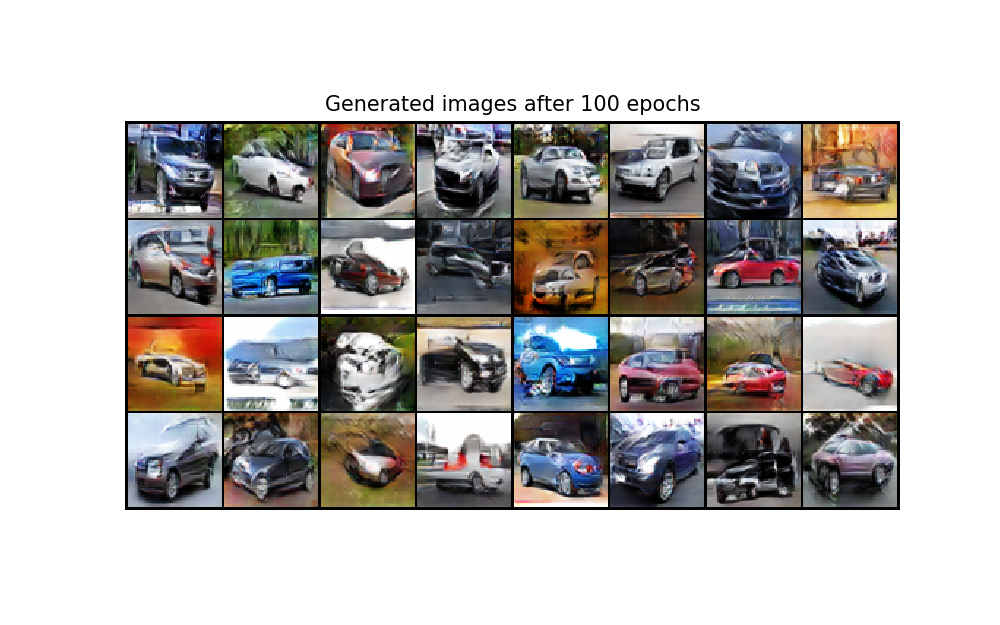

In [32]:
i = 99

generator = Generator().to(device)
g_optimiser = torch.optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

checkpoint = torch.load(MODEL_PATH + f'\generator_{i}_epochs.tar')
generator.load_state_dict(checkpoint['model_state_dict'])
g_optimiser.load_state_dict(checkpoint['optimiser_state_dict'])

generator.eval()

noise = torch.randn(32, z, 1, 1, device = device).to(device)
images = generator(noise).cpu().detach()
images = np.transpose(vutils.make_grid(images[:], normalize=True), (1,2,0))

fig, ax = plt.subplots(figsize = (8,5))
plt.axis('off')
plt.title(f'Generated images after {int(i) + 1} epochs')
plt.imshow(images)
plt.savefig('generated_images' + f'\generated_images_{i}_epochs.png')
plt.show()